In [198]:
![Hudson_county_](images/Hudson_county_.PNG)

'[Hudson_county_]' is not recognized as an internal or external command,
operable program or batch file.


# Real Estate Investment Statergy

### Author: Eric Romano

## Overview
One of the many questions that are asked about investments is why should you invest in real estate vs the stock market. As of 2018, the total equity capitaliztion in the US stock market was 30.4 trillion, while US real estate was estimated to be worth 49.3 trillion. There are two main reasons why Americans will continue to favor real estate as a long term investment

1. More consistency
2. Less volatilty

## Business Problem
A Real-Estate Investment Firm from North Jersey picked up on a growing demand from residents in NYC and their ever-growing desire to leave and head to New Jersey. The Investment firm reached out to my Consultant company to provide them direction into specific areas in Hudson County. The proximity to NYC is hard to beat and a transportation system already established makes this county the perfect location to explore. We are task to explore this area and determine the best zip codes in Hudson County to invest in.

1. Can we successfully use the available data to predict future ROI’s for all the zip codes in Hudson County?
2. What zip codes present the best ROI’s to in 2018 and 2019?
3. What investment strategies can be formulated by using the available data set provided by Zillow?
4. Can we build a tool that streamline prediction models and limit complexity to reduce time and cost?

### Hypothesis
Null Hypothesis (H0): The historical data does not persist over time and cannot be used to make predictions

Alternative Hypothesis (Ha) The historical data does persist over time and can be used to make predictions

## Data Understanding
Zillow provides their users the opportunity to use their platform to access specific datasets for research purposes. The dataset that we will be using contains the median home sales prices throughout all states sorted by their zip codes. With this dataset you can extract a lot of insight through out all states with the potential to understand markets and develop investment strategies. This platform allows the public to do independent research in any market in the US.

[Zillow Median Home Sales Price] This dataset contains 14723 rows and 272 columns

In [196]:
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns

from datetime import datetime, timedelta
from time import time

from sklearn.metrics import mean_squared_error
from scipy.stats import chi2
import math

from pmdarima.model_selection import train_test_split
from pandas.plotting import autocorrelation_plot
from pmdarima.arima import auto_arima
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set(rc={'figure.figsize':(8,6)})

zillow_data = pd.read_csv('zillow_data.csv')
zillow_data.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

In [2]:
zillow_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [3]:
# Helper Functions

def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

def melt_data(df):
    #id_vars keeps all columns you want to remain intake, var_name
    melted = pd.melt(df, id_vars=['RegionName', 'City'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

def stationarity_check(df,df_name,save_image=False):
    # Create rolling mean and std to test for trends
    roll_mean = df.rolling(window=8, center=False).mean()
    roll_std = df.rolling(window=8, center=False).std()
    
    # The Dickey-Fuller Test
    from statsmodels.tsa.stattools import adfuller
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(df)
    # Plot rolling statistics
    fig = plt.figure(figsize=(12,7))
    plt.plot(df, color = 'blue', label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation ' + df_name)
    plt.show(block=False)
    
    #Print Dickey_fuller test results
    print('Results of the Dickey-Fuller Test: \n')

    #Extract and display test results in a user friendly manner
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observation'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    if save_image == True:
        fig.savefig('Stationarity_check', bbox_inches='tight', dpi=150)
    return None

def train_test(df):
    pred_start = datetime(2017,1,1)
    pred_end = datetime(2018,1,1)

    # Setting the train data to extend to 1-1-2017
    train = df[:pred_start]
    # Setting the test data to extend to 1-1-2018
    test = df[pred_start + timedelta(days=1):pred_end]
    return train, test

def model_fit_ARIMA(df,pdq=(0,2,0)):
    train, test = train_test(df)
    model_arima = ARIMA(train,order=pdq)
    results = model_arima.fit()
    results.summary
    residuals = results.resid
    print(results.summary())
    return train, test, results

def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf 
    LR = (2*(L2-L1))
    p = chi2.sf(LR,DF).round(3)
    return p

def train_test(df):
    pred_start = datetime(2017,1,1)
    pred_end = datetime(2018,1,1)

    # Setting the train data to extend to 1-1-2017
    train = df[:pred_start]
    # Setting the test data to extend to 1-1-2018
    test = df[pred_start + timedelta(days=1):pred_end]
    return train, test

def model_fit_SARIMAX_year(df,pdq=(0,0,0),PDQS=(0,0,0,0)):
    train, test = train_test(df)
    model = SARIMAX(train,order=pdq,seasonal_order=PDQS)
    results = model.fit()
    results.summary
    residuals = results.resid
    print(results.summary())
    results.plot_diagnostics(figsize=(11,8))
    plt.show();
    return train, test, results

def train_test_6m(df, ps, pe):
    pred_start = ps
    pred_end = pe

    # Setting the train data to extend to 6-1-2017
    train = df[:pred_start]
    # Setting the test data to extend to 1-1-2018
    test = df[pred_start + timedelta(days=1):pred_end]
    return train, test

def model_fit_SARIMAX(df,pdq=(0,0,0),PDQS=(0,0,0,0), ps=datetime(2017,6,1), pe=datetime(2018,1,1)):
    train, test = train_test_6m(df, ps, pe)
    model = SARIMAX(train,order=pdq,seasonal_order=PDQS)
    results = model.fit()
    results.summary
    residuals = results.resid
    print(results.summary())
    results.plot_diagnostics(figsize=(11,8))
    plt.show();
    return train, test, results


### Introduction
In this analysis I will be looking into NJ, specifiically husdson county, to find the best locations within this county to invest in. 

In [4]:
NJ_Hudson_zd = zillow_data.loc[(zillow_data.State == 'NJ')&(zillow_data.CountyName == 'Hudson')]
NJ_Hudson_zd.head(15)

RegionID  RegionName           City State     Metro CountyName  \
57       60545        7030        Hoboken    NJ  New York     Hudson   
187      60518        7002        Bayonne    NJ  New York     Hudson   
191      60639        7302    Jersey City    NJ  New York     Hudson   
214      60599        7093  West New York    NJ  New York     Hudson   
319      60594        7087     Union City    NJ  New York     Hudson   
519      60642        7305    Jersey City    NJ  New York     Hudson   
546      60560        7047   North Bergen    NJ  New York     Hudson   
660      60643        7306    Jersey City    NJ  New York     Hudson   
1737     60644        7307    Jersey City    NJ  New York     Hudson   
2989     60547        7032         Kearny    NJ  New York     Hudson   
5836     60600        7094       Secaucus    NJ  New York     Hudson   
6330     60593        7086      Weehawken    NJ  New York     Hudson   
6524     60544        7029       Harrison    NJ  New York     Hudson   

      SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
57          58  301600.0  302700.0  303800.0  ...  1789100  1803000  1818100   
187        188  145000.0  144500.0  143900.0  ...   318500   324100   330900   
191        192  137200.0  137800.0  138500.0  ...  1340200  1372300  1411000   
214        215  131700.0  131900.0  132100.0  ...   361200   368200   376800   
319        320  127300.0  127000.0  126700.0  ...   367000   377500   386000   
519        520  105200.0  104500.0  103800.0  ...   228000   231200   234600   
546        547  147200.0  146800.0  146400.0  ...   365100   366200   368300   
660        661  111400.0  111100.0  110900.0  ...   465400   469800   475900   
1737      1738  114300.0  114300.0  114400.0  ...   439500   449000   458300   
2989      2990  150300.0  150200.0  150100.0  ...   307800   311900   316300   
5836      5837  189600.0  189300.0  188900.0  ...   463700   467500   473400   
6330      6331  169700.0  169900.0  170000.0  ...   661200   676200   695300   
6524      6525  154200.0  154300.0  154400.0  ...   378000   376600   376500   

      2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
57    1836900  1850100  1853500  1852200  1854400  1857600  1854300  
187    339000   347400   352800   355900   361500   368700   372900  
191   1435900  1446300  1447800  1454900  1453900  1439500  1427300  
214    386200   392900   395100   395500   399400   407000   412700  
319    394700   403700   410500   415500   424000   437400   448900  
519    241100   251100   261600   268600   276000   286700   295100  
546    374100   383300   389900   391200   396500   409200   419100  
660    484000   495800   506700   510000   515300   531900   545500  
1737   468100   478200   487300   496000   510600   531900   546600  
2989   321800   327100   331300   334900   338100   341300   343200  
5836   479100   483500   486600   487300   492100   506500   520400  
6330   715100   730100   742600   749800   767700   804100   836100  
6524   378200   376500   373000   370300   370300   373100   377000  

[13 rows x 272 columns]

In [5]:
NJ_Hudson_zd = NJ_Hudson_zd.drop(['RegionID','State','Metro','CountyName','SizeRank'],axis=1)

In [6]:
NJ_Hudson_zd

RegionName           City   1996-04   1996-05   1996-06   1996-07  \
57          7030        Hoboken  301600.0  302700.0  303800.0  304800.0   
187         7002        Bayonne  145000.0  144500.0  143900.0  143300.0   
191         7302    Jersey City  137200.0  137800.0  138500.0  139100.0   
214         7093  West New York  131700.0  131900.0  132100.0  132300.0   
319         7087     Union City  127300.0  127000.0  126700.0  126400.0   
519         7305    Jersey City  105200.0  104500.0  103800.0  103100.0   
546         7047   North Bergen  147200.0  146800.0  146400.0  146000.0   
660         7306    Jersey City  111400.0  111100.0  110900.0  110600.0   
1737        7307    Jersey City  114300.0  114300.0  114400.0  114500.0   
2989        7032         Kearny  150300.0  150200.0  150100.0  150200.0   
5836        7094       Secaucus  189600.0  189300.0  188900.0  188500.0   
6330        7086      Weehawken  169700.0  169900.0  170000.0  170100.0   
6524        7029       Harrison  154200.0  154300.0  154400.0  154400.0   

       1996-08   1996-09   1996-10   1996-11  ...  2017-07  2017-08  2017-09  \
57    305800.0  306800.0  308100.0  309400.0  ...  1789100  1803000  1818100   
187   142800.0  142400.0  142100.0  142000.0  ...   318500   324100   330900   
191   139600.0  140100.0  140700.0  141400.0  ...  1340200  1372300  1411000   
214   132500.0  132700.0  133000.0  133500.0  ...   361200   368200   376800   
319   126100.0  125900.0  125800.0  125800.0  ...   367000   377500   386000   
519   102600.0  102100.0  101800.0  101700.0  ...   228000   231200   234600   
546   145800.0  145800.0  146100.0  146600.0  ...   365100   366200   368300   
660   110300.0  110000.0  109700.0  109400.0  ...   465400   469800   475900   
1737  114800.0  115200.0  115700.0  116300.0  ...   439500   449000   458300   
2989  150200.0  150400.0  150600.0  150900.0  ...   307800   311900   316300   
5836  188100.0  187800.0  187500.0  187400.0  ...   463700   467500   473400   
6330  170200.0  170400.0  170800.0  171300.0  ...   661200   676200   695300   
6524  154500.0  154500.0  154600.0  154600.0  ...   378000   376600   376500   

      2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
57    1836900  1850100  1853500  1852200  1854400  1857600  1854300  
187    339000   347400   352800   355900   361500   368700   372900  
191   1435900  1446300  1447800  1454900  1453900  1439500  1427300  
214    386200   392900   395100   395500   399400   407000   412700  
319    394700   403700   410500   415500   424000   437400   448900  
519    241100   251100   261600   268600   276000   286700   295100  
546    374100   383300   389900   391200   396500   409200   419100  
660    484000   495800   506700   510000   515300   531900   545500  
1737   468100   478200   487300   496000   510600   531900   546600  
2989   321800   327100   331300   334900   338100   341300   343200  
5836   479100   483500   486600   487300   492100   506500   520400  
6330   715100   730100   742600   749800   767700   804100   836100  
6524   378200   376500   373000   370300   370300   373100   377000  

[13 rows x 267 columns]

In [7]:
df_time = get_datetimes(NJ_Hudson_zd.iloc[:,2::])
df_time

DatetimeIndex(['1996-05-01', '1996-06-01', '1996-07-01', '1996-08-01',
               '1996-09-01', '1996-10-01', '1996-11-01', '1996-12-01',
               '1997-01-01', '1997-02-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=264, freq=None)

In [8]:
NJ_HUDSON_zd = melt_data(NJ_Hudson_zd).set_index('time')

In [9]:
NJ_HUDSON_zd[NJ_HUDSON_zd.RegionName == 7093].asfreq('MS')

RegionName           City     value
time                                           
1996-04-01        7093  West New York  131700.0
1996-05-01        7093  West New York  131900.0
1996-06-01        7093  West New York  132100.0
1996-07-01        7093  West New York  132300.0
1996-08-01        7093  West New York  132500.0
...                ...            ...       ...
2017-12-01        7093  West New York  395100.0
2018-01-01        7093  West New York  395500.0
2018-02-01        7093  West New York  399400.0
2018-03-01        7093  West New York  407000.0
2018-04-01        7093  West New York  412700.0

[265 rows x 3 columns]

In [10]:
df_NJ_HudsonZC = []
for zc in NJ_HUDSON_zd.RegionName.unique():
    #Create seperate df for each zipcodes with a monthly fq
    df = NJ_HUDSON_zd[NJ_HUDSON_zd.RegionName == zc].asfreq('MS')
    df_NJ_HudsonZC.append(df)

In [11]:
len(df_NJ_HudsonZC)

13

# Fix graph. Add more detail from this graph. 

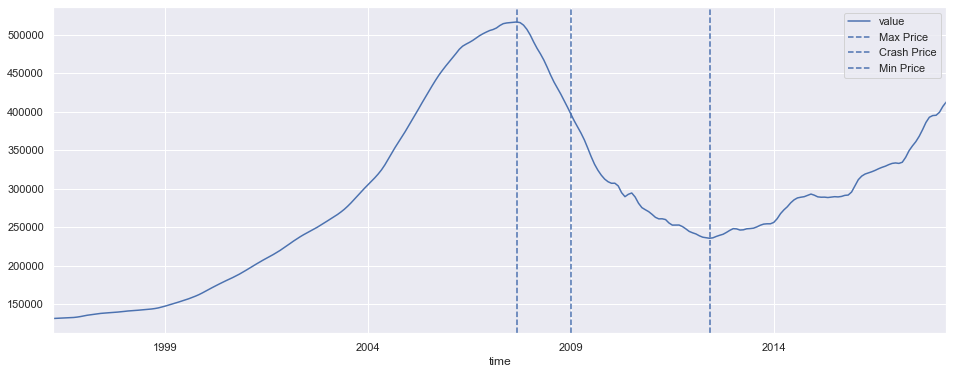

In [12]:
## Will locate the time before the housing market crash, the max value of homes in WNY
maxid = df_NJ_HudsonZC[3]['value'].loc['2004':'2010'].idxmax()
minid = df_NJ_HudsonZC[3]['value'].loc['2010':'2018'].idxmin()
## Will also show the time of the recorded housig market crash
crash = '01-2009'
## Plot the Average home values for WNY, with indicators for the max, market crash, and min
df_NJ_HudsonZC[3]['value'].plot(figsize= (16,6))

plt.axvline(maxid, label='Max Price', ls='--')
plt.axvline(crash, label='Crash Price', ls='--' )
plt.axvline(minid, label='Min Price', ls='--' )

plt.legend()

## Time zome we will use for this analysis
- 2012:2018

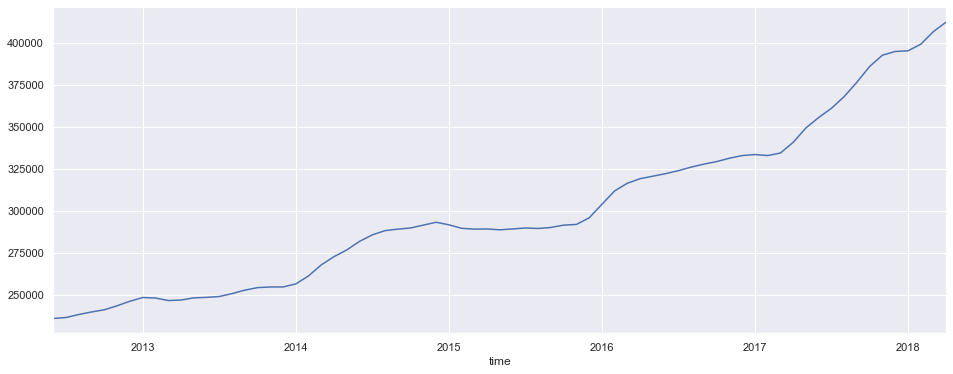

In [13]:
start = datetime(2012,6,1)
df_NJ_HudsonZC[3][start:]['value'].plot(figsize=(16,6))

In [14]:
list_RegionName = []
list_zip = NJ_HUDSON_zd.RegionName.unique().tolist()
for i in range(len(list_zip)):
    RegionName = NJ_Hudson_zd.loc[NJ_Hudson_zd.RegionName == list_zip[i]].City
    list_RegionName.append(RegionName.reset_index(drop=True)[0])

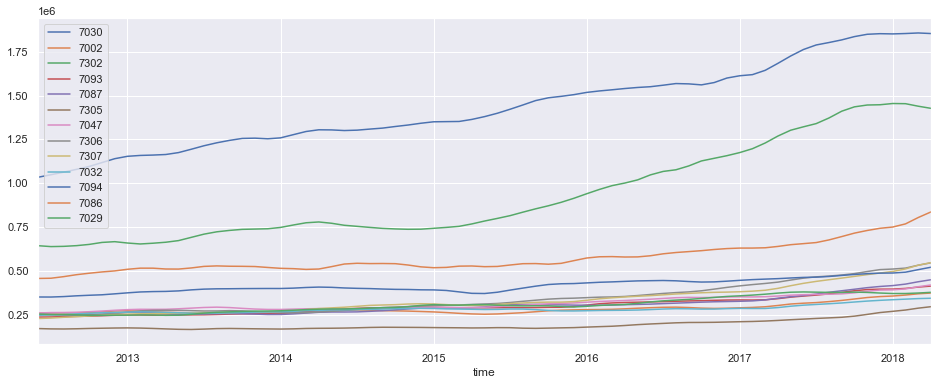

In [15]:
for i in range(len(df_NJ_HudsonZC)):
    df_NJ_HudsonZC[i][start:]['value'].plot(label=  list_zip[i], figsize = (16,6))
    plt.legend()

In [16]:
index_outliers = []
Outliers_zip = [7030, 7302, 7086]
for i in range(len(df_NJ_HudsonZC)):
    for j in range(len(Outliers_zip)):
        if df_NJ_HudsonZC[i]['RegionName'][0] == Outliers_zip[j]:
            index_outliers.append(i)

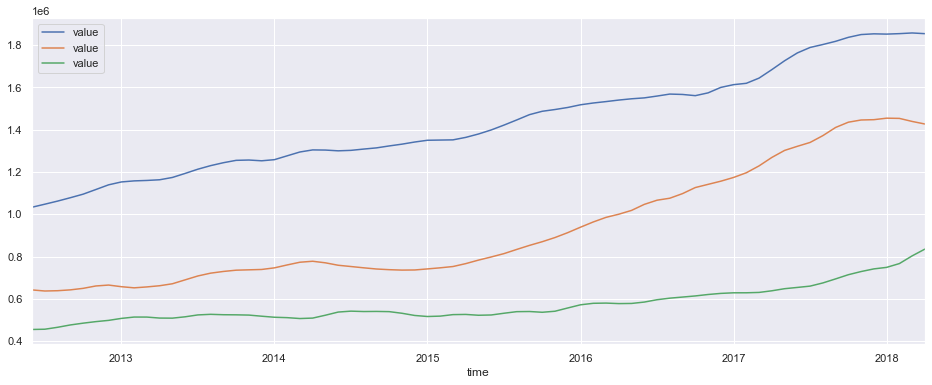

In [17]:
for i in range(len(index_outliers)):
    df_NJ_HudsonZC[index_outliers[i]][start:]['value'].plot(figsize = (16,6))
    plt.legend()

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<function matplotlib.pyplot.show(*args, **kw)>

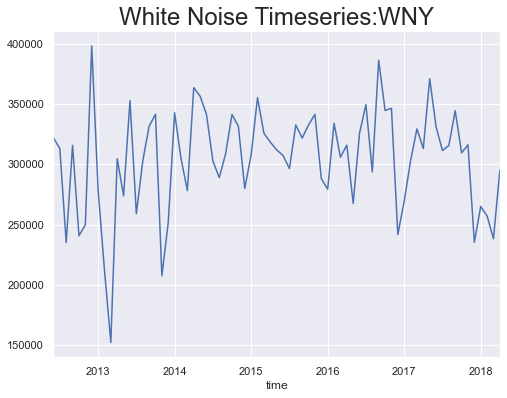

In [18]:
df_wny = df_NJ_HudsonZC[3][start:]
wn = np.random.normal(loc =df_NJ_HudsonZC[3][start:]['value'].mean(), scale = df_NJ_HudsonZC[3][start:]['value'].std(), size= len(df_NJ_HudsonZC[3][start:]['value']))
df_wny['wn'] = wn
## plot the randomly generated white noise 
df_wny.wn.plot()
plt.title('White Noise Timeseries:WNY', size=24)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

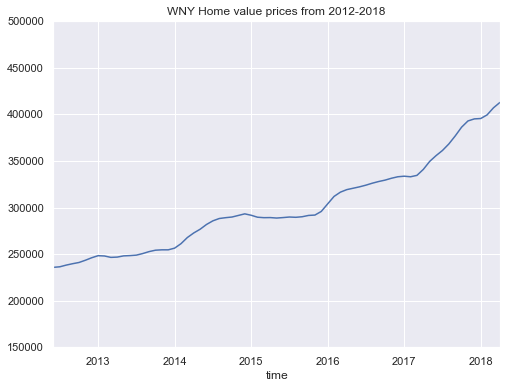

In [19]:
df_wny.value.plot()
plt.title('WNY Home value prices from 2012-2018')
plt.ylim(150000, 500000)
plt.show

In order to make good forcast we need to reconize the patterns that this time series follows

Market Efficiency
 - Measures the level of difficulty in forecasting correct future values 
     - If a time series resembles a random walk the prices can't be predicted with great accuracy 
     - if the time series can be predicted with great accuracy than there are **Arbitrage oppurtunities**

Arbitrage Example: 
- Buy and sell commodities and make a safe profit, while the price adjusts

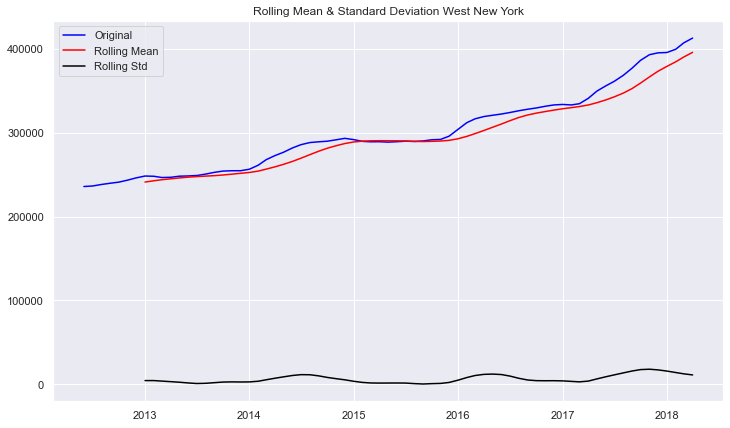

Results of the Dickey-Fuller Test: 

Test Statistic            2.519675
p-value                   0.999056
#lags Used               11.000000
Number of Observation    59.000000
Critical Value (1%)      -3.546395
Critical Value (5%)      -2.911939
Critical Value (10%)     -2.593652
dtype: float64


In [20]:
stationarity_check(df_NJ_HudsonZC[3][start:]['value'], df_NJ_HudsonZC[3].City[0])

# Pre-Processing Time Series: Stationarity
I will begin by trying to transform the time series into a stationary state by applying differencing.
- Note: In this analysis I first tried to evaluate the time series after differencing once and found that all the values were still not stationary. In this case another option you can try to find how many differencing you need to perform is by 

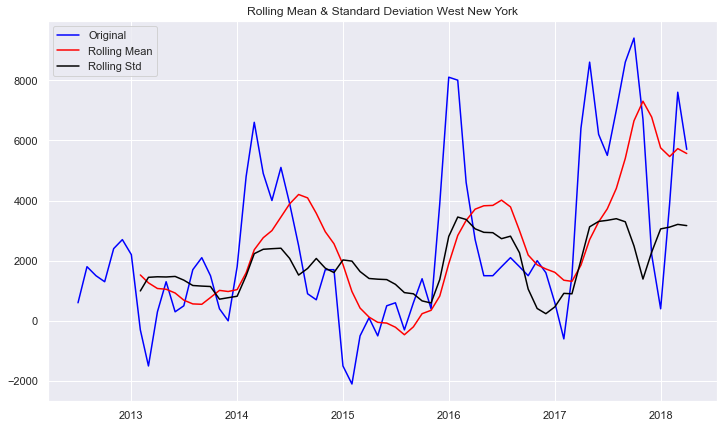

Results of the Dickey-Fuller Test: 

Test Statistic           -2.385699
p-value                   0.145814
#lags Used                8.000000
Number of Observation    61.000000
Critical Value (1%)      -3.542413
Critical Value (5%)      -2.910236
Critical Value (10%)     -2.592745
dtype: float64


In [21]:
#Example of a town with the home sale price data being differenced once. 
df_diff=df_NJ_HudsonZC[3][start:]['value'].diff()
df_diff.isna().sum()
df_diff.dropna(inplace=True)

stationarity_check(df_diff, df_NJ_HudsonZC[3].City[0])
#As you can see the p-value suggest that the time series is not stationary.

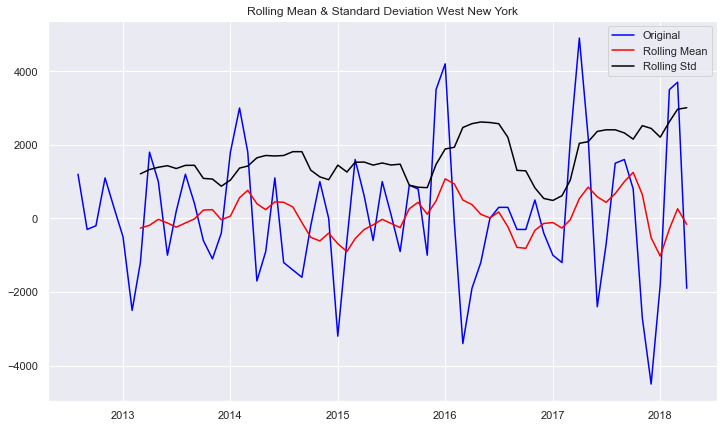

Results of the Dickey-Fuller Test: 

Test Statistic           -4.260622
p-value                   0.000519
#lags Used                6.000000
Number of Observation    62.000000
Critical Value (1%)      -3.540523
Critical Value (5%)      -2.909427
Critical Value (10%)     -2.592314
dtype: float64


In [22]:
#Example of a town with the home sale price data being differenced twice. 
df_diff2=df_NJ_HudsonZC[3][start:]['value'].diff().diff()
df_diff2.isna().sum()
df_diff2.dropna(inplace=True)

stationarity_check(df_diff2, df_NJ_HudsonZC[3].City[0], save_image=True)
#As you can see the p-value suggest that the time series is not stationary.

In [23]:
# We found that all towns home price data became stationary after you apply differencing twice. 
df_diff2 = []
for i in range(len(df_NJ_HudsonZC)):
    #Perform one differencing in all 
    df_diff = df_NJ_HudsonZC[i][start:]['value'].diff().diff()
    df_diff.isna().sum()
    df_diff.dropna(inplace=True)

    df_diff2.append(df_diff)

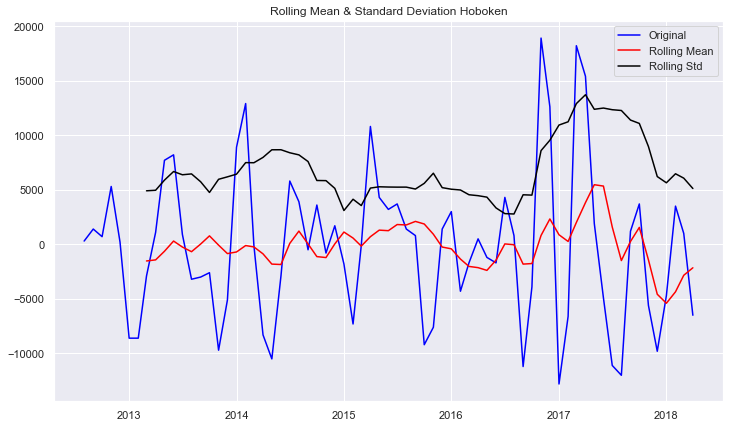

Results of the Dickey-Fuller Test: 

Test Statistic           -3.717489
p-value                   0.003874
#lags Used               11.000000
Number of Observation    57.000000
Critical Value (1%)      -3.550670
Critical Value (5%)      -2.913766
Critical Value (10%)     -2.594624
dtype: float64


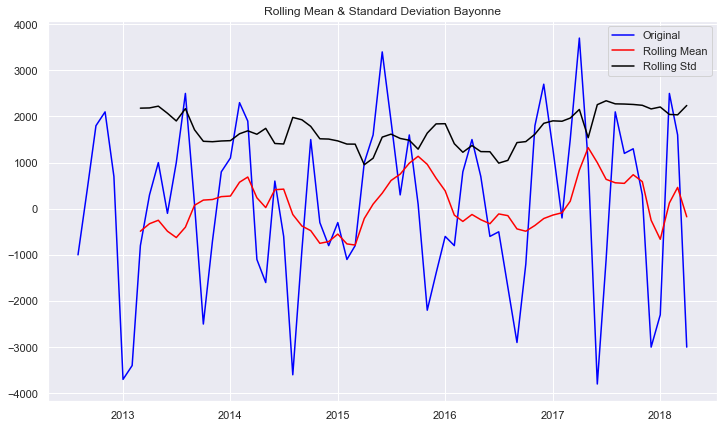

Results of the Dickey-Fuller Test: 

Test Statistic           -4.295475
p-value                   0.000452
#lags Used               11.000000
Number of Observation    57.000000
Critical Value (1%)      -3.550670
Critical Value (5%)      -2.913766
Critical Value (10%)     -2.594624
dtype: float64


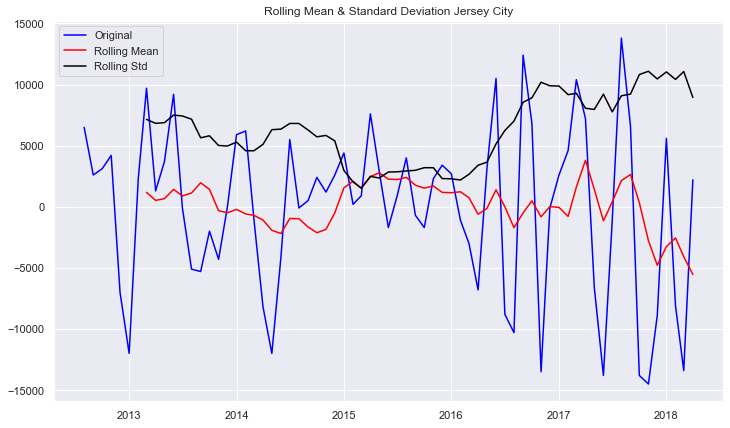

Results of the Dickey-Fuller Test: 

Test Statistic           -4.655017
p-value                   0.000102
#lags Used                2.000000
Number of Observation    66.000000
Critical Value (1%)      -3.533560
Critical Value (5%)      -2.906444
Critical Value (10%)     -2.590724
dtype: float64


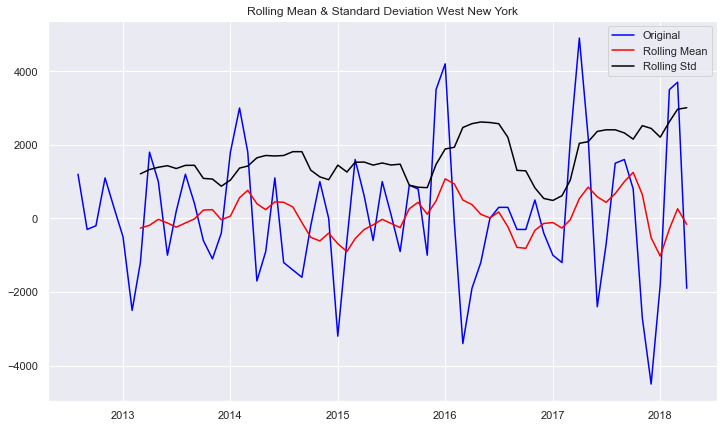

Results of the Dickey-Fuller Test: 

Test Statistic           -4.260622
p-value                   0.000519
#lags Used                6.000000
Number of Observation    62.000000
Critical Value (1%)      -3.540523
Critical Value (5%)      -2.909427
Critical Value (10%)     -2.592314
dtype: float64


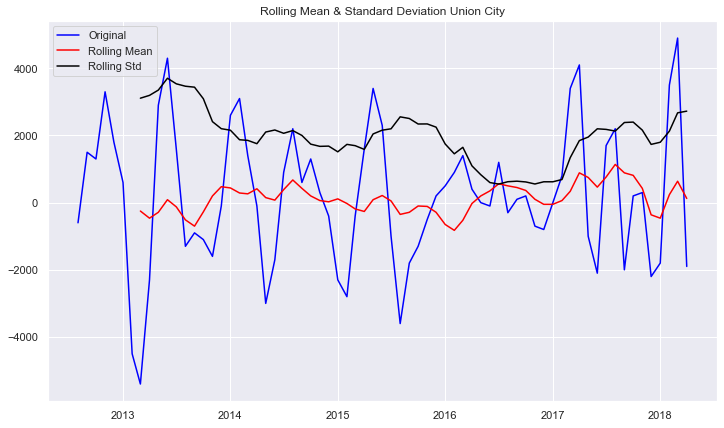

Results of the Dickey-Fuller Test: 

Test Statistic           -4.630772
p-value                   0.000113
#lags Used                5.000000
Number of Observation    63.000000
Critical Value (1%)      -3.538695
Critical Value (5%)      -2.908645
Critical Value (10%)     -2.591897
dtype: float64


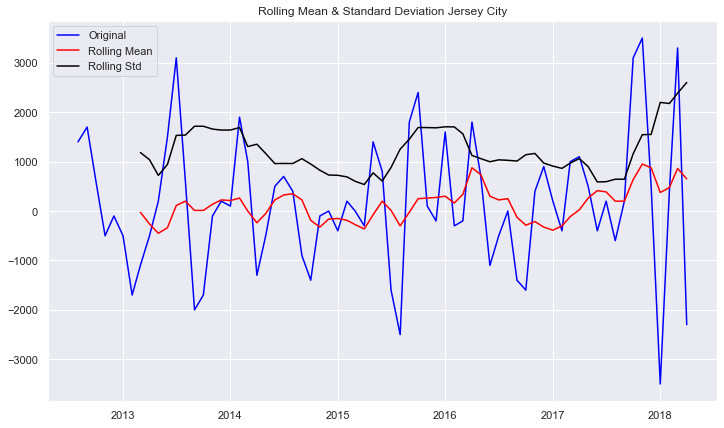

Results of the Dickey-Fuller Test: 

Test Statistic           -5.455397
p-value                   0.000003
#lags Used                3.000000
Number of Observation    65.000000
Critical Value (1%)      -3.535217
Critical Value (5%)      -2.907154
Critical Value (10%)     -2.591103
dtype: float64


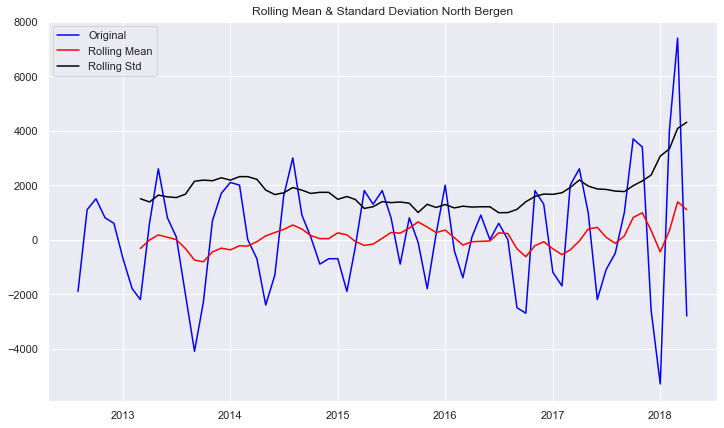

Results of the Dickey-Fuller Test: 

Test Statistic          -6.641766e+00
p-value                  5.387638e-09
#lags Used               3.000000e+00
Number of Observation    6.500000e+01
Critical Value (1%)     -3.535217e+00
Critical Value (5%)     -2.907154e+00
Critical Value (10%)    -2.591103e+00
dtype: float64


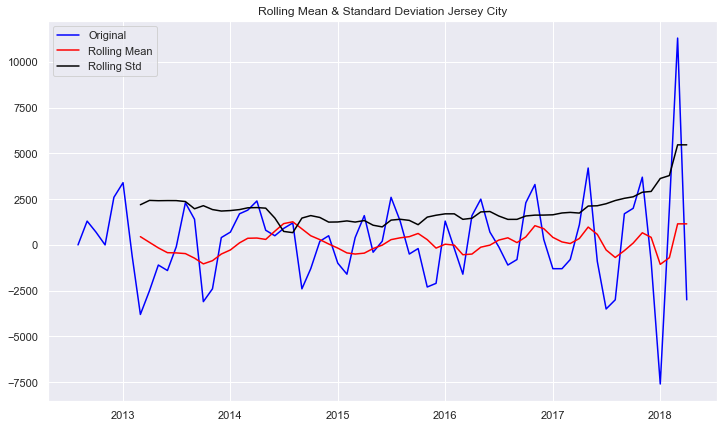

Results of the Dickey-Fuller Test: 

Test Statistic           -4.685287
p-value                   0.000090
#lags Used                6.000000
Number of Observation    62.000000
Critical Value (1%)      -3.540523
Critical Value (5%)      -2.909427
Critical Value (10%)     -2.592314
dtype: float64


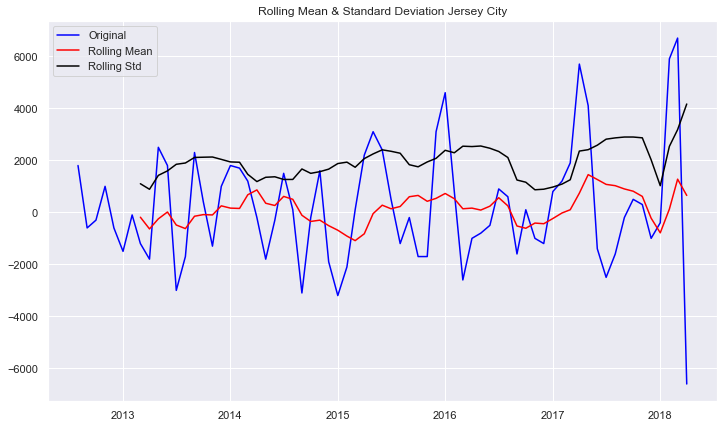

Results of the Dickey-Fuller Test: 

Test Statistic           -3.418407
p-value                   0.010347
#lags Used               10.000000
Number of Observation    58.000000
Critical Value (1%)      -3.548494
Critical Value (5%)      -2.912837
Critical Value (10%)     -2.594129
dtype: float64


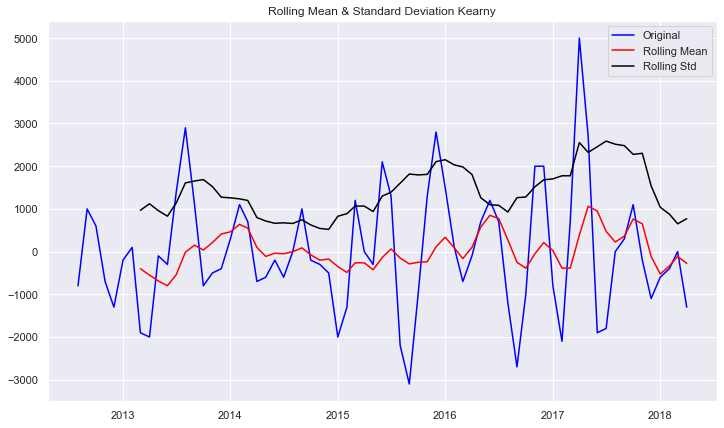

Results of the Dickey-Fuller Test: 

Test Statistic           -3.678684
p-value                   0.004423
#lags Used                5.000000
Number of Observation    63.000000
Critical Value (1%)      -3.538695
Critical Value (5%)      -2.908645
Critical Value (10%)     -2.591897
dtype: float64


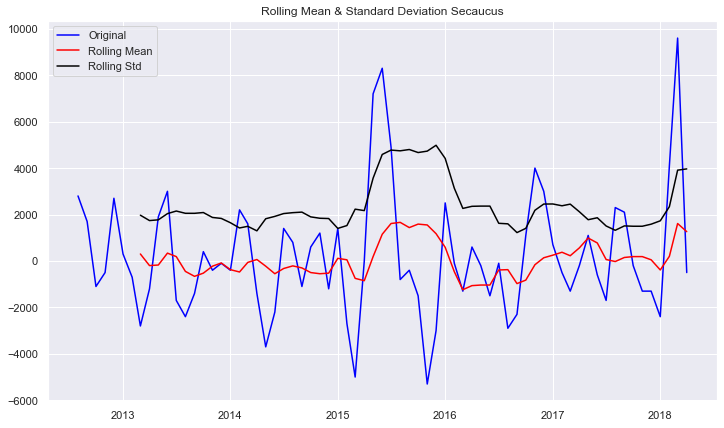

Results of the Dickey-Fuller Test: 

Test Statistic           -5.640826
p-value                   0.000001
#lags Used                3.000000
Number of Observation    65.000000
Critical Value (1%)      -3.535217
Critical Value (5%)      -2.907154
Critical Value (10%)     -2.591103
dtype: float64


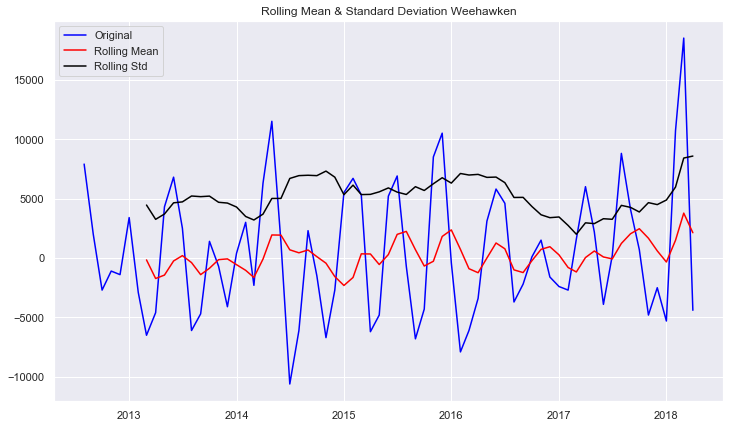

Results of the Dickey-Fuller Test: 

Test Statistic           -4.794042
p-value                   0.000056
#lags Used                6.000000
Number of Observation    62.000000
Critical Value (1%)      -3.540523
Critical Value (5%)      -2.909427
Critical Value (10%)     -2.592314
dtype: float64


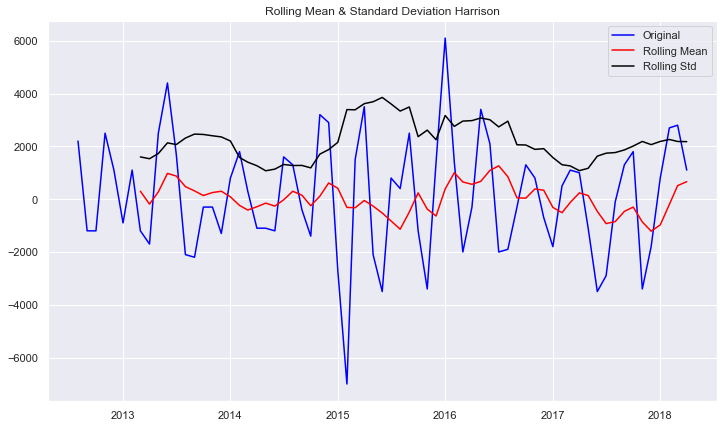

Results of the Dickey-Fuller Test: 

Test Statistic          -1.133951e+01
p-value                  1.063158e-20
#lags Used               1.000000e+00
Number of Observation    6.700000e+01
Critical Value (1%)     -3.531955e+00
Critical Value (5%)     -2.905755e+00
Critical Value (10%)    -2.590357e+00
dtype: float64


In [23]:
for i in range(len(df_diff2)):    
    stationarity_check(df_diff2[i], df_NJ_HudsonZC[i].City[0])

# ACF & PACF
- ACF : q parameter (MA)
- PACF : p parameter (AR)

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained un

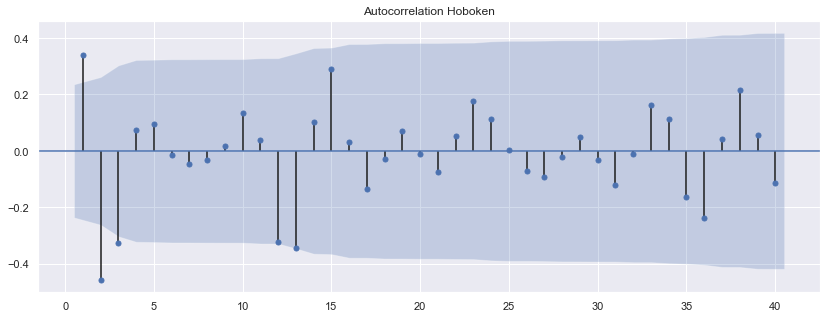

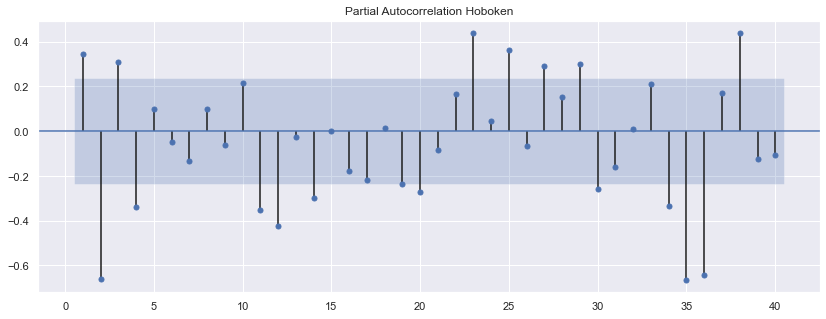

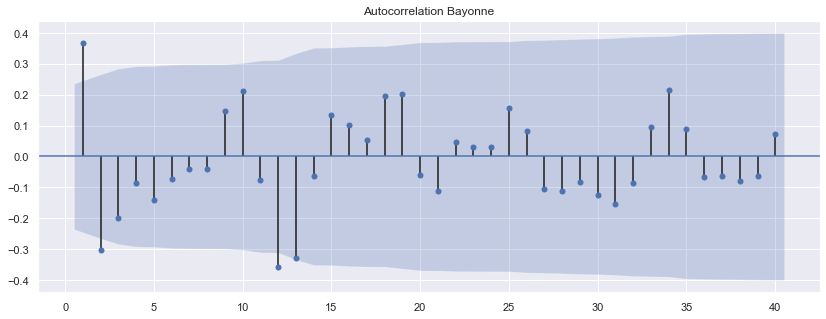

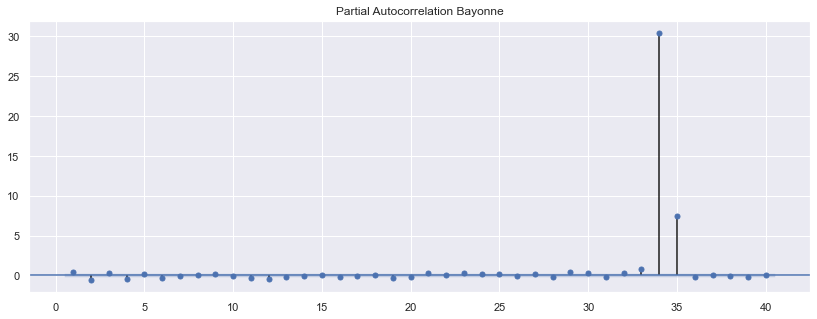

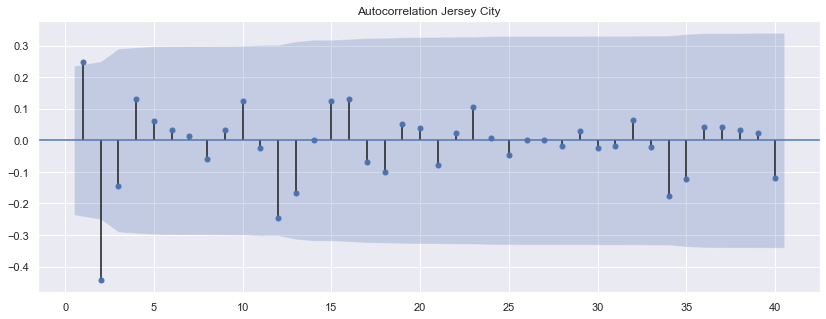

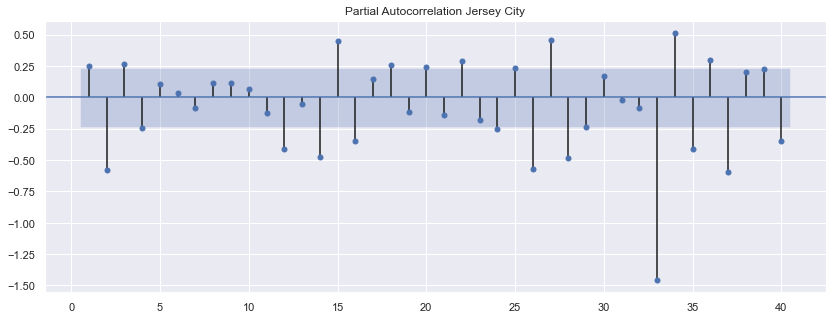

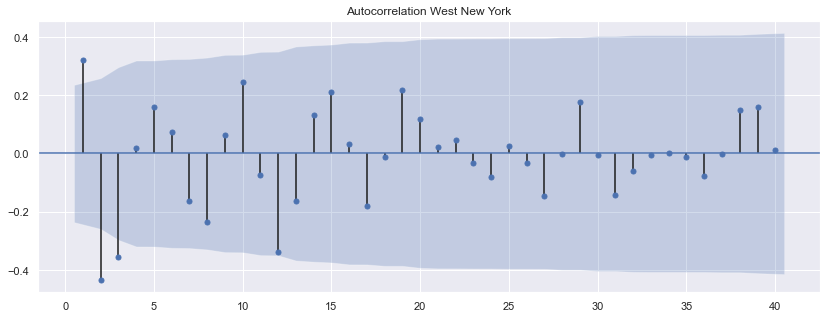

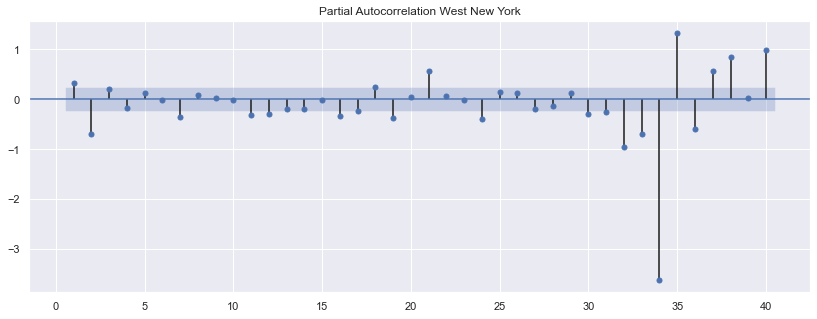

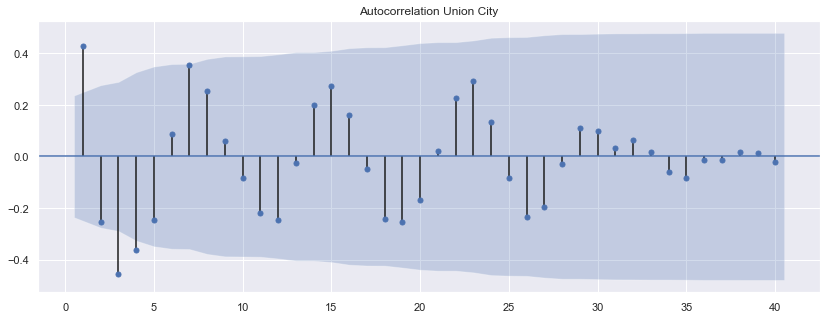

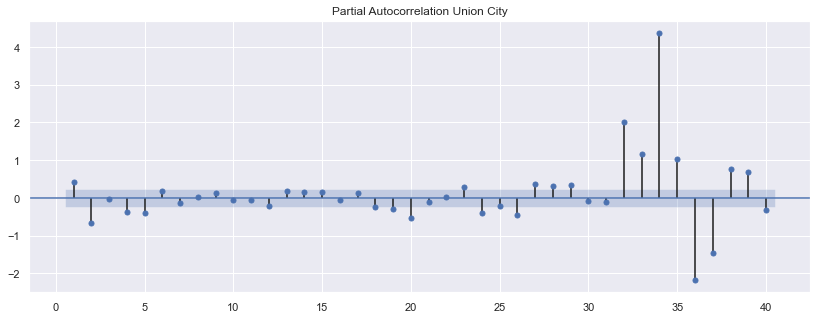

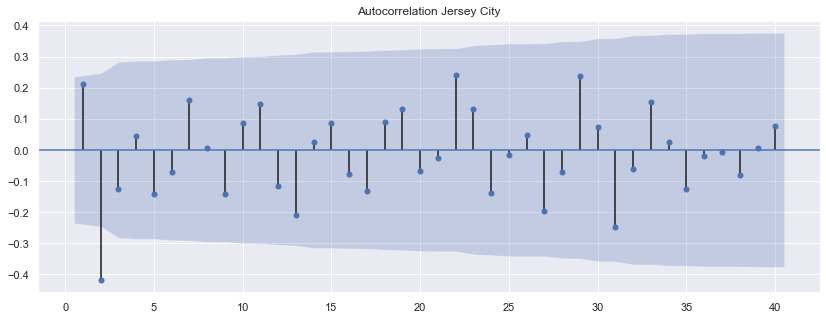

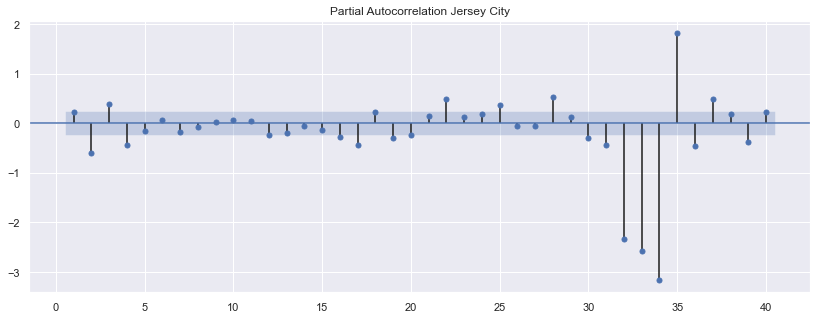

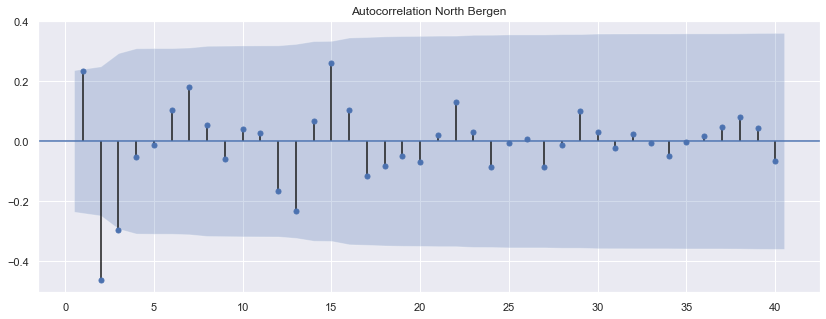

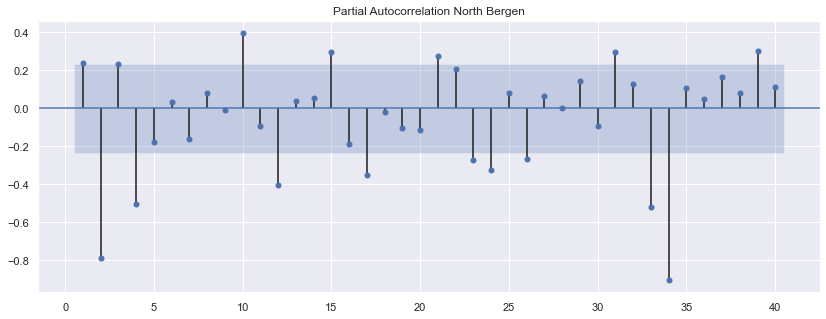

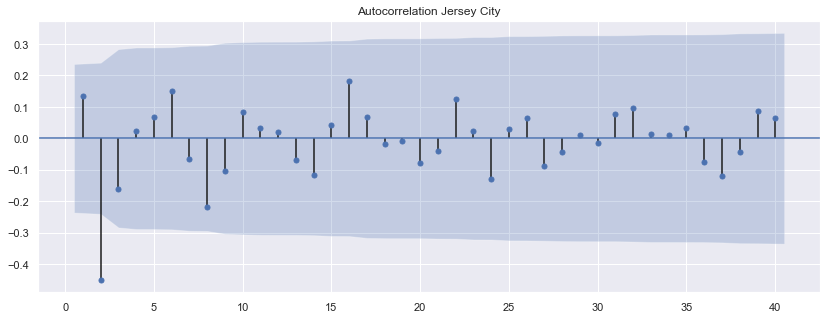

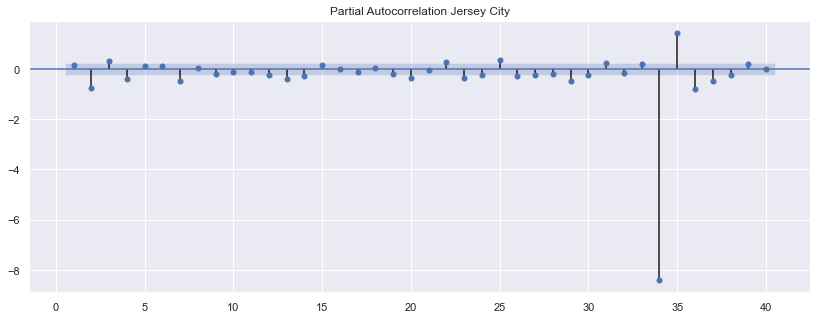

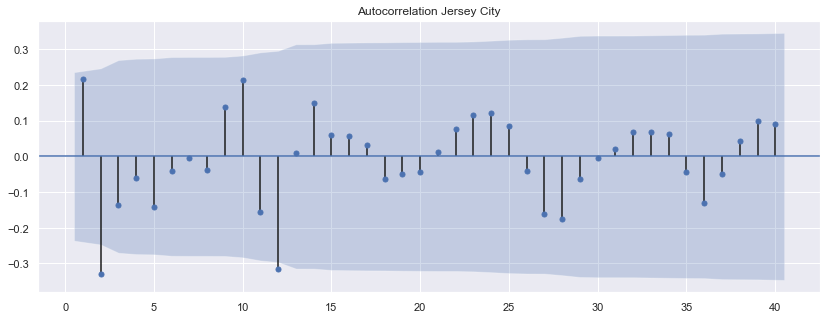

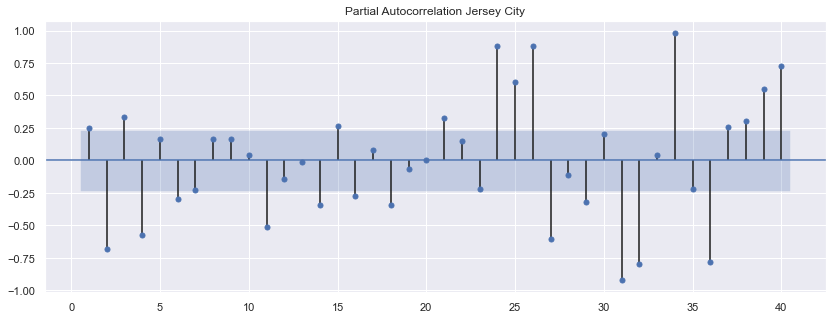

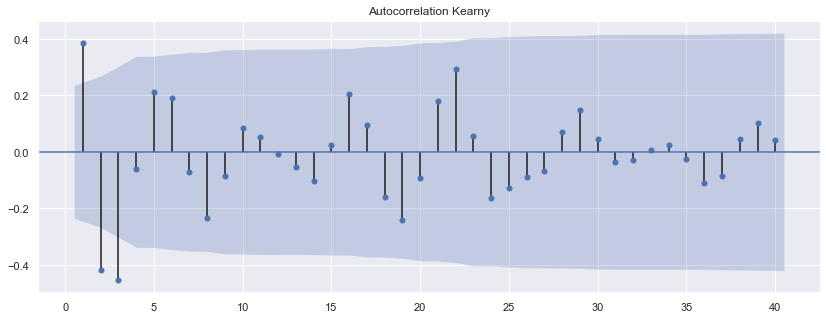

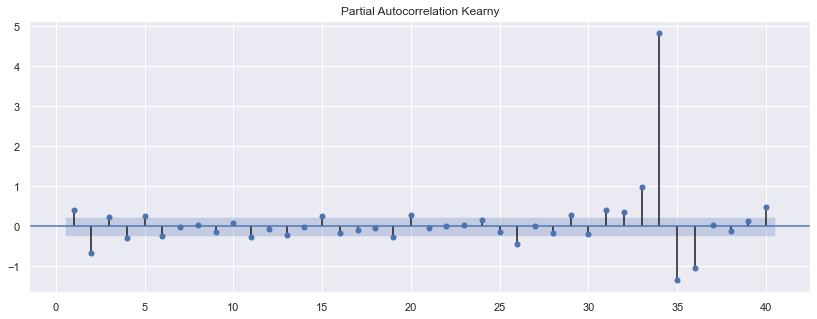

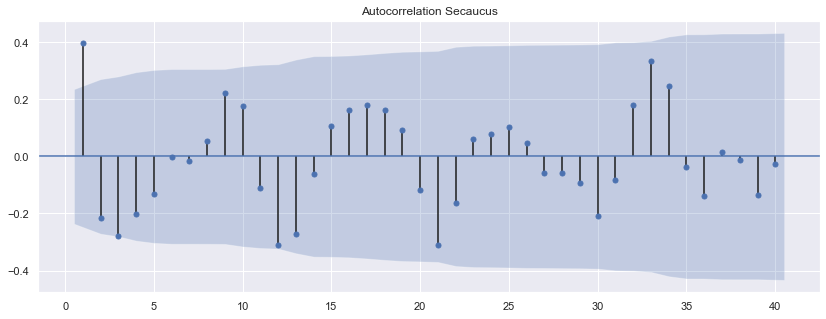

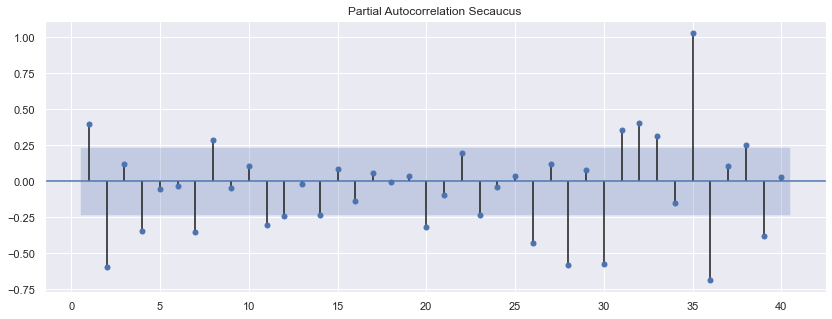

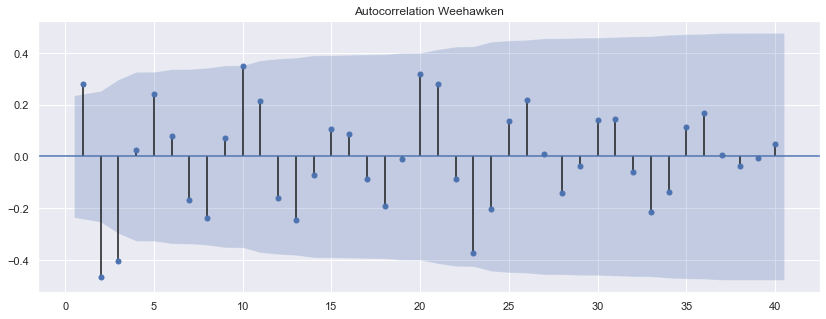

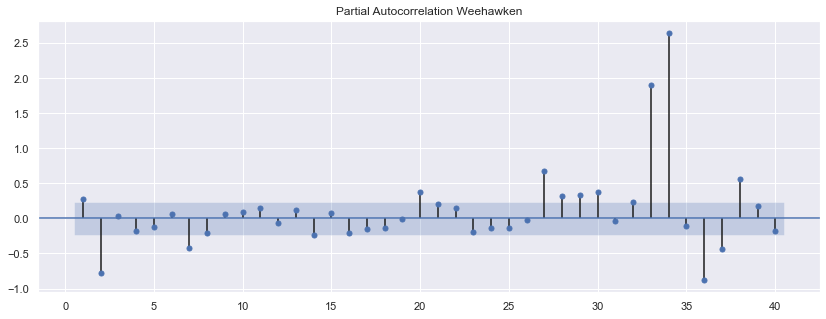

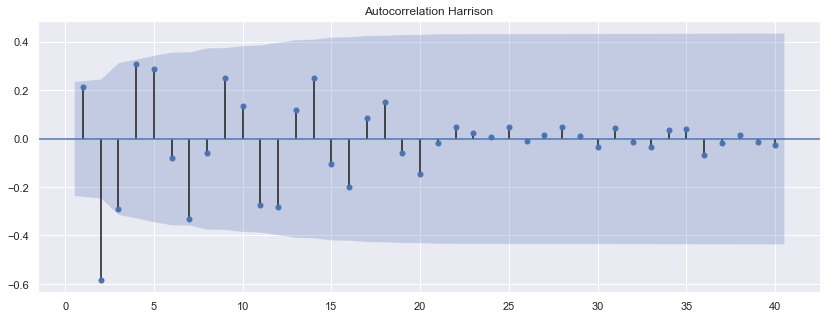

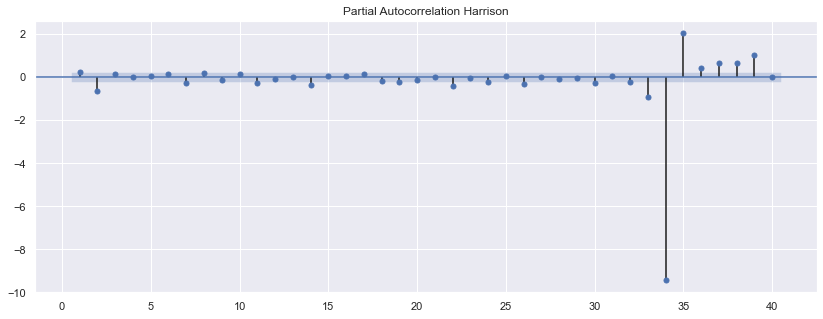

In [24]:
rcParams['figure.figsize'] = 14,5
for i in range(len(df_diff2)):
    plot_acf(df_diff2[i], title='Autocorrelation '+ df_NJ_HudsonZC[i].City[0], lags=40, zero=False,);
    plot_pacf(df_diff2[i], title='Partial Autocorrelation '+ df_NJ_HudsonZC[i].City[0], lags=40, zero=False, method=('ols'));

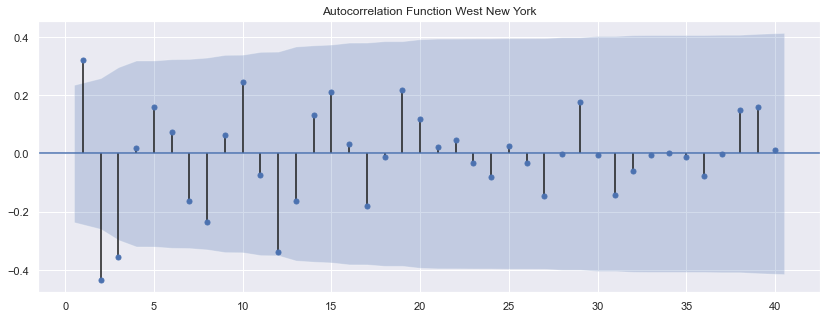

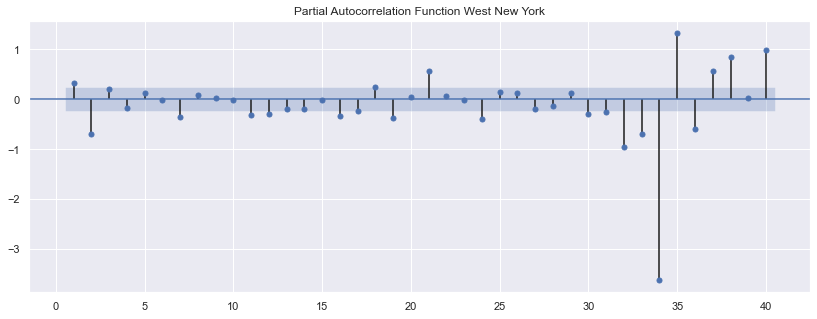

In [25]:
plot_acf(df_diff2[3], title='Autocorrelation Function '+ df_NJ_HudsonZC[3].City[0], lags=40, zero=False);
plot_pacf(df_diff2[3], title='Partial Autocorrelation Function '+ df_NJ_HudsonZC[3].City[0], lags=40, zero=False, method=('ols'));

In [26]:
decomposition = seasonal_decompose(df_NJ_HudsonZC[3][start:]['value'], model = 'additive')

# Gather the trend, seasonality, and residuals
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df_NJ_HudsonZC[i][start:]['value'], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='residual', color='blue')
plt.legend(loc='best')
plt.tight_layout()

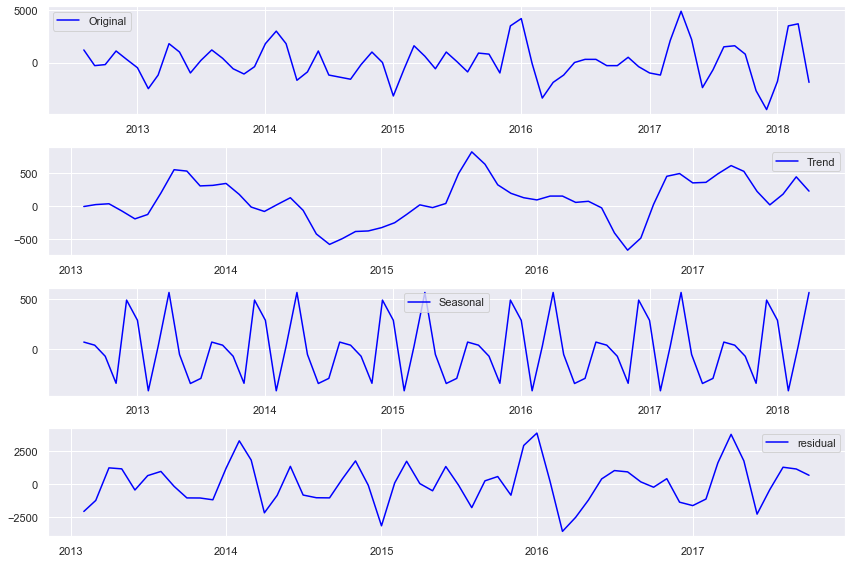

In [27]:
decomposition = seasonal_decompose(df_diff2[3])

# Gather the trend, seasonality, and residuals
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df_diff2[3], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='residual', color='blue')
plt.legend(loc='best')
plt.tight_layout()

In [28]:
decomposition = seasonal_decompose(df_NJ_HudsonZC[3][start:]['value'], model = 'multiplicative')

# Gather the trend, seasonality, and residuals
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df_NJ_HudsonZC[i][start:]['value'], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='residual', color='blue')
plt.legend(loc='best')
plt.tight_layout()

In [29]:
pdq = (2,2,0)
train, test, results = model_fit_ARIMA(df_NJ_HudsonZC[3][start:]['value'], pdq=pdq)

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(2, 2, 0)   Log Likelihood                -458.322
Method:                       css-mle   S.D. of innovations           1166.446
Date:                Sun, 25 Apr 2021   AIC                            924.643
Time:                        23:25:07   BIC                            932.599
Sample:                    08-01-2012   HQIC                           927.712
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.2765    152.268      0.041      0.967    -292.163     304.716
ar.L1.D2.value     0.4678      0.116      4.036      0.000       0.241       0.695
ar.L2.D2.value    -0.5210      0.113

ARIMA model RMSE on train data: 1201.37124
ARIMA model RMSE on test data: 33131.03595


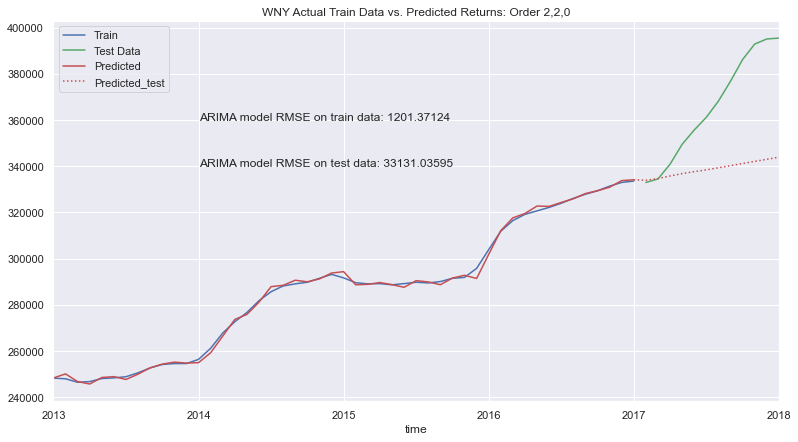

In [30]:
pred_start = datetime(2013,1,1)
pred_end = datetime(2017,1,1)
test_start = datetime(2017,1,1)
test_end = datetime(2018,1,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

fig = plt.figure(figsize=(13,7))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')
plt.text('2014',360000,f'ARIMA model RMSE on train data: %.5f' % rmse)
plt.text('2014',340000,f'ARIMA model RMSE on test data: %.5f' % rmse_test)
plt.legend(loc='best')
plt.title('WNY Actual Train Data vs. Predicted Returns: Order 2,2,0')
fig.savefig('Order2_2_0', bbox_inches='tight', dpi=150)
plt.show()


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import itertools
d=range(0,3)
p=range(0,10)
q=range(0,1)
pdq = list(itertools.product(p,d,q))

params=[]
aics=[]
LL=[]

for param in pdq:
    try:
        model_arima = ARIMA(train, order=param)
        model_arima_fit = model_arima.fit()
        params.append(param)
        aics.append(model_arima_fit.aic)
        LL.append(model_arima_fit.llf)
        
    except:
        continue
data_param = {'param':params,'AIC':aics, 'LLf':LL}
df_param = pd.DataFrame(data_param)
df_param.sort_values(by='AIC').head()

# For Educational Purpose: AR models
Here I will be comparing the Log Likelyhood Ratio to determine if the difference is signicant. 
In conclusion I have learned that as you continue to add more lags into the model you will eventually find lags that will add more insight and predict powers to the model. However, as you continue to add more lags the less chances the model will have to use its perdictive powers to new data. 
Here you will see that as we move past lag=2 the LLT is not significant until we reach to lags past 11 we start seeing an increase to predictive power. 

Questions: When exactly should you stop adding higher lag orders

In [58]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
model_arima_2 = ARIMA(train,order=(2,2,0))
results_2 = model_arima_2.fit()
results_2.summary()
residuals_2 = results_2.resid
print(results_2.summary())
    

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(2, 2, 0)   Log Likelihood                -458.322
Method:                       css-mle   S.D. of innovations           1166.446
Date:                Wed, 14 Apr 2021   AIC                            924.643
Time:                        20:57:02   BIC                            932.599
Sample:                    08-01-2012   HQIC                           927.712
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.2765    152.268      0.041      0.967    -292.163     304.716
ar.L1.D2.value     0.4678      0.116      4.036      0.000       0.241       0.695
ar.L2.D2.value    -0.5210      0.113

In [59]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
model_arima_3 = ARIMA(train,order=(3,2,0))
results_3 = model_arima_3.fit()
residuals_3 = results_3.resid
print(results_3.summary())
print('\nLLR test p-value =' + str(LLR_test(model_arima_2,model_arima_3)))



                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(3, 2, 0)   Log Likelihood                -457.206
Method:                       css-mle   S.D. of innovations           1141.219
Date:                Wed, 14 Apr 2021   AIC                            924.412
Time:                        20:57:06   BIC                            934.357
Sample:                    08-01-2012   HQIC                           928.247
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              8.3525    184.921      0.045      0.964    -354.086     370.791
ar.L1.D2.value     0.5775      0.135      4.290      0.000       0.314       0.841
ar.L2.D2.value    -0.6173      0.127

In [60]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
model_arima_4 = ARIMA(train,order=(4,2,0))
results_4 = model_arima_4.fit()
residuals_4 = results_4.resid
print(results_4.summary())
print('\nLLR test p-value =' + str(LLR_test(model_arima_3,model_arima_4)))

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(4, 2, 0)   Log Likelihood                -455.779
Method:                       css-mle   S.D. of innovations           1109.199
Date:                Wed, 14 Apr 2021   AIC                            923.557
Time:                        20:57:10   BIC                            935.491
Sample:                    08-01-2012   HQIC                           928.160
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.7189    148.340      0.039      0.969    -285.022     296.460
ar.L1.D2.value     0.6215      0.133      4.656      0.000       0.360       0.883
ar.L2.D2.value    -0.7615      0.150

In [61]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
model_arima_5 = ARIMA(train,order=(5,2,0))
results_5 = model_arima_5.fit()
residuals_5 = results_5.resid
print(results_5.summary())
print('\nLLR test p-value =' + str(LLR_test(model_arima_4,model_arima_5)))

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(5, 2, 0)   Log Likelihood                -455.772
Method:                       css-mle   S.D. of innovations           1109.052
Date:                Wed, 14 Apr 2021   AIC                            925.544
Time:                        20:57:24   BIC                            939.467
Sample:                    08-01-2012   HQIC                           930.913
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.5477    146.152      0.038      0.970    -280.905     292.000
ar.L1.D2.value     0.6177      0.137      4.498      0.000       0.349       0.887
ar.L2.D2.value    -0.7562      0.157

In [62]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
model_arima_6 = ARIMA(train,order=(6,2,0))
results_6 = model_arima_6.fit()
residuals_6 = results_6.resid
print(results_6.summary())
print('\nLLR test p-value =' + str(LLR_test(model_arima_5,model_arima_6)))

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(6, 2, 0)   Log Likelihood                -455.753
Method:                       css-mle   S.D. of innovations           1108.625
Date:                Wed, 14 Apr 2021   AIC                            927.507
Time:                        20:57:30   BIC                            943.419
Sample:                    08-01-2012   HQIC                           933.643
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.0322    142.675      0.035      0.972    -274.605     284.669
ar.L1.D2.value     0.6172      0.137      4.495      0.000       0.348       0.886
ar.L2.D2.value    -0.7621      0.160

In [63]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
model_arima_7 = ARIMA(train,order=(7,2,0))
results_7 = model_arima_7.fit()
residuals_7 = results_7.resid
print(results_7.summary())
print('\nLLR test p-value =' + str(LLR_test(model_arima_6,model_arima_7)))

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(7, 2, 0)   Log Likelihood                -453.512
Method:                       css-mle   S.D. of innovations           1057.783
Date:                Wed, 14 Apr 2021   AIC                            925.024
Time:                        20:57:36   BIC                            942.925
Sample:                    08-01-2012   HQIC                           931.928
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             11.8395    109.150      0.108      0.914    -202.090     225.769
ar.L1.D2.value     0.6186      0.130      4.744      0.000       0.363       0.874
ar.L2.D2.value    -0.7644      0.151

In [64]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
model_arima_8 = ARIMA(train,order=(8,2,0))
results_8 = model_arima_8.fit()
residuals_8 = results_8.resid
print(results_8.summary())
print('\nLLR test p-value =' + str(LLR_test(model_arima_7,model_arima_8)))

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(8, 2, 0)   Log Likelihood                -452.091
Method:                       css-mle   S.D. of innovations           1025.924
Date:                Wed, 14 Apr 2021   AIC                            924.182
Time:                        20:57:57   BIC                            944.072
Sample:                    08-01-2012   HQIC                           931.853
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              8.7338    134.107      0.065      0.948    -254.110     271.578
ar.L1.D2.value     0.6919      0.133      5.195      0.000       0.431       0.953
ar.L2.D2.value    -0.8101      0.148

In [65]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
model_arima_9 = ARIMA(train,order=(9,2,0))
results_9 = model_arima_9.fit()
residuals_9 = results_9.resid
print(results_9.summary())
print('\nLLR test p-value =' + str(LLR_test(model_arima_8,model_arima_9)))

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(9, 2, 0)   Log Likelihood                -451.965
Method:                       css-mle   S.D. of innovations           1023.309
Date:                Wed, 14 Apr 2021   AIC                            925.930
Time:                        20:58:03   BIC                            947.809
Sample:                    08-01-2012   HQIC                           934.368
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.7695    142.113      0.048      0.962    -271.767     285.306
ar.L1.D2.value     0.6752      0.137      4.936      0.000       0.407       0.943
ar.L2.D2.value    -0.7762      0.162

In [66]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
model_arima_10 = ARIMA(train,order=(10,2,0))
results_10 = model_arima_10.fit()
residuals_10 = results_10.resid
print(results_10.summary())
print('\nLLR test p-value =' + str(LLR_test(model_arima_9,model_arima_10)))

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                ARIMA(10, 2, 0)   Log Likelihood                -451.751
Method:                       css-mle   S.D. of innovations           1018.366
Date:                Wed, 14 Apr 2021   AIC                            927.502
Time:                        20:58:12   BIC                            951.370
Sample:                    08-01-2012   HQIC                           936.707
                         - 01-01-2017                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              12.1741    131.942      0.092      0.926    -246.427     270.776
ar.L1.D2.value      0.6835      0.137      5.006      0.000       0.416       0.951
ar.L2.D2.value     -0.7606      

In [67]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
model_arima_11 = ARIMA(train,order=(11,2,0))
results_11 = model_arima_11.fit()
residuals_11 = results_11.resid
print(results_11.summary())
print('\nLLR test p-value =' + str(LLR_test(model_arima_10,model_arima_11)))

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                ARIMA(11, 2, 0)   Log Likelihood                -447.182
Method:                       css-mle   S.D. of innovations            917.234
Date:                Wed, 14 Apr 2021   AIC                            920.364
Time:                        20:58:24   BIC                            946.221
Sample:                    08-01-2012   HQIC                           930.336
                         - 01-01-2017                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              46.8418     83.921      0.558      0.577    -117.641     211.325
ar.L1.D2.value      0.6370      0.122      5.242      0.000       0.399       0.875
ar.L2.D2.value     -0.7150      

In [68]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
model_arima_12 = ARIMA(train,order=(12,2,0))
results_12 = model_arima_12.fit()
residuals_12 = results_12.resid
print(results_12.summary())
print('\nLLR test p-value =' + str(LLR_test(model_arima_11,model_arima_12,DF=1)))

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                ARIMA(12, 2, 0)   Log Likelihood                -445.910
Method:                       css-mle   S.D. of innovations            889.935
Date:                Wed, 14 Apr 2021   AIC                            919.820
Time:                        20:58:47   BIC                            947.666
Sample:                    08-01-2012   HQIC                           930.559
                         - 01-01-2017                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              52.7463     66.756      0.790      0.429     -78.093     183.585
ar.L1.D2.value      0.5317      0.134      3.958      0.000       0.268       0.795
ar.L2.D2.value     -0.6692      

In [69]:
print('\nLLR test p-value =' + str(LLR_test(model_arima_2,model_arima_7)))
print('\nLLR test p-value =' + str(LLR_test(model_arima_2,model_arima_11)))
print('\nLLR test p-value =' + str(LLR_test(model_arima_7,model_arima_11)))


LLR test p-value =0.002

LLR test p-value =0.0

LLR test p-value =0.0


1.8422262031727006
1397737.6833576995


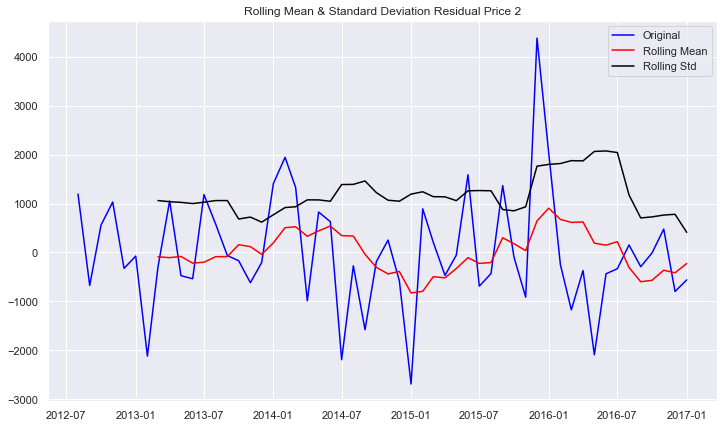

Results of the Dickey-Fuller Test: 

Test Statistic          -6.504260e+00
p-value                  1.141548e-08
#lags Used               0.000000e+00
Number of Observation    5.300000e+01
Critical Value (1%)     -3.560242e+00
Critical Value (5%)     -2.917850e+00
Critical Value (10%)    -2.596796e+00
dtype: float64
None
Figure(1008x360)


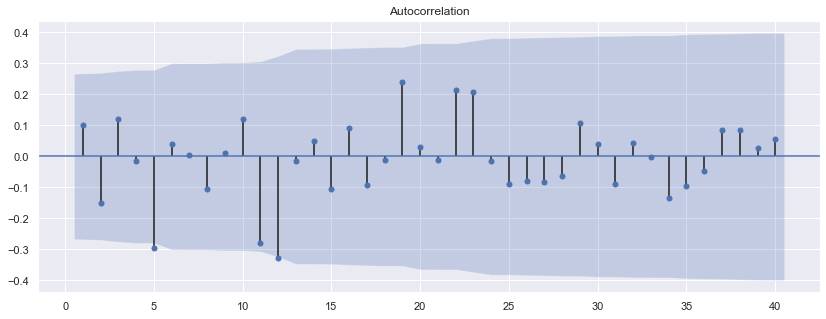

In [71]:
train['residual_price_2'] = residuals_2
print(train.residual_price_2.mean())
print(train.residual_price_2.var())
print(stationarity_check(train.residual_price_2, 'Residual Price 2'))
print(plot_acf(train.residual_price_2, zero=False, lags=40))


2.412869888869485
1166445.9254658024


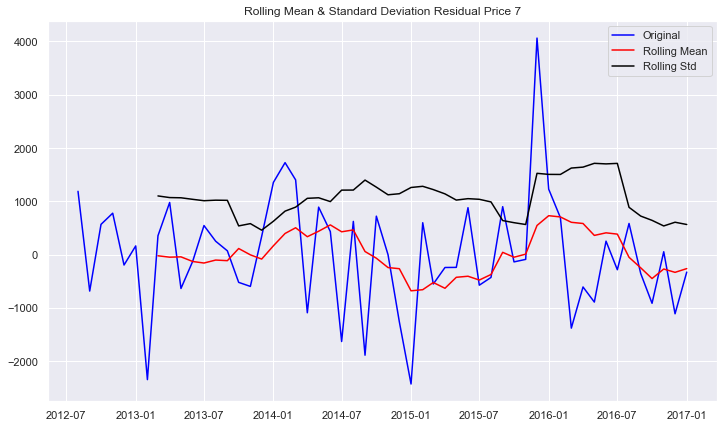

Results of the Dickey-Fuller Test: 

Test Statistic          -6.879661e+00
p-value                  1.444309e-09
#lags Used               0.000000e+00
Number of Observation    5.300000e+01
Critical Value (1%)     -3.560242e+00
Critical Value (5%)     -2.917850e+00
Critical Value (10%)    -2.596796e+00
dtype: float64
None


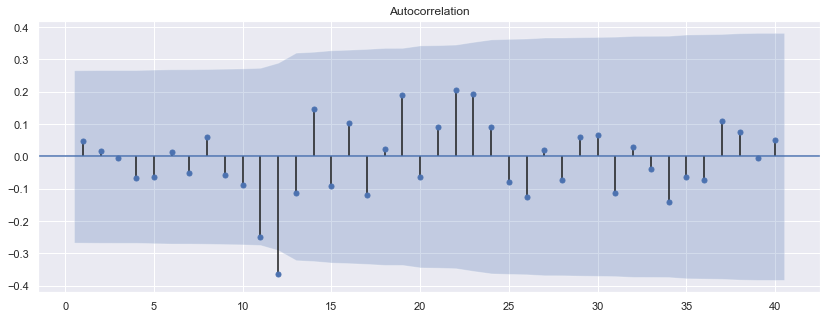

In [72]:
train['residual_price_7'] = residuals_7
print(train.residual_price_7.mean())
print(train.residual_price_7.var())
print(stationarity_check(train.residual_price_7, 'Residual Price 7'))
plot_acf(train.residual_price_7, zero=False, lags=40);

-2.752165296159181
918145.4003325939


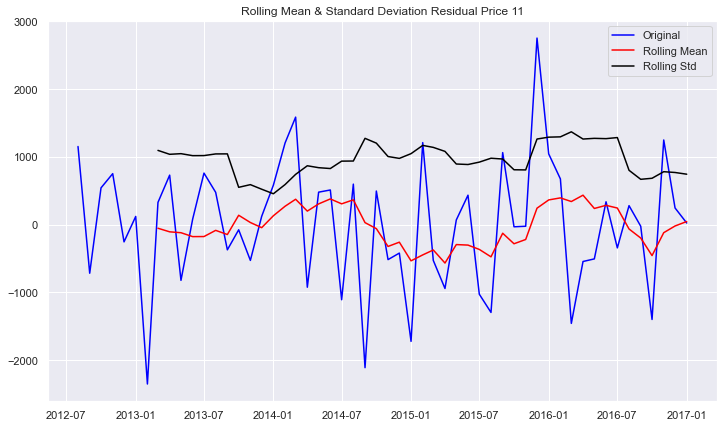

Results of the Dickey-Fuller Test: 

Test Statistic          -8.045759e+00
p-value                  1.796461e-12
#lags Used               0.000000e+00
Number of Observation    5.300000e+01
Critical Value (1%)     -3.560242e+00
Critical Value (5%)     -2.917850e+00
Critical Value (10%)    -2.596796e+00
dtype: float64
None


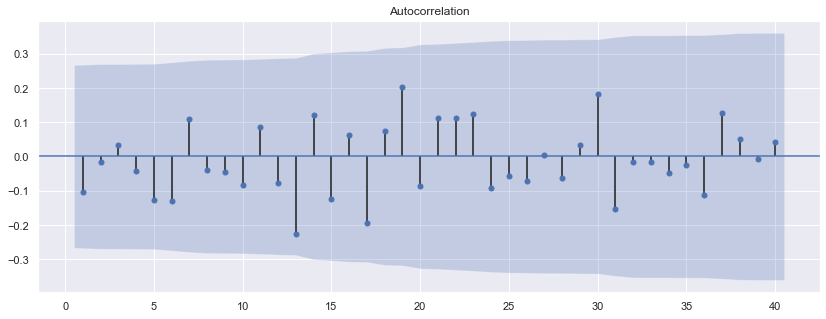

In [73]:
train['residual_price_11'] = residuals_11
print(train.residual_price_11.mean())
print(train.residual_price_11.var())
print(stationarity_check(train.residual_price_11, 'Residual Price 11'))
plot_acf(train.residual_price_11, zero=False, lags=40);

In [32]:
pdq = (11,2,0)
train, test, results = model_fit_ARIMA(df_NJ_HudsonZC[3][start:]['value'], pdq=pdq)

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                ARIMA(11, 2, 0)   Log Likelihood                -447.182
Method:                       css-mle   S.D. of innovations            917.234
Date:                Sun, 25 Apr 2021   AIC                            920.364
Time:                        23:27:32   BIC                            946.221
Sample:                    08-01-2012   HQIC                           930.336
                         - 01-01-2017                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              46.8418     83.921      0.558      0.577    -117.641     211.325
ar.L1.D2.value      0.6370      0.122      5.242      0.000       0.399       0.875
ar.L2.D2.value     -0.7150      

ARIMA model RMSE on train data: 967.76586
ARIMA model RMSE on test data: 13180.86683


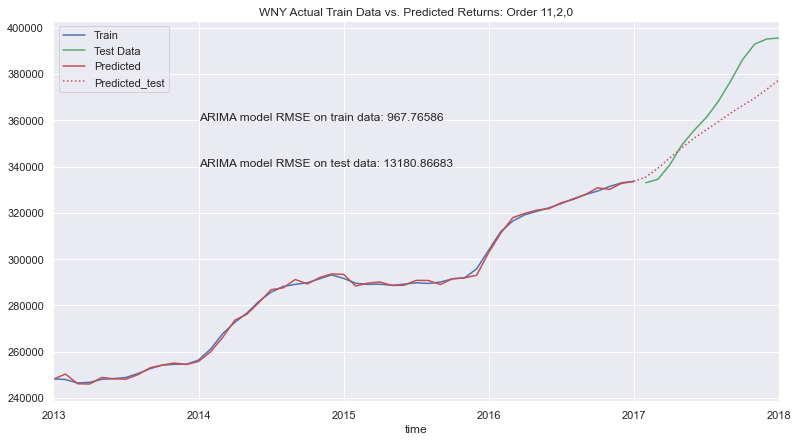

In [33]:
pred_start = datetime(2013,1,1)
pred_end = datetime(2017,1,1)
test_start = datetime(2017,1,1)
test_end = datetime(2018,1,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

fig = plt.figure(figsize=(13,7))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')
plt.text('2014',360000,f'ARIMA model RMSE on train data: %.5f' % rmse)
plt.text('2014',340000,f'ARIMA model RMSE on test data: %.5f' % rmse_test)
plt.legend(loc='best')
plt.title('WNY Actual Train Data vs. Predicted Returns: Order 11,2,0')
fig.savefig('Order11_2_0', bbox_inches='tight', dpi=150)
plt.show()

# Moving Average: MA

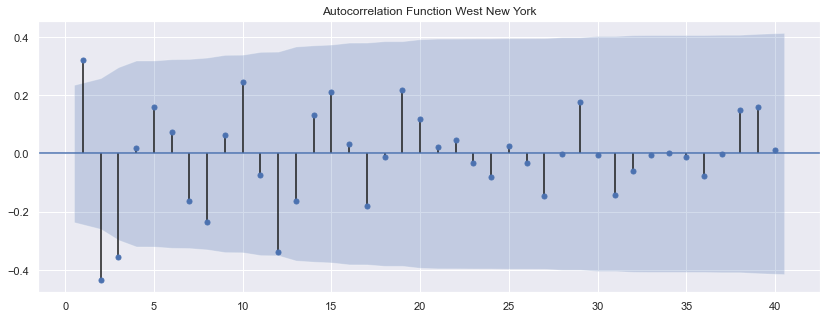

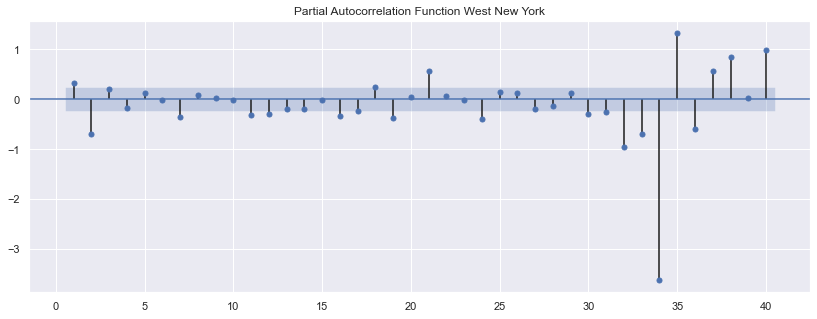

In [34]:
plot_acf(df_diff2[3], title='Autocorrelation Function '+ df_NJ_HudsonZC[3].City[0], lags=40, zero=False);
plot_pacf(df_diff2[3], title='Partial Autocorrelation Function '+ df_NJ_HudsonZC[3].City[0], lags=40, zero=False, method=('ols'));

In [81]:
import warnings
warnings.filterwarnings('ignore')
import itertools
d=range(0,3)
q=range(0,16)
p=range(0,1)
pdq = list(itertools.product(p,d,q))

params=[]
aics=[]
LL=[]

for param in pdq:
    try:
        model_arima = ARIMA(train, order=param)
        model_arima_fit = model_arima.fit()
        params.append(param)
        aics.append(model_arima_fit.aic)
        LL.append(model_arima_fit.llf)
        
    except:
        continue
data_param = {'param':params,'AIC':aics, 'LLf':LL}
df_param = pd.DataFrame(data_param)
df_param.sort_values(by='AIC').head()

param         AIC         LLf
22  (0, 2, 3)  912.828567 -451.414284
23  (0, 2, 4)  914.802122 -451.401061
24  (0, 2, 5)  915.916468 -450.958234
25  (0, 2, 6)  917.063070 -450.531535
26  (0, 2, 7)  918.999678 -450.499839

In [76]:
pdq = (0,2,1)
train, test, results = model_fit_ARIMA(df_NJ_HudsonZC[3][start:]['value'], pdq=pdq)

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -460.514
Method:                       css-mle   S.D. of innovations           1216.439
Date:                Wed, 14 Apr 2021   AIC                            927.029
Time:                        21:03:12   BIC                            932.996
Sample:                    08-01-2012   HQIC                           929.330
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.5323    273.733      0.020      0.984    -530.975     542.040
ma.L1.D2.value     0.6658      0.081      8.269      0.000       0.508       0.824
                                    

In [77]:
pdq = (0,2,2)
train, test, results = model_fit_ARIMA(df_NJ_HudsonZC[3][start:]['value'], pdq=pdq)

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(0, 2, 2)   Log Likelihood                -460.365
Method:                       css-mle   S.D. of innovations           1213.945
Date:                Wed, 14 Apr 2021   AIC                            928.729
Time:                        21:03:13   BIC                            936.685
Sample:                    08-01-2012   HQIC                           931.797
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.0284    230.518      0.013      0.990    -448.779     454.836
ma.L1.D2.value     0.5324      0.242      2.202      0.028       0.058       1.006
ma.L2.D2.value    -0.1322      0.229

In [78]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
model_arima_ma_2 = ARIMA(train,order=(0,2,2))
results_ma_2 = model_arima_ma_2.fit()
residuals_ma_2 = results_ma_2.resid
print(results_ma_2.summary())


                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(0, 2, 2)   Log Likelihood                -460.365
Method:                       css-mle   S.D. of innovations           1213.945
Date:                Wed, 14 Apr 2021   AIC                            928.729
Time:                        21:03:14   BIC                            936.685
Sample:                    08-01-2012   HQIC                           931.797
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.0284    230.518      0.013      0.990    -448.779     454.836
ma.L1.D2.value     0.5324      0.242      2.202      0.028       0.058       1.006
ma.L2.D2.value    -0.1322      0.229

In [79]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
model_arima_ma_3 = ARIMA(train,order=(0,2,3))
results_ma_3 = model_arima_ma_3.fit()
residuals_ma_3 = results_ma_3.resid
print(results_ma_3.summary())
print('\nLLR test p-value =' + str(LLR_test(model_arima_ma_2,model_arima_ma_3,DF=1)))

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(0, 2, 3)   Log Likelihood                -451.414
Method:                       css-mle   S.D. of innovations            975.854
Date:                Wed, 14 Apr 2021   AIC                            912.829
Time:                        21:03:15   BIC                            922.773
Sample:                    08-01-2012   HQIC                           916.664
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             18.1176     27.614      0.656      0.512     -36.006      72.241
ma.L1.D2.value     0.5995      0.129      4.635      0.000       0.346       0.853
ma.L2.D2.value    -0.6933      0.095

In [80]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
model_arima_ma_4 = ARIMA(train,order=(0,2,4))
results_ma_4 = model_arima_ma_4.fit()
residuals_ma_4 = results_ma_4.resid
print(results_ma_4.summary())
print('\nLLR test p-value =' + str(LLR_test(model_arima_ma_3,model_arima_ma_4,DF=1)))

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(0, 2, 4)   Log Likelihood                -451.401
Method:                       css-mle   S.D. of innovations            977.220
Date:                Wed, 14 Apr 2021   AIC                            914.802
Time:                        21:03:16   BIC                            926.736
Sample:                    08-01-2012   HQIC                           919.405
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             18.0923     28.102      0.644      0.520     -36.987      73.172
ma.L1.D2.value     0.6119      0.149      4.110      0.000       0.320       0.904
ma.L2.D2.value    -0.6785      0.131

In [81]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
model_arima_ma_5 = ARIMA(train,order=(0,2,5))
results_ma_5 = model_arima_ma_5.fit()
residuals_ma_5 = results_ma_5.resid
print(results_ma_5.summary())
print('\nLLR test p-value =' + str(LLR_test(model_arima_ma_3,model_arima_ma_5,DF=2)))

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(0, 2, 5)   Log Likelihood                -450.958
Method:                       css-mle   S.D. of innovations            944.501
Date:                Wed, 14 Apr 2021   AIC                            915.916
Time:                        21:03:19   BIC                            929.839
Sample:                    08-01-2012   HQIC                           921.286
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             18.9304     30.574      0.619      0.536     -40.994      78.854
ma.L1.D2.value     0.6415        nan        nan        nan         nan         nan
ma.L2.D2.value    -0.5798      0.168

In [82]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
model_arima_ma_6 = ARIMA(train,order=(0,2,6))
results_ma_6 = model_arima_ma_6.fit()
residuals_ma_6 = results_ma_6.resid
print(results_ma_6.summary())
print('\nLLR test p-value =' + str(LLR_test(model_arima_ma_3,model_arima_ma_6,DF=3)))

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(0, 2, 6)   Log Likelihood                -450.532
Method:                       css-mle   S.D. of innovations            964.204
Date:                Wed, 14 Apr 2021   AIC                            917.063
Time:                        21:03:23   BIC                            932.975
Sample:                    08-01-2012   HQIC                           923.200
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             17.4934     33.293      0.525      0.599     -47.760      82.747
ma.L1.D2.value     0.5995      0.155      3.856      0.000       0.295       0.904
ma.L2.D2.value    -0.5983      0.170

-2.636364694706757
1509864.963325154


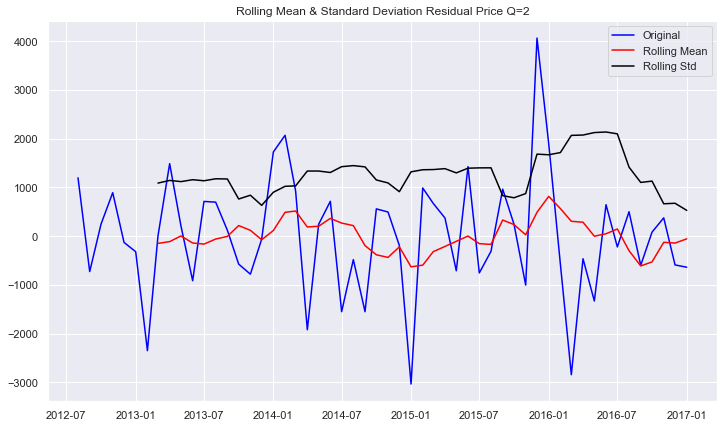

Results of the Dickey-Fuller Test: 

Test Statistic           -3.409474
p-value                   0.010640
#lags Used               11.000000
Number of Observation    42.000000
Critical Value (1%)      -3.596636
Critical Value (5%)      -2.933297
Critical Value (10%)     -2.604991
dtype: float64
None


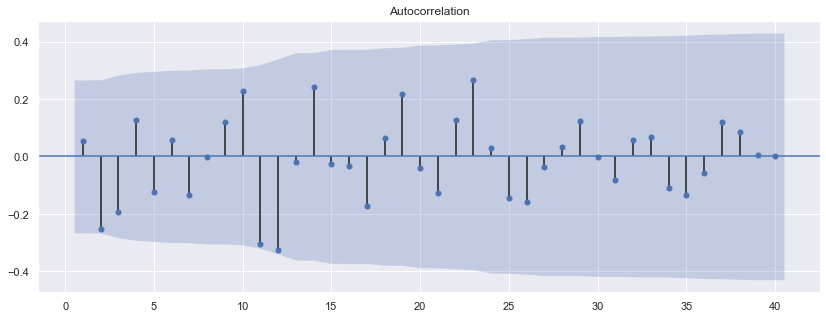

In [83]:
train['residual_price_ma_2'] = residuals_ma_2
print(train.residual_price_ma_2.mean())
print(train.residual_price_ma_2.var())
print(stationarity_check(train.residual_price_ma_2, 'Residual Price Q=2'))
plot_acf(train.residual_price_ma_2, zero=False, lags=40);

36.39707656625858
1062798.80669876


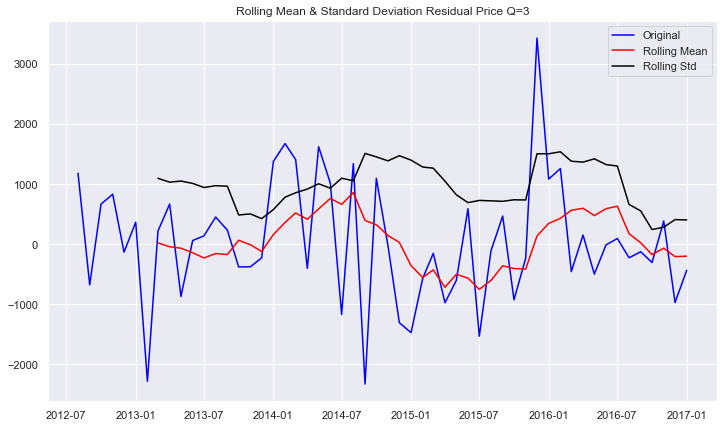

Results of the Dickey-Fuller Test: 

Test Statistic          -7.247944e+00
p-value                  1.811478e-10
#lags Used               0.000000e+00
Number of Observation    5.300000e+01
Critical Value (1%)     -3.560242e+00
Critical Value (5%)     -2.917850e+00
Critical Value (10%)    -2.596796e+00
dtype: float64
None


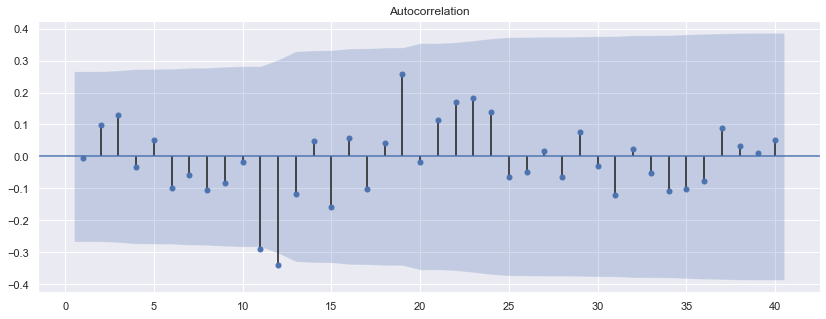

In [84]:
train['residual_price_ma_3'] = residuals_ma_3
print(train.residual_price_ma_3.mean())
print(train.residual_price_ma_3.var())
print(stationarity_check(train.residual_price_ma_3, 'Residual Price Q=3'))
plot_acf(train.residual_price_ma_3, zero=False, lags=40);

In [35]:
pdq = (0,2,3)
train, test, results = model_fit_ARIMA(df_NJ_HudsonZC[3][start:]['value'], pdq=pdq)

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(0, 2, 3)   Log Likelihood                -451.414
Method:                       css-mle   S.D. of innovations            975.854
Date:                Sun, 25 Apr 2021   AIC                            912.829
Time:                        23:28:54   BIC                            922.773
Sample:                    08-01-2012   HQIC                           916.664
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             18.1176     27.614      0.656      0.512     -36.006      72.241
ma.L1.D2.value     0.5995      0.129      4.635      0.000       0.346       0.853
ma.L2.D2.value    -0.6933      0.095

In [37]:
pred_start = datetime(2013,1,1)
pred_end = datetime(2017,1,1)
test_start = datetime(2017,1,1)
test_end = datetime(2018,1,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

fig = plt.figure(figsize=(13,7))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')
plt.text('2014',360000,f'ARIMA model RMSE on train data: %.5f' % rmse)
plt.text('2014',340000,f'ARIMA model RMSE on test data: %.5f' % rmse_test)
plt.legend(loc='best')
plt.title('WNY Actual Train Data vs. Predicted Returns Order:0,2,3')
fig.savefig('Order0_2_3', bbox_inches='tight', dpi=150)
plt.show()

ARIMA model RMSE on train data: 1043.84379
ARIMA model RMSE on test data: 23895.16048


In [98]:
import warnings
warnings.filterwarnings('ignore')
import itertools
d=range(0,3)
p=q=range(1,11)
pdq = list(itertools.product(p,d,q))

params=[]
aics=[]
LL=[]

for param in pdq:
    try:
        model_arima = ARIMA(train, order=param)
        model_arima_fit = model_arima.fit()
        params.append(param)
        aics.append(model_arima_fit.aic)
        LL.append(model_arima_fit.llf)
        
    except:
        continue
data_param = {'param':params,'AIC':aics, 'LLf':LL}
df_param = pd.DataFrame(data_param)
df_param.sort_values(by='AIC').head()

param         AIC         LLf
62  (9, 2, 3)  911.303294 -441.651647
6   (1, 2, 3)  914.793278 -451.396639
17  (2, 2, 3)  915.972075 -450.986037
7   (1, 2, 4)  916.217625 -451.108813
63  (9, 2, 7)  916.779515 -440.389757

In [38]:
pdq = (9,2,3)
train, test, results = model_fit_ARIMA(df_NJ_HudsonZC[3][start:]['value'], pdq=pdq)

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(9, 2, 3)   Log Likelihood                -441.652
Method:                       css-mle   S.D. of innovations            759.022
Date:                Sun, 25 Apr 2021   AIC                            911.303
Time:                        23:34:04   BIC                            939.149
Sample:                    08-01-2012   HQIC                           922.042
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             30.9679     23.077      1.342      0.180     -14.262      76.198
ar.L1.D2.value     1.9698      0.122     16.145      0.000       1.731       2.209
ar.L2.D2.value    -2.6467      0.264

In [39]:
pred_start = datetime(2013,1,1)
pred_end = datetime(2017,1,1)
test_start = datetime(2017,1,1)
test_end = datetime(2018,1,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

fig = plt.figure(figsize=(13,7))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')
plt.text('2014',360000,f'ARIMA model RMSE on train data: %.5f' % rmse)
plt.text('2014',340000,f'ARIMA model RMSE on test data: %.5f' % rmse_test)
plt.legend(loc='best')
plt.title('WNY Actual Train Data vs. Predicted Returns Order:9,2,3')
fig.savefig('Order9_2_3', bbox_inches='tight', dpi=150)
plt.show()

ARIMA model RMSE on train data: 869.43023
ARIMA model RMSE on test data: 17427.16817


In [90]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
model_arima_9_3 = ARIMA(train,order=(9,2,3))
results_9_3 = model_arima_9_3.fit()
residuals_9_3 = results_9_3.resid
print(results_9_3.summary())
print('\nLLR test p-value =' + str(LLR_test(model_arima_ma_3,model_arima_9_3,DF=9)))

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(9, 2, 3)   Log Likelihood                -441.652
Method:                       css-mle   S.D. of innovations            759.022
Date:                Wed, 14 Apr 2021   AIC                            911.303
Time:                        21:04:51   BIC                            939.149
Sample:                    08-01-2012   HQIC                           922.042
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             30.9679     23.077      1.342      0.180     -14.262      76.198
ar.L1.D2.value     1.9698      0.122     16.145      0.000       1.731       2.209
ar.L2.D2.value    -2.6467      0.264

In [91]:
# you also need to compare it with the AR at p= 11 
print('\nLLR test p-value =' + str(LLR_test(model_arima_11,model_arima_9_3,DF=1)))


LLR test p-value =0.001


In [101]:
train['residual_price_9_3'] = residuals_9_3
print(train.residual_price_9_3.mean())
print(train.residual_price_9_3.var())
print(stationarity_check(train.residual_price_9_3, 'Residual Price P=9 Q=3'))
plot_acf(train.residual_price_9_3, zero=False, lags=40);

28.665977346813854
751667.9558309704


Results of the Dickey-Fuller Test: 

Test Statistic          -7.941086e+00
p-value                  3.312521e-12
#lags Used               0.000000e+00
Number of Observation    5.300000e+01
Critical Value (1%)     -3.560242e+00
Critical Value (5%)     -2.917850e+00
Critical Value (10%)    -2.596796e+00
dtype: float64
None


In [101]:
results = auto_arima(train, start_p=9, d=2, start_q=3, max_p=11, max_q=5,
                     start_P=0, start_Q=0, max_P=5, max_Q=5,seasonal=True,
                     error_action='warn',trace=True,supress_warnings=True,stepwise=True,
                     random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(9,2,3)(0,0,0)[0]             : AIC=944.111, Time=0.65 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=941.271, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=943.062, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=943.908, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=946.083, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=943.271, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.777 seconds


In [102]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   56
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -469.636
Date:                Sun, 25 Apr 2021   AIC                            941.271
Time:                        21:02:51   BIC                            943.260
Sample:                             0   HQIC                           942.038
                                 - 56                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.094e+06   3.37e+05      6.207      0.000    1.43e+06    2.76e+06
===================================================================================
Ljung-Box (Q):                      102.63   Jarque-Bera (JB):                 2.74
Prob(Q):                              0.00   Prob(JB):                         0.25
Heteroskedasticity (H):               2.27   Skew:                             0.35
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
pdq = (0,2,0)
train, test, results = model_fit_ARIMA(df_NJ_HudsonZC[3][start:]['value'], pdq=pdq)

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(0, 2, 0)   Log Likelihood                -469.636
Method:                           css   S.D. of innovations           1448.115
Date:                Sun, 25 Apr 2021   AIC                            943.271
Time:                        23:36:49   BIC                            947.249
Sample:                    08-01-2012   HQIC                           944.805
                         - 01-01-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.487e-14    197.063  -1.26e-16      1.000    -386.237     386.237


ARIMA model RMSE on train data: 3715.02740
ARIMA model RMSE on test data: 34914.64592


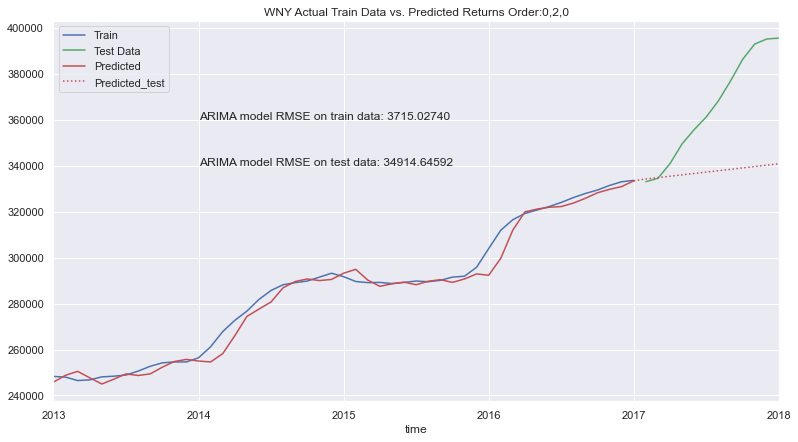

In [42]:
pred_start = datetime(2013,1,1)
pred_end = datetime(2017,1,1)
test_start = datetime(2017,1,1)
test_end = datetime(2018,1,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

fig= plt.figure(figsize=(13,7))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')
plt.text('2014',360000,f'ARIMA model RMSE on train data: %.5f' % rmse)
plt.text('2014',340000,f'ARIMA model RMSE on test data: %.5f' % rmse_test)
plt.legend(loc='best')
plt.title('WNY Actual Train Data vs. Predicted Returns Order:0,2,0')
fig.savefig('Order0_2_0', bbox_inches='tight', dpi=150)
plt.show()

In [43]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])
model_arima_auto = ARIMA(train,order=(0,2,0))
results_auto = model_arima_auto.fit()
residuals_auto = results_auto.resid
print(results_auto.summary())


                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   54
Model:                 ARIMA(0, 2, 0)   Log Likelihood                -469.636
Method:                           css   S.D. of innovations           1448.115
Date:                Sun, 25 Apr 2021   AIC                            943.271
Time:                        23:37:55   BIC                            947.249
Sample:                    08-01-2012   HQIC                           944.805
                         - 01-01-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.487e-14    197.063  -1.26e-16      1.000    -386.237     386.237


0.0
2136603.7735849055


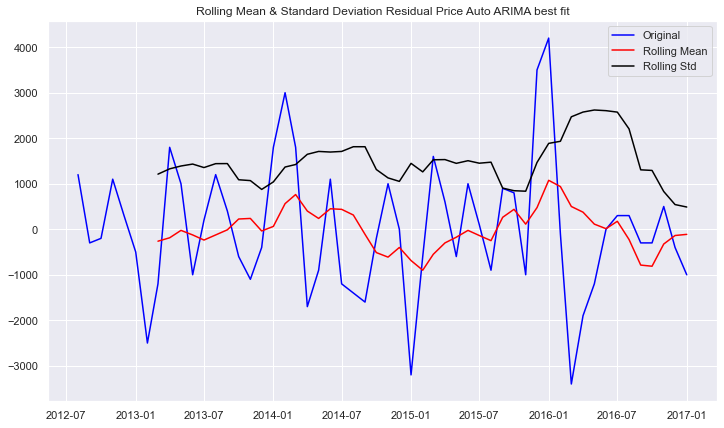

Results of the Dickey-Fuller Test: 

Test Statistic           -3.448310
p-value                   0.009418
#lags Used               11.000000
Number of Observation    42.000000
Critical Value (1%)      -3.596636
Critical Value (5%)      -2.933297
Critical Value (10%)     -2.604991
dtype: float64
None


In [44]:
train['residual_price_auto'] = residuals_auto
print(train.residual_price_auto.mean())
print(train.residual_price_auto.var())
print(stationarity_check(train.residual_price_auto, 'Residual Price Auto ARIMA best fit'))
plot_acf(train.residual_price_auto, zero=False, lags=40);

In [45]:
train, test = train_test(df_NJ_HudsonZC[3][start:]['value'])

In [108]:
train.values

array([235800., 236400., 238200., 239700., 241000., 243400., 246100.,
       248300., 248000., 246500., 246800., 248100., 248400., 248900.,
       250600., 252700., 254200., 254600., 254600., 256400., 261200.,
       267800., 272700., 276700., 281800., 285700., 288200., 289100.,
       289800., 291500., 293200., 291700., 289600., 289100., 289200.,
       288700., 289200., 289800., 289500., 290100., 291500., 291900.,
       295800., 303900., 311900., 316500., 319200., 320700., 322200.,
       324000., 326100., 327900., 329400., 331400., 333000., 333600.])

In [109]:
results = auto_arima(train, start_p=9, d=2, start_q=3, max_p=11, max_q=5,
                     start_P=0, start_Q=0, max_P=5, max_Q=5,m=12, seasonal=True,
                     error_action='warn',trace=True,supress_warnings=True,stepwise=True,
                     random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(9,2,3)(0,0,0)[12]             : AIC=944.111, Time=0.74 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=941.271, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=944.478, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=945.266, Time=0.06 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=944.121, Time=0.02 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=942.774, Time=0.03 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=945.153, Time=0.14 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=943.062, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=943.908, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=946.083, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=943.271, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 1.237 seconds


In [110]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   56
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -469.636
Date:                Sun, 25 Apr 2021   AIC                            941.271
Time:                        21:19:01   BIC                            943.260
Sample:                             0   HQIC                           942.038
                                 - 56                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.094e+06   3.37e+05      6.207      0.000    1.43e+06    2.76e+06
===================================================================================
Ljung-Box (Q):                      102.63   Jarque-Bera (JB):                 2.74
Prob(Q):                              0.00   Prob(JB):                         0.25
Heteroskedasticity (H):               2.27   Skew:                             0.35
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
ps=datetime(2017,6,1)
pe=datetime(2018,1,1)
train, test, results = model_fit_SARIMAX_year(df_NJ_HudsonZC[3][start:]['value'], pdq=pdq, PDQS=PDQS)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   56
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -469.636
Date:                Sun, 25 Apr 2021   AIC                            941.271
Time:                        23:38:38   BIC                            943.260
Sample:                    06-01-2012   HQIC                           942.038
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.094e+06   3.37e+05      6.207      0.000    1.43e+06    2.76e+06
Ljung-Box (Q):                      102.63   Jarque-Bera (JB):                 2.74
Prob(Q):                              0.00   Pr

ARIMA model RMSE on train data: 1500.81610
ARIMA model RMSE on test data: 34914.64592


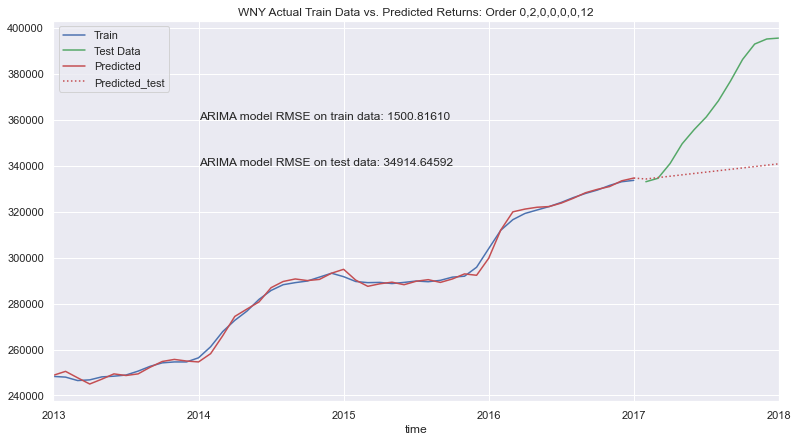

In [47]:
pred_start = datetime(2013,1,1)
pred_end = datetime(2017,1,1)
test_start = datetime(2017,1,1)
test_end = datetime(2018,1,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

fig= plt.figure(figsize=(13,7))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')
plt.text('2014',360000,f'ARIMA model RMSE on train data: %.5f' % rmse)
plt.text('2014',340000,f'ARIMA model RMSE on test data: %.5f' % rmse_test)
plt.legend(loc='best')
plt.title('WNY Actual Train Data vs. Predicted Returns: Order 0,2,0,0,0,0,12')
fig.savefig('Order0_2_0_0_0_0_12', bbox_inches='tight', dpi=150)
plt.show()

In order to streamline the process I will perform an auto_arima to find the best fit model. Usually, it's recommend to do this before going into an in-depth search for more complicated model but I wanted to explore these models first. 

In [24]:
train, test = train_test_6m(df_NJ_HudsonZC[3][start:]['value'],datetime(2017,6,1),datetime(2018,1,1))

In [25]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1043.847, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1041.040, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1044.496, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1045.806, Time=0.04 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1044.589, Time=0.04 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1046.153, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1043.070, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1044.460, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1046.593, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1042.836, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.563 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   61
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -519.520
Date:                Sun, 25 Apr 2021   AIC                           1041.040
Time:                        23:53:18   BIC                           1043.118
Sample:                    06-01-2012   HQIC                          1041.851
                         - 06-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.602e+06   3.96e+05      6.566      0.000    1.83e+06    3.38e+06
Ljung-Box (Q):                      117.08   Jarque-Bera (JB):                 4.55
Prob(Q):                              0.00   Pr

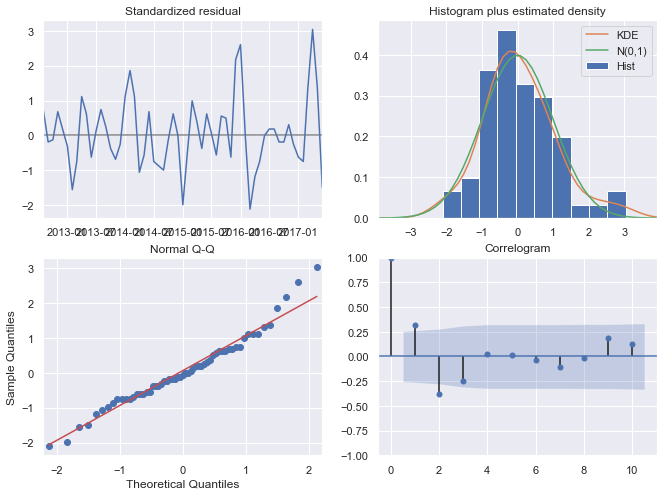

In [26]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
ps=datetime(2017,6,1)
pe=datetime(2018,1,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[3][start:]['value'], pdq=pdq, PDQS=PDQS)

In [27]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2017,6,1)
test_start = datetime(2017,6,1)
test_end = datetime(2018,1,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

fig = plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')
plt.text('2015',360000,f'ARIMA model RMSE on train data: %.5f' % rmse)
plt.text('2015',340000,f'ARIMA model RMSE on test data: %.5f' % rmse_test)
plt.legend(loc='best')
plt.title('WNY Actual Train Data vs. Predicted Returns: Order 0,2,0,0,0,0,12')
fig.savefig('Order0_2_0_0_0_0_12_6months', bbox_inches='tight', dpi=150)
plt.show()

ARIMA model RMSE on train data: 1788.05561
ARIMA model RMSE on test data: 3693.23706


In [52]:
train, test = train_test_6m(df_NJ_HudsonZC[3][start:]['value'],datetime(2017,12,1),datetime(2018,4,1))

In [53]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1156.760, Time=0.24 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1153.220, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1157.043, Time=0.12 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1155.751, Time=0.04 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=inf, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1155.568, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1157.453, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1156.908, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1155.206, Time=0.02 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.916 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   67
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -575.610
Date:                Sun, 25 Apr 2021   AIC                           1153.220
Time:                        23:40:43   BIC                           1155.394
Sample:                    06-01-2012   HQIC                          1154.078
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.877e+06   4.27e+05      6.741      0.000    2.04e+06    3.71e+06
Ljung-Box (Q):                      100.90   Jarque-Bera (JB):                 2.08
Prob(Q):                              0.00   Pr

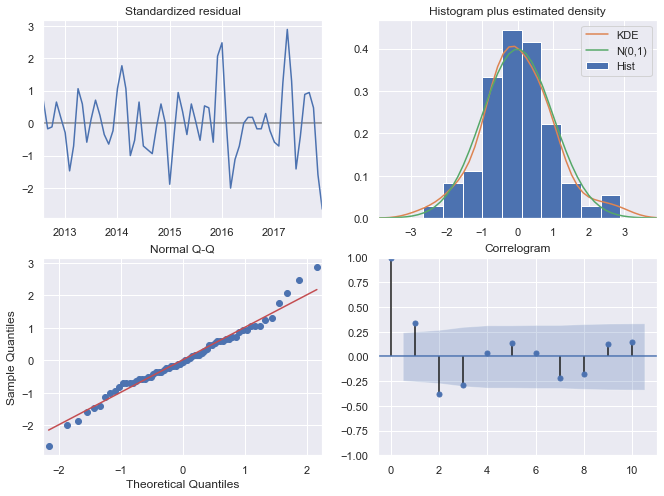

In [54]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
ps=datetime(2017,12,1)
pe=datetime(2018,4,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[3][start:]['value'], pdq=pdq, PDQS=PDQS, ps=ps, pe=pe)

In [55]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2017,12,1)
test_start = datetime(2017,12,1)
test_end = datetime(2018,4,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')
plt.text('2015',360000,f'ARIMA model RMSE on train data: %.5f' % rmse)
plt.text('2015',340000,f'ARIMA model RMSE on test data: %.5f' % rmse_test)
plt.legend(loc='best')
plt.title('WNY Actual Train Data vs. Predicted Returns: Order 0,2,0,0,0,0,12')
fig.savefig('Order0_2_0_0_0_0_12_6months_last', bbox_inches='tight', dpi=150)
plt.show()

ARIMA model RMSE on train data: 1869.49191
ARIMA model RMSE on test data: 5214.88255


In [56]:
train, test = train_test_6m(df_NJ_HudsonZC[3][start:]['value'],datetime(2018,3,1),datetime(2018,4,1))

In [57]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1216.366, Time=0.57 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1213.136, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1217.243, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1218.668, Time=0.06 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1214.910, Time=0.05 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1219.690, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1215.693, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1217.164, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1214.909, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.965 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [58]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
ps=datetime(2018,3,1)
pe=datetime(2018,4,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[3][start:]['value'], pdq=pdq, PDQS=PDQS, ps=ps, pe=pe)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   70
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -605.568
Date:                Sun, 25 Apr 2021   AIC                           1213.136
Time:                        23:40:52   BIC                           1215.356
Sample:                    06-01-2012   HQIC                          1214.015
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.179e+06    4.9e+05      6.491      0.000    2.22e+06    4.14e+06
Ljung-Box (Q):                       85.74   Jarque-Bera (JB):                 1.23
Prob(Q):                              0.00   Pr

ARIMA model RMSE on train data: 1965.08744


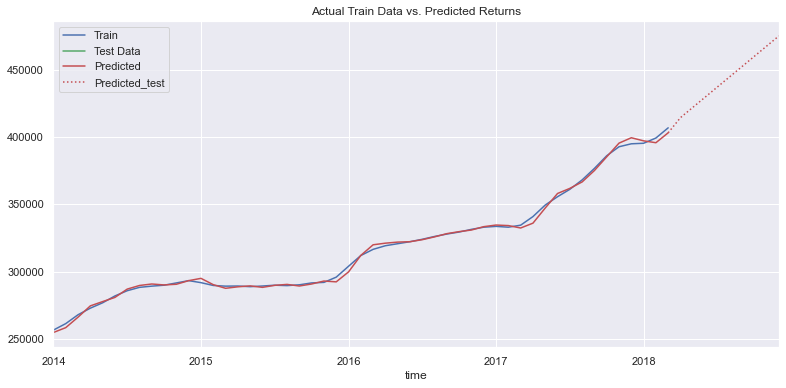

In [59]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2018,3,1)
test_start = datetime(2018,3,1)
test_end = datetime(2018,12,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
#rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
#print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')
plt.legend(loc='best')
plt.title('Actual Train Data vs. Predicted Returns')
plt.show()

In [38]:
list_RegionName = []
list_zip = NJ_HUDSON_zd.RegionName.unique().tolist()
for i in range(len(list_zip)):
    RegionName = NJ_Hudson_zd.loc[NJ_Hudson_zd.RegionName == list_zip[i]].City
    list_RegionName.append(RegionName.reset_index(drop=True)[0])

In [39]:
Hudson_county_data = {'RegionName': list_RegionName, 'Zip': list_zip}
df_hudson_county = pd.DataFrame(Hudson_county_data)
df_hudson_county

RegionName   Zip
0         Hoboken  7030
1         Bayonne  7002
2     Jersey City  7302
3   West New York  7093
4      Union City  7087
5     Jersey City  7305
6    North Bergen  7047
7     Jersey City  7306
8     Jersey City  7307
9          Kearny  7032
10       Secaucus  7094
11      Weehawken  7086
12       Harrison  7029

In [41]:
df_hudson_county['ROI'] = 'roi'

# Deployment of Model

# West New York 07093 Home Value Analysis: Time Series

In [35]:
train, test = train_test_6m(df_NJ_HudsonZC[3][start:]['value'],datetime(2018,2,1),datetime(2018,4,1))

In [29]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1195.633, Time=0.36 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1191.938, Time=0.12 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1195.646, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1194.359, Time=0.05 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=inf, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1194.142, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1195.445, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1195.581, Time=0.24 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1193.885, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 1.102 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [30]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
ps=datetime(2018,2,1)
pe=datetime(2018,4,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[3][start:]['value'], pdq=pdq, PDQS=PDQS, ps=ps, pe=pe)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   69
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -594.969
Date:                Sun, 25 Apr 2021   AIC                           1191.938
Time:                        23:54:51   BIC                           1194.143
Sample:                    06-01-2012   HQIC                          1192.811
                         - 02-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.022e+06   4.58e+05      6.599      0.000    2.12e+06    3.92e+06
Ljung-Box (Q):                       94.88   Jarque-Bera (JB):                 1.54
Prob(Q):                              0.00   Pr

ARIMA model RMSE on train data: 1914.41897
ARIMA model RMSE on test data: 4687.21666


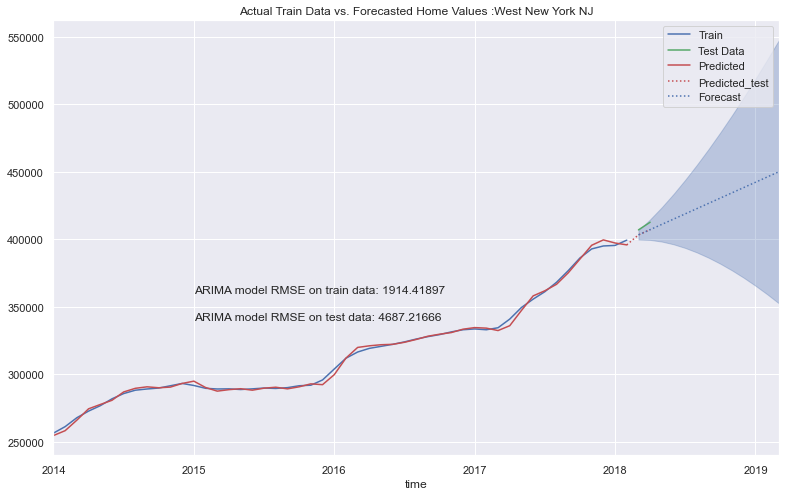

In [33]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2018,2,1)
test_start = datetime(2018,2,1)
test_end = datetime(2018,4,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

fig= plt.figure(figsize=(13,8))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')

forecast = results.get_forecast(steps = 13).predicted_mean
forecast.plot(label='Forecast',color='b',ls=':')
forecast_conf= results.get_forecast(steps = 13).conf_int(alpha=0.05)

plt.fill_between(forecast_conf.index,
                forecast_conf.iloc[:, 0],
                forecast_conf.iloc[:, 1], color='b', alpha=.3)
plt.text('2015',360000,f'ARIMA model RMSE on train data: %.5f' % rmse)
plt.text('2015',340000,f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.legend(loc='best')
plt.title('Actual Train Data vs. Forecasted Home Values :West New York NJ')
fig.savefig('forecast_WNY', bbox_inches='tight', dpi=150)
plt.show()

In [36]:
roi_3 = ((forecast[-4] - train_pred[-2])/ train_pred[-2])*100
roi_3

10.344827586206897

In [42]:
df_hudson_county['ROI'][3] = roi_3
df_hudson_county

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


RegionName   Zip      ROI
0         Hoboken  7030      roi
1         Bayonne  7002      roi
2     Jersey City  7302      roi
3   West New York  7093  10.3448
4      Union City  7087      roi
5     Jersey City  7305      roi
6    North Bergen  7047      roi
7     Jersey City  7306      roi
8     Jersey City  7307      roi
9          Kearny  7032      roi
10       Secaucus  7094      roi
11      Weehawken  7086      roi
12       Harrison  7029      roi

# Union City 07087 Home Value Analysis: Time Series

In [43]:
df_NJ_HudsonZC[4]

RegionName        City     value
time                                        
1996-04-01        7087  Union City  127300.0
1996-05-01        7087  Union City  127000.0
1996-06-01        7087  Union City  126700.0
1996-07-01        7087  Union City  126400.0
1996-08-01        7087  Union City  126100.0
...                ...         ...       ...
2017-12-01        7087  Union City  410500.0
2018-01-01        7087  Union City  415500.0
2018-02-01        7087  Union City  424000.0
2018-03-01        7087  Union City  437400.0
2018-04-01        7087  Union City  448900.0

[265 rows x 3 columns]

In [44]:
train, test = train_test_6m(df_NJ_HudsonZC[4][start:]['value'],datetime(2017,6,1),datetime(2018,1,1))

In [45]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1069.693, Time=0.52 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1067.237, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1074.179, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1073.214, Time=0.06 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1084.124, Time=0.03 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1068.967, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1072.415, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1071.459, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1070.435, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1068.935, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 1.071 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [46]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
ps=datetime(2017,6,1)
pe=datetime(2018,1,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[4][start:]['value'], pdq=pdq, PDQS=PDQS)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   61
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -532.618
Date:                Mon, 26 Apr 2021   AIC                           1067.237
Time:                        22:04:54   BIC                           1069.314
Sample:                    06-01-2012   HQIC                          1068.048
                         - 06-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.057e+06   7.31e+05      5.548      0.000    2.62e+06    5.49e+06
Ljung-Box (Q):                      235.76   Jarque-Bera (JB):                 0.64
Prob(Q):                              0.00   Pr

ARIMA model RMSE on train data: 1761.89833
ARIMA model RMSE on test data: 9164.06024


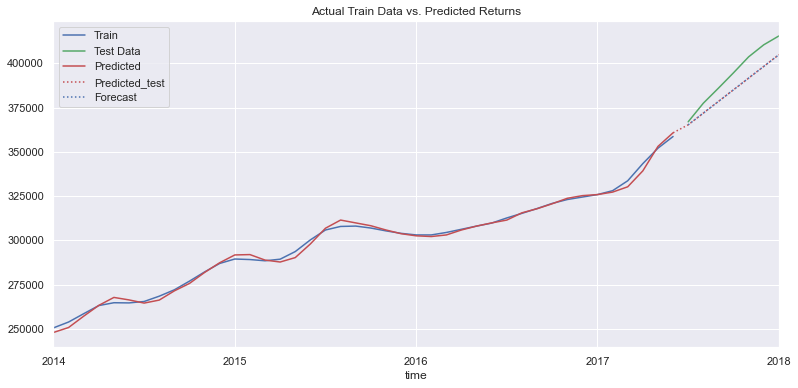

In [47]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2017,6,1)
test_start = datetime(2017,6,1)
test_end = datetime(2018,1,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')
results.forecast(steps = 7).plot(label='Forecast',color='b',ls=':')
plt.legend(loc='best')
plt.title('Actual Train Data vs. Predicted Returns')
plt.show()

In [48]:
train, test = train_test_6m(df_NJ_HudsonZC[4][start:]['value'],datetime(2017,12,1),datetime(2018,4,1))

In [49]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1176.390, Time=0.51 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1173.650, Time=0.22 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1179.236, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1180.316, Time=0.05 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1187.508, Time=0.05 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1188.527, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1177.489, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1178.564, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1181.041, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1175.354, Time=0.02 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 1.122 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [50]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
ps=datetime(2017,12,1)
pe=datetime(2018,4,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[4][start:]['value'], pdq=pdq, PDQS=PDQS, ps=ps, pe=pe)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   67
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -585.825
Date:                Mon, 26 Apr 2021   AIC                           1173.650
Time:                        22:05:07   BIC                           1175.825
Sample:                    06-01-2012   HQIC                          1174.508
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       3.94e+06   6.84e+05      5.760      0.000     2.6e+06    5.28e+06
Ljung-Box (Q):                      186.90   Jarque-Bera (JB):                 0.63
Prob(Q):                              0.00   Pr

In [51]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2017,12,1)
test_start = datetime(2017,12,1)
test_end = datetime(2018,4,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')

forecast = results.get_forecast(steps = 13).predicted_mean
forecast.plot(label='Forecast',color='b',ls=':')
forecast_conf= results.get_forecast(steps = 13).conf_int(alpha=0.05)

plt.fill_between(forecast_conf.index,
                forecast_conf.iloc[:, 0],
                forecast_conf.iloc[:, 1], color='b', alpha=.3)

plt.legend(loc='best')
plt.title('Actual Train Data vs. Forecasted Home Values :Union City 07087')
plt.show()

ARIMA model RMSE on train data: 1750.47613
ARIMA model RMSE on test data: 6537.20124


In [52]:
roi_4 = ((forecast[-1] - forecast[0])/ forecast[0])*100
roi_4

19.554277498202733

In [53]:
df_hudson_county['ROI'][4] = roi_4
df_hudson_county

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


RegionName   Zip      ROI
0         Hoboken  7030      roi
1         Bayonne  7002      roi
2     Jersey City  7302      roi
3   West New York  7093  10.3448
4      Union City  7087  19.5543
5     Jersey City  7305      roi
6    North Bergen  7047      roi
7     Jersey City  7306      roi
8     Jersey City  7307      roi
9          Kearny  7032      roi
10       Secaucus  7094      roi
11      Weehawken  7086      roi
12       Harrison  7029      roi

# Jersey City 07305 Home Value Analysis: Time Series

In [54]:
df_NJ_HudsonZC[5]

RegionName         City     value
time                                         
1996-04-01        7305  Jersey City  105200.0
1996-05-01        7305  Jersey City  104500.0
1996-06-01        7305  Jersey City  103800.0
1996-07-01        7305  Jersey City  103100.0
1996-08-01        7305  Jersey City  102600.0
...                ...          ...       ...
2017-12-01        7305  Jersey City  261600.0
2018-01-01        7305  Jersey City  268600.0
2018-02-01        7305  Jersey City  276000.0
2018-03-01        7305  Jersey City  286700.0
2018-04-01        7305  Jersey City  295100.0

[265 rows x 3 columns]

In [55]:
train, test = train_test_6m(df_NJ_HudsonZC[5][start:]['value'],datetime(2017,6,1),datetime(2018,1,1))

In [56]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1000.474, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=999.837, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=999.188, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=999.965, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1001.329, Time=0.02 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=1000.836, Time=0.13 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=1001.055, Time=0.24 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=999.132, Time=0.09 sec
 ARIMA(1,2,0)(0,0,2)[12]             : AIC=1000.927, Time=0.16 sec
 ARIMA(1,2,0)(1,0,2)[12]             : AIC=1001.609, Time=0.74 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=998.178, Time=0.06 sec
 ARIMA(0,2,0)(0,0,2)[12]             : AIC=1000.042, Time=0.07 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=998.215, Time=0.05 sec
 ARIMA(0,2,0)(1,0,2)[12]             : AIC=1000.867, Time=0.42 sec
 ARIMA(1,2,1)(0,0,1)[12] 

ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [57]:
pdq = (0,2,0)
PDQS = (0,0,1,12)
ps=datetime(2017,6,1)
pe=datetime(2018,1,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[5][start:]['value'], pdq=pdq, PDQS=PDQS)

                                      SARIMAX Results                                       
Dep. Variable:                                value   No. Observations:                   61
Model:             SARIMAX(0, 2, 0)x(0, 0, [1], 12)   Log Likelihood                -497.089
Date:                              Mon, 26 Apr 2021   AIC                            998.178
Time:                                      22:05:30   BIC                           1002.333
Sample:                                  06-01-2012   HQIC                           999.800
                                       - 06-01-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.0269      0.009     -2.990      0.003      -0.045      -0.009
sigma2      1.115e+

In [58]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2017,6,1)
test_start = datetime(2017,6,1)
test_end = datetime(2018,1,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')
results.forecast(steps = 7).plot(label='Forecast',color='b',ls=':')
plt.legend(loc='best')
plt.title('Actual Train Data vs. Predicted Returns')
plt.show()

ARIMA model RMSE on train data: 1055.40063
ARIMA model RMSE on test data: 9815.57435


In [59]:
train, test = train_test_6m(df_NJ_HudsonZC[5][start:]['value'],datetime(2017,12,1),datetime(2018,4,1))

In [60]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1113.155, Time=0.26 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1111.818, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1112.552, Time=0.09 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1115.505, Time=0.06 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1110.928, Time=0.13 sec
 ARIMA(0,2,0)(2,0,0)[12]             : AIC=1112.788, Time=0.07 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1111.782, Time=0.04 sec
 ARIMA(0,2,0)(2,0,1)[12]             : AIC=1114.278, Time=0.46 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1115.565, Time=0.05 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(0,2,0)(1,0,0)[12] intercept   : AIC=1111.560, Time=0.18 sec

Best model:  ARIMA(0,2,0)(1,0,0)[12]          
Total fit time: 1.645 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(1, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [61]:
pdq = (0,2,0)
PDQS = (1,0,0,12)
ps=datetime(2017,12,1)
pe=datetime(2018,4,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[5][start:]['value'], pdq=pdq, PDQS=PDQS, ps=ps, pe=pe)

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                   67
Model:             SARIMAX(0, 2, 0)x(1, 0, 0, 12)   Log Likelihood                -553.464
Date:                            Mon, 26 Apr 2021   AIC                           1110.928
Time:                                    22:05:34   BIC                           1115.276
Sample:                                06-01-2012   HQIC                          1112.644
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0223      0.009     -2.490      0.013      -0.040      -0.005
sigma2      1.403e+06   2.23e+05   

ARIMA model RMSE on train data: 1201.53814
ARIMA model RMSE on test data: 6475.79028


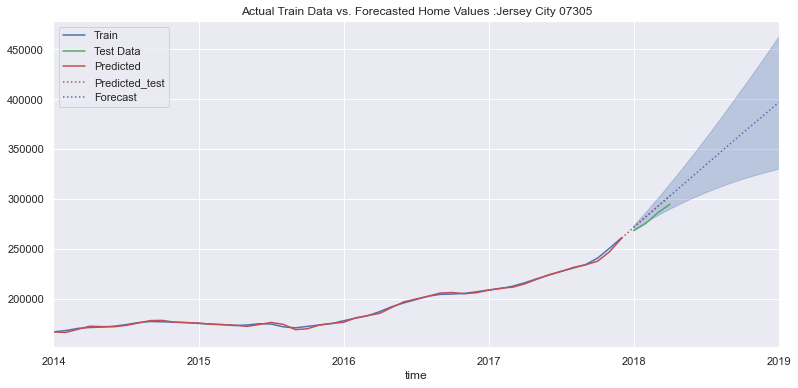

In [62]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2017,12,1)
test_start = datetime(2017,12,1)
test_end = datetime(2018,4,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')

forecast = results.get_forecast(steps = 13).predicted_mean
forecast.plot(label='Forecast',color='b',ls=':')
forecast_conf= results.get_forecast(steps = 13).conf_int(alpha=0.05)

plt.fill_between(forecast_conf.index,
                forecast_conf.iloc[:, 0],
                forecast_conf.iloc[:, 1], color='b', alpha=.3)

plt.legend(loc='best')
plt.title('Actual Train Data vs. Forecasted Home Values :Jersey City 07305')
plt.show()

In [63]:
roi_5 = ((forecast[-1] - forecast[0])/ forecast[0])*100
roi_5

45.95070195837558

In [64]:
df_hudson_county['ROI'][5] = roi_5
df_hudson_county

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


RegionName   Zip      ROI
0         Hoboken  7030      roi
1         Bayonne  7002      roi
2     Jersey City  7302      roi
3   West New York  7093  10.3448
4      Union City  7087  19.5543
5     Jersey City  7305  45.9507
6    North Bergen  7047      roi
7     Jersey City  7306      roi
8     Jersey City  7307      roi
9          Kearny  7032      roi
10       Secaucus  7094      roi
11      Weehawken  7086      roi
12       Harrison  7029      roi

# North Bergen 07047 Home Value Analysis: Time Series

In [65]:
df_NJ_HudsonZC[6]

RegionName          City     value
time                                          
1996-04-01        7047  North Bergen  147200.0
1996-05-01        7047  North Bergen  146800.0
1996-06-01        7047  North Bergen  146400.0
1996-07-01        7047  North Bergen  146000.0
1996-08-01        7047  North Bergen  145800.0
...                ...           ...       ...
2017-12-01        7047  North Bergen  389900.0
2018-01-01        7047  North Bergen  391200.0
2018-02-01        7047  North Bergen  396500.0
2018-03-01        7047  North Bergen  409200.0
2018-04-01        7047  North Bergen  419100.0

[265 rows x 3 columns]

In [66]:
train, test = train_test_6m(df_NJ_HudsonZC[6][start:]['value'],datetime(2017,6,1),datetime(2018,1,1))

In [67]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1042.943, Time=0.15 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1038.954, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1041.453, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1042.352, Time=0.04 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1041.333, Time=0.04 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1041.319, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1039.458, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1040.355, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1040.631, Time=0.15 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1040.953, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.619 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   61
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -518.477
Date:                Mon, 26 Apr 2021   AIC                           1038.954
Time:                        22:06:22   BIC                           1041.032
Sample:                    06-01-2012   HQIC                          1039.765
                         - 06-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.512e+06   5.67e+05      4.430      0.000     1.4e+06    3.62e+06
Ljung-Box (Q):                       91.18   Jarque-Bera (JB):                 1.87
Prob(Q):                              0.00   Pr

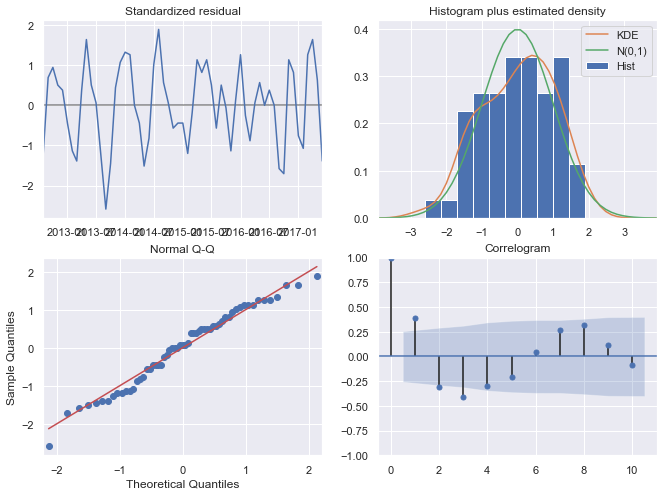

In [68]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
ps=datetime(2017,6,1)
pe=datetime(2018,1,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[6][start:]['value'], pdq=pdq, PDQS=PDQS)

ARIMA model RMSE on train data: 1499.76189
ARIMA model RMSE on test data: 5862.71512


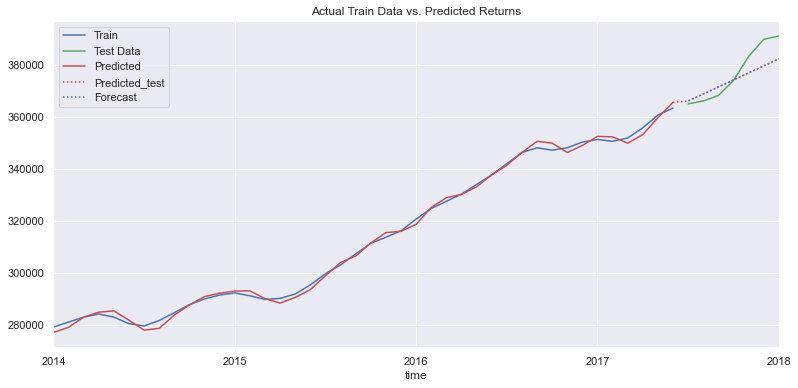

In [69]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2017,6,1)
test_start = datetime(2017,6,1)
test_end = datetime(2018,1,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')
results.forecast(steps = 7).plot(label='Forecast',color='b',ls=':')
plt.legend(loc='best')
plt.title('Actual Train Data vs. Predicted Returns')
plt.show()

In [70]:
train, test = train_test_6m(df_NJ_HudsonZC[6][start:]['value'],datetime(2017,12,1),datetime(2018,4,1))

In [71]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1154.970, Time=0.24 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1151.691, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1154.271, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1154.611, Time=0.04 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1154.035, Time=0.05 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1153.873, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1152.273, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1152.613, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1154.534, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1153.590, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.590 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   67
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -574.846
Date:                Mon, 26 Apr 2021   AIC                           1151.691
Time:                        22:06:39   BIC                           1153.866
Sample:                    06-01-2012   HQIC                          1152.549
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       2.81e+06   5.87e+05      4.785      0.000    1.66e+06    3.96e+06
Ljung-Box (Q):                       91.02   Jarque-Bera (JB):                 1.00
Prob(Q):                              0.00   Pr

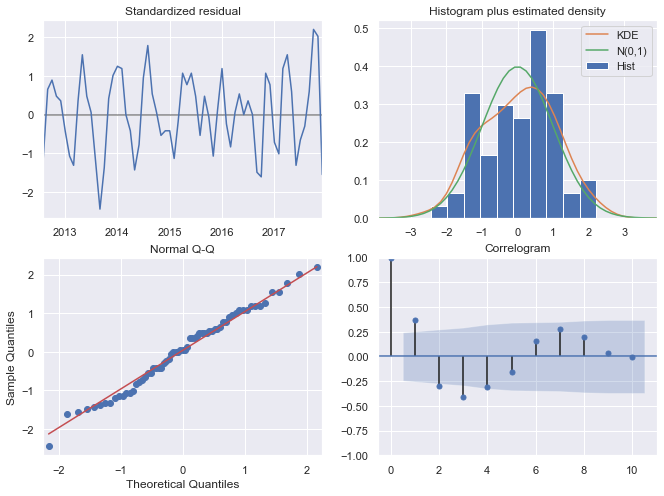

In [72]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
ps=datetime(2017,12,1)
pe=datetime(2018,4,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[6][start:]['value'], pdq=pdq, PDQS=PDQS, ps=ps, pe=pe)

ARIMA model RMSE on train data: 1638.97834
ARIMA model RMSE on test data: 4464.86282


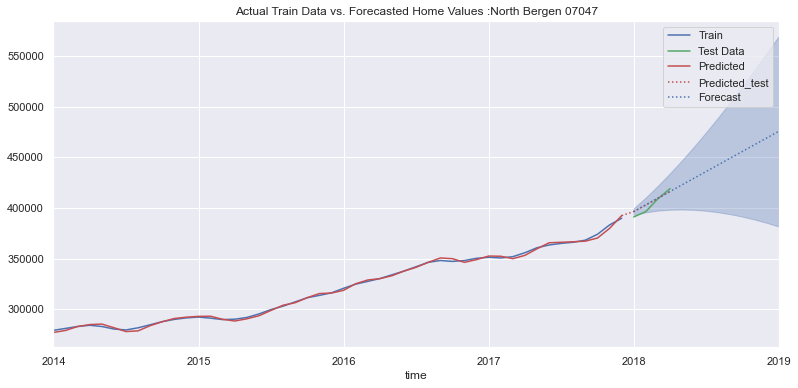

In [73]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2017,12,1)
test_start = datetime(2017,12,1)
test_end = datetime(2018,4,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')

forecast = results.get_forecast(steps = 13).predicted_mean
forecast.plot(label='Forecast',color='b',ls=':')
forecast_conf= results.get_forecast(steps = 13).conf_int(alpha=0.05)

plt.fill_between(forecast_conf.index,
                forecast_conf.iloc[:, 0],
                forecast_conf.iloc[:, 1], color='b', alpha=.3)

plt.legend(loc='best')
plt.title('Actual Train Data vs. Forecasted Home Values :North Bergen 07047')
plt.show()

In [74]:
roi_6 = ((forecast[-1] - forecast[0])/ forecast[0])*100
roi_6

19.974779319041613

In [75]:
df_hudson_county['ROI'][6] = roi_6
df_hudson_county

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


RegionName   Zip      ROI
0         Hoboken  7030      roi
1         Bayonne  7002      roi
2     Jersey City  7302      roi
3   West New York  7093  10.3448
4      Union City  7087  19.5543
5     Jersey City  7305  45.9507
6    North Bergen  7047  19.9748
7     Jersey City  7306      roi
8     Jersey City  7307      roi
9          Kearny  7032      roi
10       Secaucus  7094      roi
11      Weehawken  7086      roi
12       Harrison  7029      roi

# Jersey City 07307 Home Value Analysis: Time Series

In [76]:
df_NJ_HudsonZC[7]

RegionName         City     value
time                                         
1996-04-01        7306  Jersey City  111400.0
1996-05-01        7306  Jersey City  111100.0
1996-06-01        7306  Jersey City  110900.0
1996-07-01        7306  Jersey City  110600.0
1996-08-01        7306  Jersey City  110300.0
...                ...          ...       ...
2017-12-01        7306  Jersey City  506700.0
2018-01-01        7306  Jersey City  510000.0
2018-02-01        7306  Jersey City  515300.0
2018-03-01        7306  Jersey City  531900.0
2018-04-01        7306  Jersey City  545500.0

[265 rows x 3 columns]

In [77]:
train, test = train_test_6m(df_NJ_HudsonZC[7][start:]['value'],datetime(2017,6,1),datetime(2018,1,1))

In [78]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1051.278, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1047.492, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1051.670, Time=0.09 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1052.912, Time=0.05 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1049.451, Time=0.02 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1049.305, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1049.888, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1051.144, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1053.343, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1048.729, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.507 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [79]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
ps=datetime(2017,6,1)
pe=datetime(2018,1,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[7][start:]['value'], pdq=pdq, PDQS=PDQS)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   61
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -522.746
Date:                Mon, 26 Apr 2021   AIC                           1047.492
Time:                        22:07:05   BIC                           1049.569
Sample:                    06-01-2012   HQIC                          1048.303
                         - 06-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.903e+06   5.88e+05      4.938      0.000    1.75e+06    4.06e+06
Ljung-Box (Q):                       50.18   Jarque-Bera (JB):                 0.32
Prob(Q):                              0.13   Pr

In [80]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2017,6,1)
test_start = datetime(2017,6,1)
test_end = datetime(2018,1,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')
results.forecast(steps = 7).plot(label='Forecast',color='b',ls=':')
plt.legend(loc='best')
plt.title('Actual Train Data vs. Predicted Returns')
plt.show()

ARIMA model RMSE on train data: 1573.21327
ARIMA model RMSE on test data: 15988.03124


In [81]:
train, test = train_test_6m(df_NJ_HudsonZC[7][start:]['value'],datetime(2017,12,1),datetime(2018,4,1))

In [82]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1165.891, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1161.954, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1166.258, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1166.636, Time=0.05 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1163.857, Time=0.04 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1164.552, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1164.412, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1164.793, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1166.682, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1163.344, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.364 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [83]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
ps=datetime(2017,12,1)
pe=datetime(2018,4,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[7][start:]['value'], pdq=pdq, PDQS=PDQS, ps=ps, pe=pe)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   67
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -579.977
Date:                Mon, 26 Apr 2021   AIC                           1161.954
Time:                        22:07:18   BIC                           1164.128
Sample:                    06-01-2012   HQIC                          1162.812
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.291e+06   6.66e+05      4.943      0.000    1.99e+06     4.6e+06
Ljung-Box (Q):                       50.65   Jarque-Bera (JB):                 0.67
Prob(Q):                              0.12   Pr

In [84]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2017,12,1)
test_start = datetime(2017,12,1)
test_end = datetime(2018,4,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')

forecast = results.get_forecast(steps = 13).predicted_mean
forecast.plot(label='Forecast',color='b',ls=':')
forecast_conf= results.get_forecast(steps = 13).conf_int(alpha=0.05)

plt.fill_between(forecast_conf.index,
                forecast_conf.iloc[:, 0],
                forecast_conf.iloc[:, 1], color='b', alpha=.3)

plt.legend(loc='best')
plt.title('Actual Train Data vs. Forecasted Home Values :Jersey City 07307 ')
plt.show()

ARIMA model RMSE on train data: 1747.55782
ARIMA model RMSE on test data: 8821.70618


In [85]:
roi_7 = ((forecast[-1] - forecast[0])/ forecast[0])*100
roi_7

25.270479134466772

In [86]:
df_hudson_county['ROI'][7] = roi_7
df_hudson_county

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


RegionName   Zip      ROI
0         Hoboken  7030      roi
1         Bayonne  7002      roi
2     Jersey City  7302      roi
3   West New York  7093  10.3448
4      Union City  7087  19.5543
5     Jersey City  7305  45.9507
6    North Bergen  7047  19.9748
7     Jersey City  7306  25.2705
8     Jersey City  7307      roi
9          Kearny  7032      roi
10       Secaucus  7094      roi
11      Weehawken  7086      roi
12       Harrison  7029      roi

# Jersey City 07307 Home Value Analysis: Time Series

In [87]:
df_NJ_HudsonZC[8].head()

RegionName         City     value
time                                         
1996-04-01        7307  Jersey City  114300.0
1996-05-01        7307  Jersey City  114300.0
1996-06-01        7307  Jersey City  114400.0
1996-07-01        7307  Jersey City  114500.0
1996-08-01        7307  Jersey City  114800.0

In [88]:
train, test = train_test_6m(df_NJ_HudsonZC[8][start:]['value'],datetime(2017,6,1),datetime(2018,1,1))

In [89]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1062.223, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1061.144, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1062.442, Time=0.03 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1065.202, Time=0.06 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1060.631, Time=0.08 sec
 ARIMA(0,2,0)(2,0,0)[12]             : AIC=1062.282, Time=0.08 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1063.618, Time=0.10 sec
 ARIMA(0,2,0)(2,0,1)[12]             : AIC=1064.074, Time=0.11 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1065.246, Time=0.05 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1068.653, Time=0.11 sec
 ARIMA(0,2,0)(1,0,0)[12] intercept   : AIC=1062.048, Time=0.07 sec

Best model:  ARIMA(0,2,0)(1,0,0)[12]          
Total fit time: 0.865 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(1, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                   61
Model:             SARIMAX(0, 2, 0)x(1, 0, 0, 12)   Log Likelihood                -528.316
Date:                            Mon, 26 Apr 2021   AIC                           1060.631
Time:                                    22:07:36   BIC                           1064.786
Sample:                                06-01-2012   HQIC                          1062.253
                                     - 06-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0157      0.036      0.442      0.659      -0.054       0.086
sigma2      3.524e+06   5.91e+05   

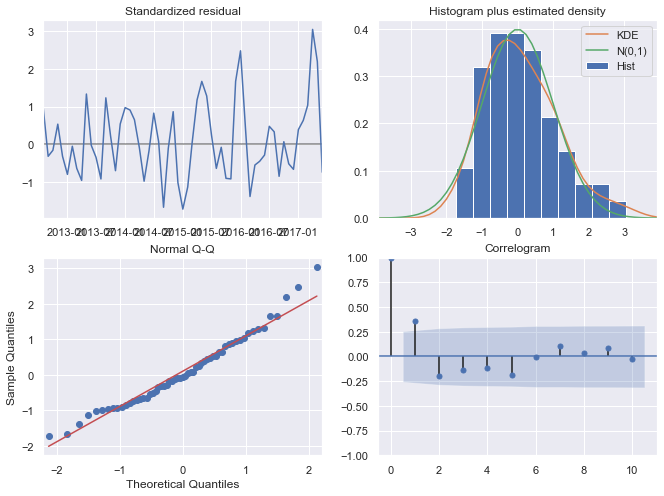

In [90]:
pdq = (0,2,0)
PDQS = (1,0,0,12)
ps=datetime(2017,6,1)
pe=datetime(2018,1,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[8][start:]['value'], pdq=pdq, PDQS=PDQS)

In [91]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2017,6,1)
test_start = datetime(2017,6,1)
test_end = datetime(2018,1,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')
results.forecast(steps = 7).plot(label='Forecast',color='b',ls=':')
plt.legend(loc='best')
plt.title('Actual Train Data vs. Predicted Returns')
plt.show()

ARIMA model RMSE on train data: 2053.90892
ARIMA model RMSE on test data: 16875.73264


In [92]:
train, test = train_test_6m(df_NJ_HudsonZC[8][start:]['value'],datetime(2017,12,1),datetime(2018,4,1))

In [93]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1165.921, Time=0.24 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1165.553, Time=0.10 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1166.936, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1169.874, Time=0.07 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1164.943, Time=0.10 sec
 ARIMA(0,2,0)(2,0,0)[12]             : AIC=1166.588, Time=0.08 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1166.629, Time=0.03 sec
 ARIMA(0,2,0)(2,0,1)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1169.921, Time=0.04 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1172.237, Time=0.34 sec
 ARIMA(0,2,0)(1,0,0)[12] intercept   : AIC=1166.764, Time=0.09 sec

Best model:  ARIMA(0,2,0)(1,0,0)[12]          
Total fit time: 1.845 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(1, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

                                      SARIMAX Results                                       
Dep. Variable:                                value   No. Observations:                   67
Model:             SARIMAX(0, 2, 0)x(0, 0, [1], 12)   Log Likelihood                -581.315
Date:                              Mon, 26 Apr 2021   AIC                           1166.629
Time:                                      22:07:44   BIC                           1170.978
Sample:                                  06-01-2012   HQIC                          1168.345
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       0.0149      0.040      0.369      0.712      -0.064       0.094
sigma2      4.258e+

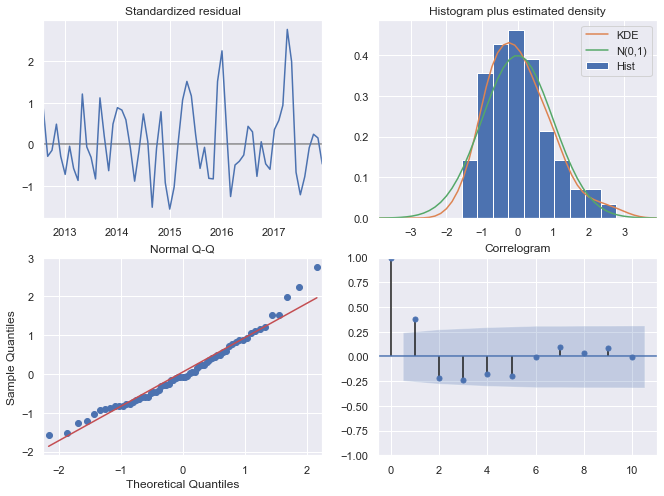

In [94]:
pdq = (0,2,0)
PDQS = (0,0,1,12)
ps=datetime(2017,12,1)
pe=datetime(2018,4,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[8][start:]['value'], pdq=pdq, PDQS=PDQS, ps=ps, pe=pe)

ARIMA model RMSE on train data: 1974.77246
ARIMA model RMSE on test data: 14449.97997


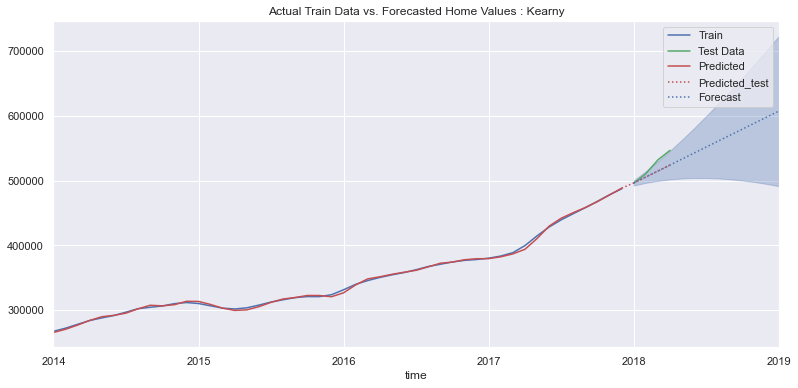

In [95]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2017,12,1)
test_start = datetime(2017,12,1)
test_end = datetime(2018,4,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')

forecast = results.get_forecast(steps = 13).predicted_mean
forecast.plot(label='Forecast',color='b',ls=':')
forecast_conf= results.get_forecast(steps = 13).conf_int(alpha=0.05)

plt.fill_between(forecast_conf.index,
                forecast_conf.iloc[:, 0],
                forecast_conf.iloc[:, 1], color='b', alpha=.3)

plt.legend(loc='best')
plt.title('Actual Train Data vs. Forecasted Home Values : Kearny')
plt.show()

In [96]:
roi_8 = ((forecast[-1] - forecast[0])/ forecast[0])*100
roi_8

22.29894079003706

In [97]:
df_hudson_county['ROI'][8] = roi_8
df_hudson_county

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


RegionName   Zip      ROI
0         Hoboken  7030      roi
1         Bayonne  7002      roi
2     Jersey City  7302      roi
3   West New York  7093  10.3448
4      Union City  7087  19.5543
5     Jersey City  7305  45.9507
6    North Bergen  7047  19.9748
7     Jersey City  7306  25.2705
8     Jersey City  7307  22.2989
9          Kearny  7032      roi
10       Secaucus  7094      roi
11      Weehawken  7086      roi
12       Harrison  7029      roi

# Kearny 07032 Home Value Analysis: Time Series

In [98]:
df_NJ_HudsonZC[9].head()

RegionName    City     value
time                                    
1996-04-01        7032  Kearny  150300.0
1996-05-01        7032  Kearny  150200.0
1996-06-01        7032  Kearny  150100.0
1996-07-01        7032  Kearny  150200.0
1996-08-01        7032  Kearny  150200.0

In [99]:
train, test = train_test_6m(df_NJ_HudsonZC[9][start:]['value'],datetime(2017,6,1),datetime(2018,1,1))

In [100]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1041.645, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1031.899, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1035.018, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1037.788, Time=0.07 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1033.576, Time=0.04 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1040.073, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1033.822, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1036.772, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1038.486, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1033.831, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.507 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [101]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
ps=datetime(2017,6,1)
pe=datetime(2018,1,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[9][start:]['value'], pdq=pdq, PDQS=PDQS)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   61
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -514.950
Date:                Mon, 26 Apr 2021   AIC                           1031.899
Time:                        22:07:59   BIC                           1033.977
Sample:                    06-01-2012   HQIC                          1032.710
                         - 06-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.229e+06    3.4e+05      6.546      0.000    1.56e+06     2.9e+06
Ljung-Box (Q):                       71.14   Jarque-Bera (JB):                 4.54
Prob(Q):                              0.00   Pr

ARIMA model RMSE on train data: 1596.64828
ARIMA model RMSE on test data: 6239.50547


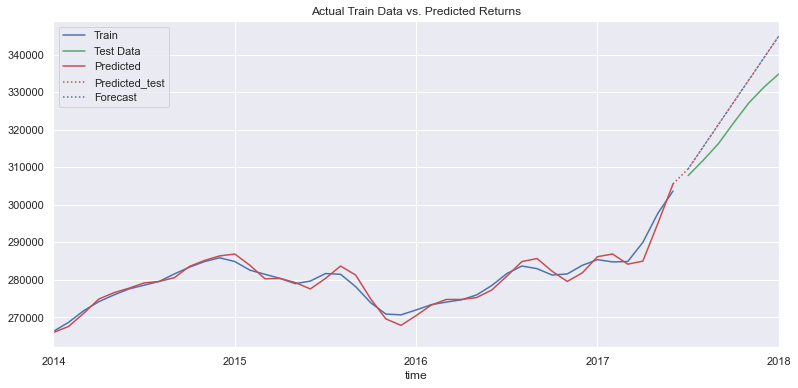

In [102]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2017,6,1)
test_start = datetime(2017,6,1)
test_end = datetime(2018,1,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')
results.forecast(steps = 7).plot(label='Forecast',color='b',ls=':')
plt.legend(loc='best')
plt.title('Actual Train Data vs. Predicted Returns')
plt.show()

In [103]:
train, test = train_test_6m(df_NJ_HudsonZC[9][start:]['value'],datetime(2017,12,1),datetime(2018,4,1))

In [104]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1140.749, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1133.138, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1136.206, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1135.665, Time=0.19 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1134.715, Time=0.03 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1138.765, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1135.117, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1137.410, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1137.090, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1135.125, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.669 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   67
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -565.569
Date:                Mon, 26 Apr 2021   AIC                           1133.138
Time:                        22:08:08   BIC                           1135.312
Sample:                    06-01-2012   HQIC                          1133.995
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.112e+06   3.03e+05      6.973      0.000    1.52e+06    2.71e+06
Ljung-Box (Q):                       95.55   Jarque-Bera (JB):                 5.88
Prob(Q):                              0.00   Pr

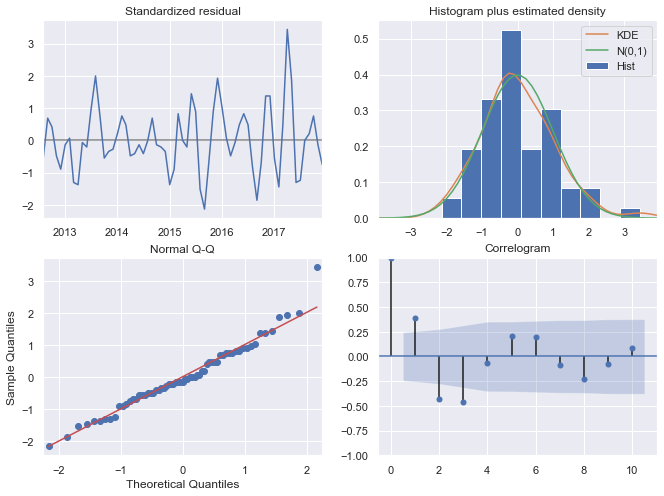

In [105]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
ps=datetime(2017,12,1)
pe=datetime(2018,4,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[9][start:]['value'], pdq=pdq, PDQS=PDQS, ps=ps, pe=pe)

ARIMA model RMSE on train data: 1533.37862
ARIMA model RMSE on test data: 2902.15437


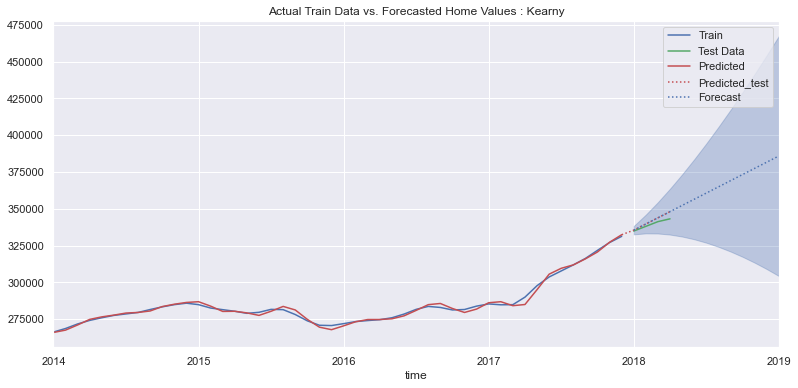

In [106]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2017,12,1)
test_start = datetime(2017,12,1)
test_end = datetime(2018,4,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')

forecast = results.get_forecast(steps = 13).predicted_mean
forecast.plot(label='Forecast',color='b',ls=':')
forecast_conf= results.get_forecast(steps = 13).conf_int(alpha=0.05)

plt.fill_between(forecast_conf.index,
                forecast_conf.iloc[:, 0],
                forecast_conf.iloc[:, 1], color='b', alpha=.3)

plt.legend(loc='best')
plt.title('Actual Train Data vs. Forecasted Home Values : Kearny')
plt.show()

In [107]:
roi_9 = ((forecast[-1] - forecast[0])/ forecast[0])*100
roi_9

15.022354694485843

In [108]:
df_hudson_county['ROI'][9] = roi_9
df_hudson_county

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


RegionName   Zip      ROI
0         Hoboken  7030      roi
1         Bayonne  7002      roi
2     Jersey City  7302      roi
3   West New York  7093  10.3448
4      Union City  7087  19.5543
5     Jersey City  7305  45.9507
6    North Bergen  7047  19.9748
7     Jersey City  7306  25.2705
8     Jersey City  7307  22.2989
9          Kearny  7032  15.0224
10       Secaucus  7094      roi
11      Weehawken  7086      roi
12       Harrison  7029      roi

# Secaucus 07094 Home Value Analysis: Time Series

In [109]:
df_NJ_HudsonZC[10].head()

RegionName      City     value
time                                      
1996-04-01        7094  Secaucus  189600.0
1996-05-01        7094  Secaucus  189300.0
1996-06-01        7094  Secaucus  188900.0
1996-07-01        7094  Secaucus  188500.0
1996-08-01        7094  Secaucus  188100.0

In [110]:
train, test = train_test_6m(df_NJ_HudsonZC[10][start:]['value'],datetime(2017,6,1),datetime(2018,1,1))

In [111]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1092.711, Time=0.34 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1091.530, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1094.852, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1096.657, Time=0.11 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1092.153, Time=0.06 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1092.113, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1094.567, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1096.550, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1095.067, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1093.498, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.958 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   61
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -544.765
Date:                Mon, 26 Apr 2021   AIC                           1091.530
Time:                        22:08:25   BIC                           1093.608
Sample:                    06-01-2012   HQIC                          1092.341
                         - 06-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.123e+06   8.17e+05      7.494      0.000    4.52e+06    7.72e+06
Ljung-Box (Q):                      103.28   Jarque-Bera (JB):                13.85
Prob(Q):                              0.00   Pr

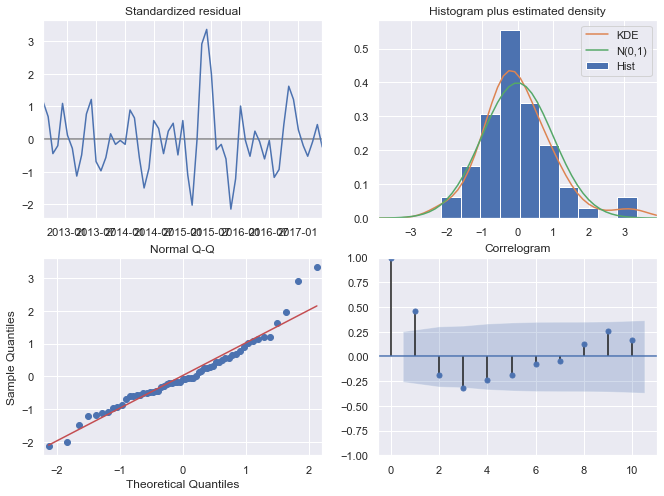

In [112]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
ps=datetime(2017,6,1)
pe=datetime(2018,1,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[10][start:]['value'], pdq=pdq, PDQS=PDQS)

ARIMA model RMSE on train data: 2711.48352
ARIMA model RMSE on test data: 3502.85598


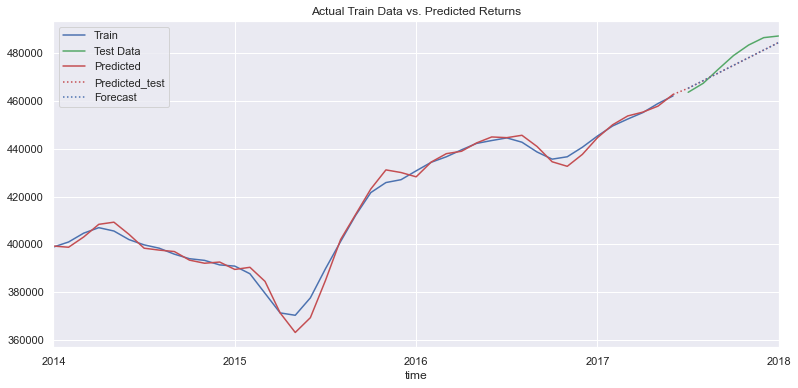

In [113]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2017,6,1)
test_start = datetime(2017,6,1)
test_end = datetime(2018,1,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')
results.forecast(steps = 7).plot(label='Forecast',color='b',ls=':')
plt.legend(loc='best')
plt.title('Actual Train Data vs. Predicted Returns')
plt.show()

In [114]:
train, test = train_test_6m(df_NJ_HudsonZC[10][start:]['value'],datetime(2017,12,1),datetime(2018,4,1))

In [115]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1209.669, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1198.850, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1202.174, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1204.299, Time=0.05 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1199.626, Time=0.11 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1204.568, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1200.046, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1200.037, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1202.540, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1200.821, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.909 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   67
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -598.425
Date:                Mon, 26 Apr 2021   AIC                           1198.850
Time:                        22:08:40   BIC                           1201.024
Sample:                    06-01-2012   HQIC                          1199.708
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.805e+06   7.31e+05      7.944      0.000    4.37e+06    7.24e+06
Ljung-Box (Q):                      123.86   Jarque-Bera (JB):                16.16
Prob(Q):                              0.00   Pr

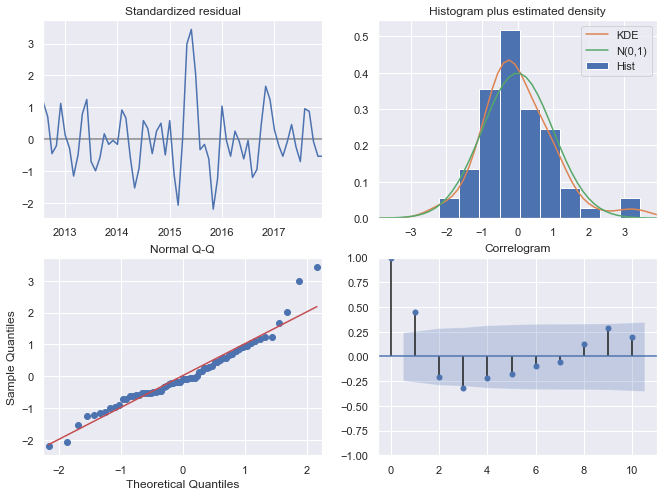

In [116]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
ps=datetime(2017,12,1)
pe=datetime(2018,4,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[10][start:]['value'], pdq=pdq, PDQS=PDQS, ps=ps, pe=pe)

ARIMA model RMSE on train data: 2601.28174
ARIMA model RMSE on test data: 12005.93603


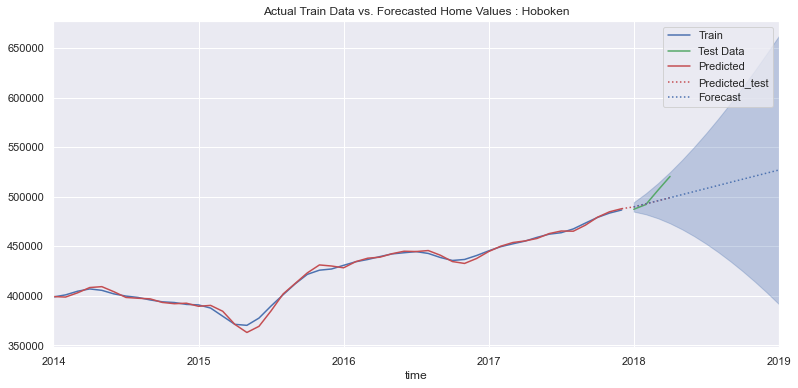

In [117]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2017,12,1)
test_start = datetime(2017,12,1)
test_end = datetime(2018,4,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')

forecast = results.get_forecast(steps = 13).predicted_mean
forecast.plot(label='Forecast',color='b',ls=':')
forecast_conf= results.get_forecast(steps = 13).conf_int(alpha=0.05)

plt.fill_between(forecast_conf.index,
                forecast_conf.iloc[:, 0],
                forecast_conf.iloc[:, 1], color='b', alpha=.3)

plt.legend(loc='best')
plt.title('Actual Train Data vs. Forecasted Home Values : Hoboken')
plt.show()

In [118]:
roi_10 = ((forecast[-1] - train_pred[-1])/ train_pred[-1])*100
roi_10

7.993441278950604

In [119]:
df_hudson_county['ROI'][10] = roi_10
df_hudson_county

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


RegionName   Zip      ROI
0         Hoboken  7030      roi
1         Bayonne  7002      roi
2     Jersey City  7302      roi
3   West New York  7093  10.3448
4      Union City  7087  19.5543
5     Jersey City  7305  45.9507
6    North Bergen  7047  19.9748
7     Jersey City  7306  25.2705
8     Jersey City  7307  22.2989
9          Kearny  7032  15.0224
10       Secaucus  7094  7.99344
11      Weehawken  7086      roi
12       Harrison  7029      roi

# Weehawken 07086 Home Value Analysis: Time Series

In [120]:
df_NJ_HudsonZC[11]

RegionName       City     value
time                                       
1996-04-01        7086  Weehawken  169700.0
1996-05-01        7086  Weehawken  169900.0
1996-06-01        7086  Weehawken  170000.0
1996-07-01        7086  Weehawken  170100.0
1996-08-01        7086  Weehawken  170200.0
...                ...        ...       ...
2017-12-01        7086  Weehawken  742600.0
2018-01-01        7086  Weehawken  749800.0
2018-02-01        7086  Weehawken  767700.0
2018-03-01        7086  Weehawken  804100.0
2018-04-01        7086  Weehawken  836100.0

[265 rows x 3 columns]

In [121]:
train, test = train_test_6m(df_NJ_HudsonZC[11][start:]['value'],datetime(2017,6,1),datetime(2018,1,1))

In [122]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1178.520, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1174.095, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1176.286, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1176.564, Time=0.09 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1175.826, Time=0.03 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1175.917, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1174.566, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1174.845, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1176.568, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1176.046, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.505 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   61
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -586.048
Date:                Mon, 26 Apr 2021   AIC                           1174.095
Time:                        22:09:21   BIC                           1176.173
Sample:                    06-01-2012   HQIC                          1174.906
                         - 06-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.402e+07   5.29e+06      4.541      0.000    1.36e+07    3.44e+07
Ljung-Box (Q):                      172.27   Jarque-Bera (JB):                 1.70
Prob(Q):                              0.00   Pr

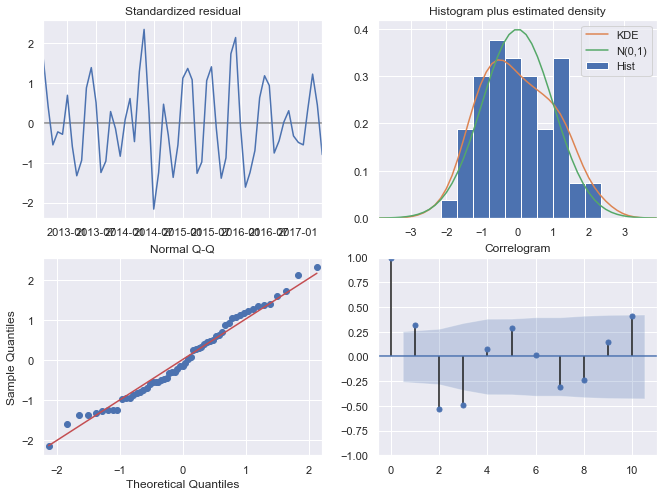

In [123]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
ps=datetime(2017,6,1)
pe=datetime(2018,1,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[11][start:]['value'], pdq=pdq, PDQS=PDQS)

ARIMA model RMSE on train data: 5244.52095
ARIMA model RMSE on test data: 36585.69197


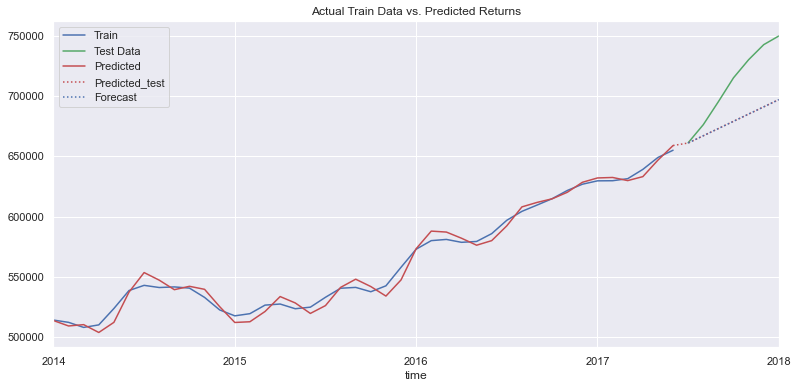

In [124]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2017,6,1)
test_start = datetime(2017,6,1)
test_end = datetime(2018,1,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')
results.forecast(steps = 7).plot(label='Forecast',color='b',ls=':')
plt.legend(loc='best')
plt.title('Actual Train Data vs. Predicted Returns')
plt.show()

In [125]:
train, test = train_test_6m(df_NJ_HudsonZC[11][start:]['value'],datetime(2018,2,1),datetime(2018,4,1))

In [126]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1335.699, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1337.880, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1337.718, Time=0.14 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1337.456, Time=0.02 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1337.468, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1336.122, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1335.947, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1337.649, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1337.509, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.785 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [127]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
ps=datetime(2018,2,1)
pe=datetime(2018,4,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[11][start:]['value'], pdq=pdq, PDQS=PDQS, ps=ps, pe=pe)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   69
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -666.850
Date:                Mon, 26 Apr 2021   AIC                           1335.699
Time:                        22:09:25   BIC                           1337.904
Sample:                    06-01-2012   HQIC                          1336.572
                         - 02-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       2.51e+07   5.15e+06      4.877      0.000     1.5e+07    3.52e+07
Ljung-Box (Q):                      189.34   Jarque-Bera (JB):                 2.24
Prob(Q):                              0.00   Pr

In [128]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2018,2,1)
test_start = datetime(2018,2,1)
test_end = datetime(2018,4,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')

forecast = results.get_forecast(steps = 13).predicted_mean
forecast.plot(label='Forecast',color='b',ls=':')
forecast_conf= results.get_forecast(steps = 13).conf_int(alpha=0.05)

plt.fill_between(forecast_conf.index,
                forecast_conf.iloc[:, 0],
                forecast_conf.iloc[:, 1], color='b', alpha=.3)

plt.legend(loc='best')
plt.title('Actual Train Data vs. Forecasted Home Values : Hoboken')
plt.show()

ARIMA model RMSE on train data: 5332.65412
ARIMA model RMSE on test data: 26504.81088


In [129]:
roi_11 = ((forecast[-3] - train_pred[-2])/ train_pred[-2])*100
roi_11

27.744669580188052

In [130]:
df_hudson_county['ROI'][11] = roi_11
df_hudson_county

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


RegionName   Zip      ROI
0         Hoboken  7030      roi
1         Bayonne  7002      roi
2     Jersey City  7302      roi
3   West New York  7093  10.3448
4      Union City  7087  19.5543
5     Jersey City  7305  45.9507
6    North Bergen  7047  19.9748
7     Jersey City  7306  25.2705
8     Jersey City  7307  22.2989
9          Kearny  7032  15.0224
10       Secaucus  7094  7.99344
11      Weehawken  7086  27.7447
12       Harrison  7029      roi

# Harrison 07029 Home Value Analysis: Time Series

In [131]:
df_NJ_HudsonZC[12].head(5)

RegionName      City     value
time                                      
1996-04-01        7029  Harrison  154200.0
1996-05-01        7029  Harrison  154300.0
1996-06-01        7029  Harrison  154400.0
1996-07-01        7029  Harrison  154400.0
1996-08-01        7029  Harrison  154500.0

In [132]:
train, test = train_test_6m(df_NJ_HudsonZC[12][start:]['value'],datetime(2017,6,1),datetime(2018,1,1))

In [133]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1090.148, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1078.978, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1082.011, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1082.064, Time=0.05 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1081.488, Time=0.05 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1080.760, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1080.229, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1080.286, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1082.264, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1080.921, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.381 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [134]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
ps=datetime(2017,6,1)
pe=datetime(2018,1,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[12][start:]['value'], pdq=pdq, PDQS=PDQS)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   61
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -538.489
Date:                Mon, 26 Apr 2021   AIC                           1078.978
Time:                        22:09:49   BIC                           1081.056
Sample:                    06-01-2012   HQIC                          1079.789
                         - 06-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       4.95e+06   7.73e+05      6.402      0.000    3.43e+06    6.46e+06
Ljung-Box (Q):                      152.50   Jarque-Bera (JB):                 1.67
Prob(Q):                              0.00   Pr

ARIMA model RMSE on train data: 2346.32438
ARIMA model RMSE on test data: 11555.57998


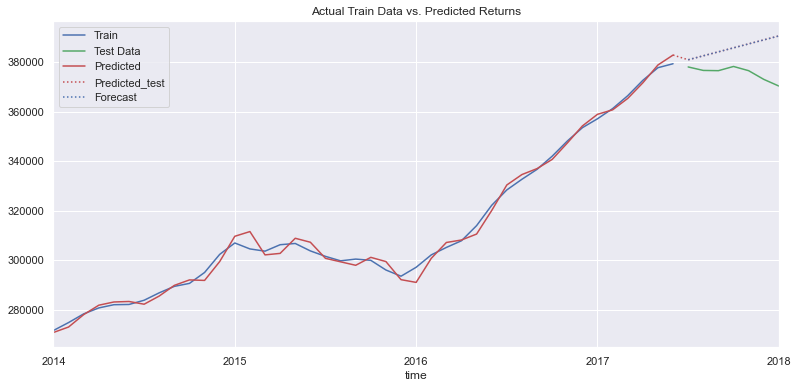

In [135]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2017,6,1)
test_start = datetime(2017,6,1)
test_end = datetime(2018,1,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')
results.forecast(steps = 7).plot(label='Forecast',color='b',ls=':')
plt.legend(loc='best')
plt.title('Actual Train Data vs. Predicted Returns')
plt.show()

In [136]:
train, test = train_test_6m(df_NJ_HudsonZC[12][start:]['value'],datetime(2018,3,1),datetime(2018,4,1))

In [137]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1248.002, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1243.126, Time=0.11 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1246.263, Time=0.11 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1246.414, Time=0.06 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1245.177, Time=0.04 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1244.916, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1244.499, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1244.654, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1246.433, Time=0.15 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1245.042, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.694 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [138]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
ps=datetime(2018,3,1)
pe=datetime(2018,4,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[12][start:]['value'], pdq=pdq, PDQS=PDQS, ps=ps, pe=pe)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   70
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -620.563
Date:                Mon, 26 Apr 2021   AIC                           1243.126
Time:                        22:09:55   BIC                           1245.346
Sample:                    06-01-2012   HQIC                          1244.006
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.941e+06   7.58e+05      6.516      0.000    3.45e+06    6.43e+06
Ljung-Box (Q):                       98.34   Jarque-Bera (JB):                 1.02
Prob(Q):                              0.00   Pr

ARIMA model RMSE on train data: 2322.69283
ARIMA model RMSE on test data: 1100.00000


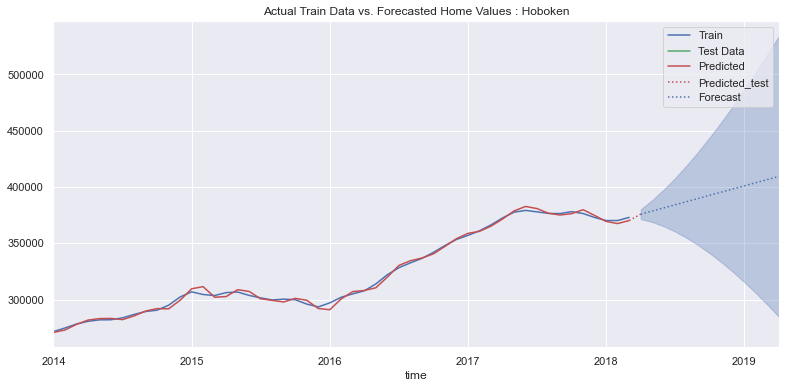

In [139]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2018,3,1)
test_start = datetime(2018,3,1)
test_end = datetime(2018,4,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')

forecast = results.get_forecast(steps = 13).predicted_mean
forecast.plot(label='Forecast',color='b',ls=':')
forecast_conf= results.get_forecast(steps = 13).conf_int(alpha=0.05)

plt.fill_between(forecast_conf.index,
                forecast_conf.iloc[:, 0],
                forecast_conf.iloc[:, 1], color='b', alpha=.3)

plt.legend(loc='best')
plt.title('Actual Train Data vs. Forecasted Home Values : Hoboken')
plt.show()

In [140]:
roi_12 = ((forecast[9] - train_pred[-3])/ train_pred[-3])*100
roi_12

8.552097428958051

In [141]:
df_hudson_county['ROI'][12] = roi_12

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [142]:
df_hudson_county

RegionName   Zip      ROI
0         Hoboken  7030      roi
1         Bayonne  7002      roi
2     Jersey City  7302      roi
3   West New York  7093  10.3448
4      Union City  7087  19.5543
5     Jersey City  7305  45.9507
6    North Bergen  7047  19.9748
7     Jersey City  7306  25.2705
8     Jersey City  7307  22.2989
9          Kearny  7032  15.0224
10       Secaucus  7094  7.99344
11      Weehawken  7086  27.7447
12       Harrison  7029   8.5521

# Hoboken 07030 Home Value Analysis: Time Series

In [143]:
df_NJ_HudsonZC[0].head(5)

RegionName     City     value
time                                     
1996-04-01        7030  Hoboken  301600.0
1996-05-01        7030  Hoboken  302700.0
1996-06-01        7030  Hoboken  303800.0
1996-07-01        7030  Hoboken  304800.0
1996-08-01        7030  Hoboken  305800.0

In [144]:
train, test = train_test_6m(df_NJ_HudsonZC[0][start:]['value'],datetime(2017,6,1),datetime(2018,1,1))

In [145]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1219.960, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1213.090, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1216.799, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1214.675, Time=0.06 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1218.951, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1215.282, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1217.427, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1214.875, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.898 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   61
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -605.545
Date:                Mon, 26 Apr 2021   AIC                           1213.090
Time:                        22:10:19   BIC                           1215.168
Sample:                    06-01-2012   HQIC                          1213.901
                         - 06-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.651e+07   7.44e+06      6.252      0.000    3.19e+07    6.11e+07
Ljung-Box (Q):                       97.22   Jarque-Bera (JB):                 3.52
Prob(Q):                              0.00   Pr

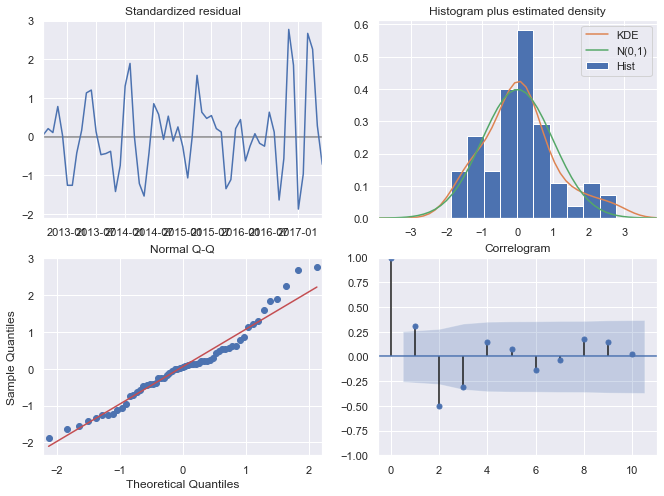

In [146]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
ps=datetime(2017,6,1)
pe=datetime(2018,1,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[0][start:]['value'], pdq=pdq, PDQS=PDQS)

ARIMA model RMSE on train data: 7520.54329
ARIMA model RMSE on test data: 96974.99678


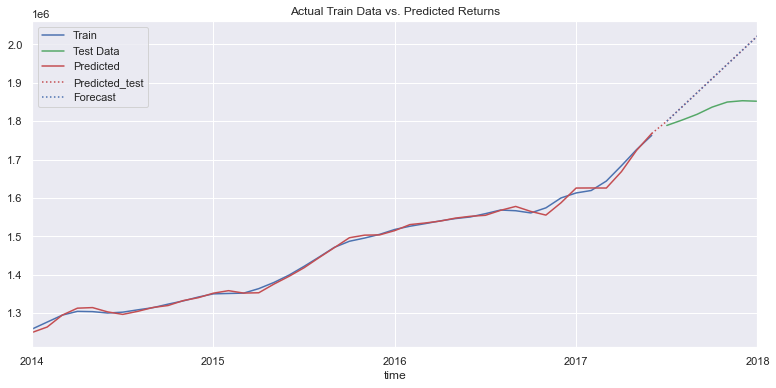

In [147]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2017,6,1)
test_start = datetime(2017,6,1)
test_end = datetime(2018,1,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')
results.forecast(steps = 7).plot(label='Forecast',color='b',ls=':')
plt.legend(loc='best')
plt.title('Actual Train Data vs. Predicted Returns')
plt.show()

In [150]:
train, test = train_test_6m(df_NJ_HudsonZC[0][start:]['value'],datetime(2017,12,1),datetime(2018,4,1))

In [151]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1338.719, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1342.658, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1345.243, Time=0.12 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1340.567, Time=0.03 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1344.688, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1341.089, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1343.759, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1345.785, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1340.652, Time=0.02 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.742 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   67
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -668.359
Date:                Mon, 26 Apr 2021   AIC                           1338.719
Time:                        22:10:46   BIC                           1340.893
Sample:                    06-01-2012   HQIC                          1339.577
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.846e+07   7.84e+06      6.180      0.000    3.31e+07    6.38e+07
Ljung-Box (Q):                       91.56   Jarque-Bera (JB):                 3.11
Prob(Q):                              0.00   Pr

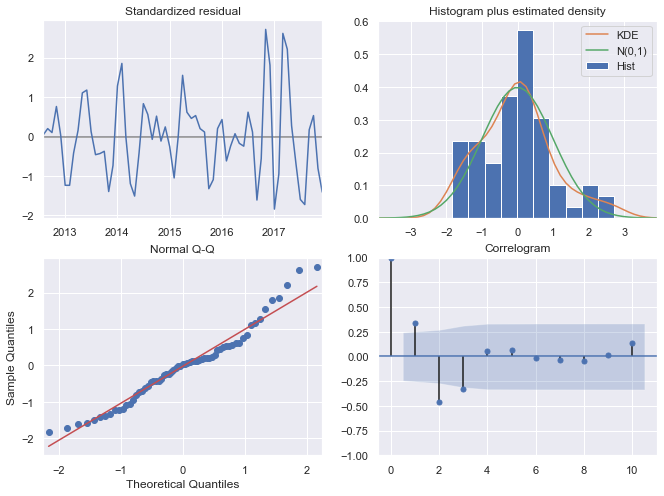

In [152]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
ps=datetime(2017,12,1)
pe=datetime(2018,4,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[0][start:]['value'], pdq=pdq, PDQS=PDQS, ps=ps, pe=pe)

ARIMA model RMSE on train data: 7617.41426
ARIMA model RMSE on test data: 8030.41095


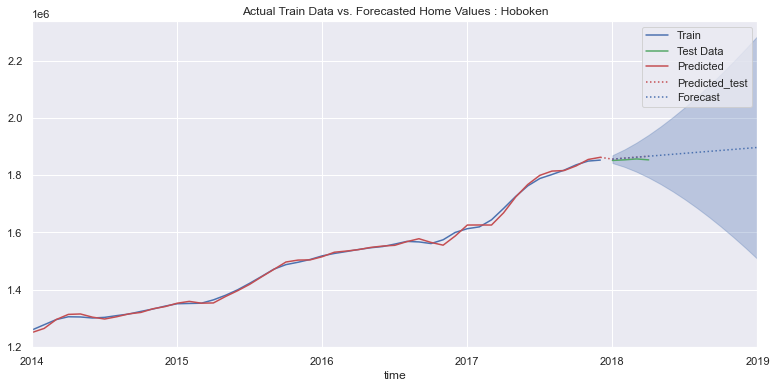

In [153]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2017,12,1)
test_start = datetime(2017,12,1)
test_end = datetime(2018,4,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')

forecast = results.get_forecast(steps = 13).predicted_mean
forecast.plot(label='Forecast',color='b',ls=':')
forecast_conf= results.get_forecast(steps = 13).conf_int(alpha=0.05)

plt.fill_between(forecast_conf.index,
                forecast_conf.iloc[:, 0],
                forecast_conf.iloc[:, 1], color='b', alpha=.3)

plt.legend(loc='best')
plt.title('Actual Train Data vs. Forecasted Home Values : Hoboken')
plt.show()

In [154]:
roi_0 = ((forecast[-1] - forecast[0])/ forecast[0])*100
roi_0

2.1972104044375036

In [155]:
df_hudson_county['ROI'][0] = roi_0

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [156]:
df_hudson_county

RegionName   Zip      ROI
0         Hoboken  7030  2.19721
1         Bayonne  7002      roi
2     Jersey City  7302      roi
3   West New York  7093  10.3448
4      Union City  7087  19.5543
5     Jersey City  7305  45.9507
6    North Bergen  7047  19.9748
7     Jersey City  7306  25.2705
8     Jersey City  7307  22.2989
9          Kearny  7032  15.0224
10       Secaucus  7094  7.99344
11      Weehawken  7086  27.7447
12       Harrison  7029   8.5521

# Bayonne 07002 Home Value Analysis: Time Series 

In [157]:
df_NJ_HudsonZC[1].head(5)

RegionName     City     value
time                                     
1996-04-01        7002  Bayonne  145000.0
1996-05-01        7002  Bayonne  144500.0
1996-06-01        7002  Bayonne  143900.0
1996-07-01        7002  Bayonne  143300.0
1996-08-01        7002  Bayonne  142800.0

In [158]:
train, test = train_test_6m(df_NJ_HudsonZC[1][start:]['value'],datetime(2017,6,1),datetime(2018,1,1))

In [159]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1051.986, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1048.285, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1052.181, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1058.071, Time=0.08 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1050.726, Time=0.06 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1050.118, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1050.699, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1056.803, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1058.832, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1050.202, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.530 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   61
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -523.142
Date:                Mon, 26 Apr 2021   AIC                           1048.285
Time:                        22:10:59   BIC                           1050.362
Sample:                    06-01-2012   HQIC                          1049.096
                         - 06-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.942e+06    5.8e+05      5.077      0.000    1.81e+06    4.08e+06
Ljung-Box (Q):                       83.95   Jarque-Bera (JB):                 1.15
Prob(Q):                              0.00   Pr

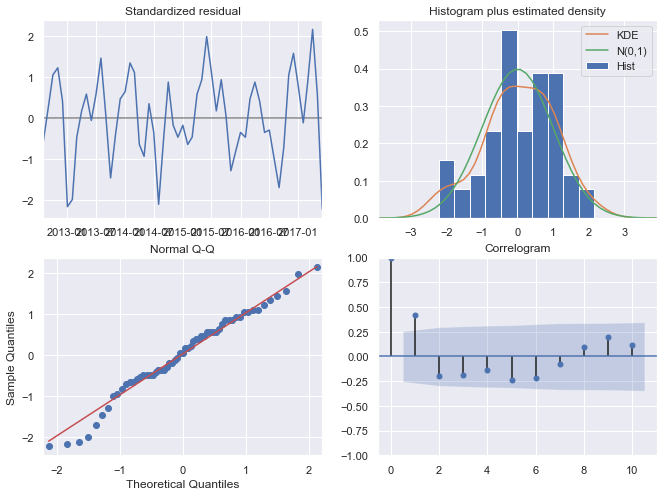

In [160]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
ps=datetime(2017,6,1)
pe=datetime(2018,1,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[1][start:]['value'], pdq=pdq, PDQS=PDQS)

ARIMA model RMSE on train data: 1710.26314
ARIMA model RMSE on test data: 6601.73137


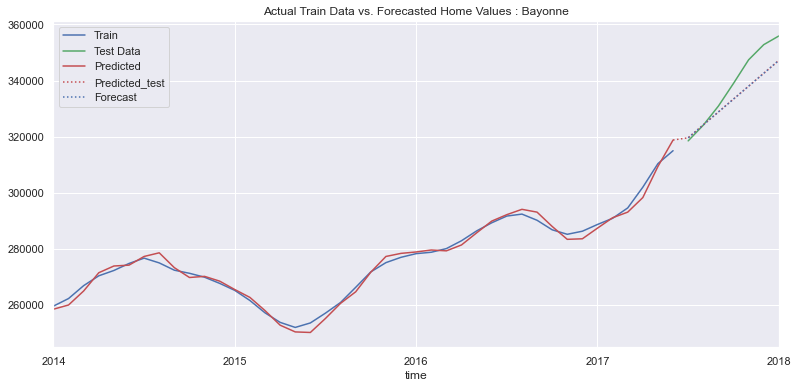

In [161]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2017,6,1)
test_start = datetime(2017,6,1)
test_end = datetime(2018,1,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')
results.forecast(steps = 7).plot(label='Forecast',color='b',ls=':')
plt.legend(loc='best')
plt.title('Actual Train Data vs. Forecasted Home Values : Bayonne')
plt.show()

From this analysis we can say that using the auto arima best fit model show a reliable forecast. Following this we will expand the train data to the end of the time series to apply it to the rest of 2018. 

In [162]:
train, test = train_test_6m(df_NJ_HudsonZC[1][start:]['value'],datetime(2017,12,1),datetime(2018,4,1))

In [163]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1158.129, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1154.743, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1158.414, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1163.164, Time=0.08 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1157.866, Time=0.05 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1156.323, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1156.996, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1161.948, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1164.057, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1156.633, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.693 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   67
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -576.372
Date:                Mon, 26 Apr 2021   AIC                           1154.743
Time:                        22:11:04   BIC                           1156.918
Sample:                    06-01-2012   HQIC                          1155.601
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.945e+06   5.64e+05      5.222      0.000    1.84e+06    4.05e+06
Ljung-Box (Q):                       95.91   Jarque-Bera (JB):                 1.62
Prob(Q):                              0.00   Pr

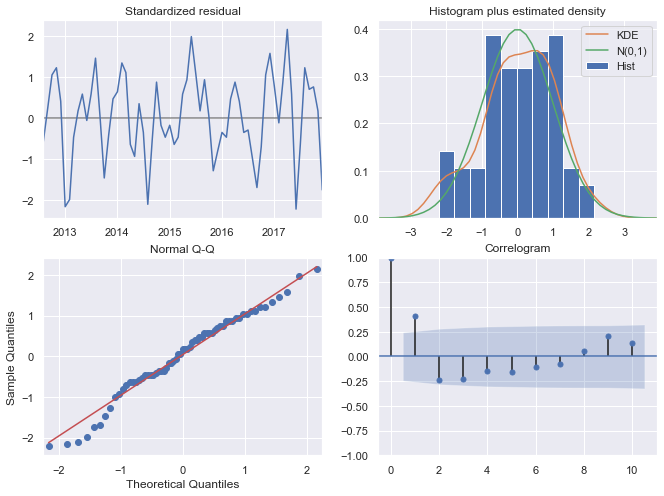

In [164]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
ps=datetime(2017,12,1)
pe=datetime(2018,4,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[1][start:]['value'], pdq=pdq, PDQS=PDQS, ps=ps, pe=pe)

ARIMA model RMSE on train data: 1712.02852
ARIMA model RMSE on test data: 1734.93516


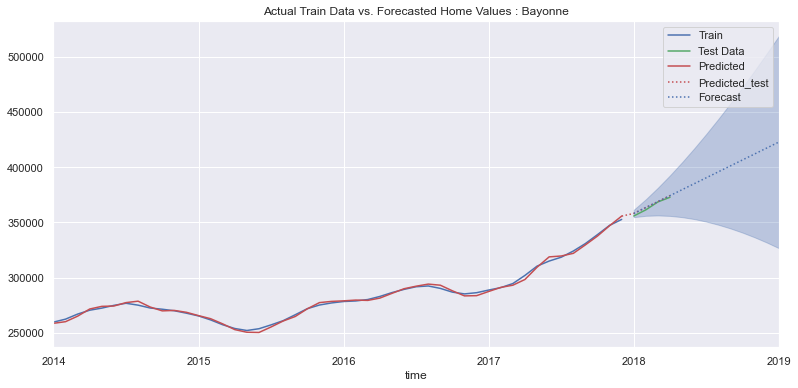

In [165]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2017,12,1)
test_start = datetime(2017,12,1)
test_end = datetime(2018,4,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')

forecast = results.get_forecast(steps = 13).predicted_mean
forecast.plot(label='Forecast',color='b',ls=':')
forecast_conf= results.get_forecast(steps = 13).conf_int(alpha=0.05)

plt.fill_between(forecast_conf.index,
                forecast_conf.iloc[:, 0],
                forecast_conf.iloc[:, 1], color='b', alpha=.3)

plt.legend(loc='best')
plt.title('Actual Train Data vs. Forecasted Home Values : Bayonne')
plt.show()

In [166]:
roi = ((forecast[-1] - forecast[0])/ forecast[0])*100
roi

18.090452261306535

In [167]:
df_hudson_county['ROI'][1] = roi

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [168]:
df_hudson_county

RegionName   Zip      ROI
0         Hoboken  7030  2.19721
1         Bayonne  7002  18.0905
2     Jersey City  7302      roi
3   West New York  7093  10.3448
4      Union City  7087  19.5543
5     Jersey City  7305  45.9507
6    North Bergen  7047  19.9748
7     Jersey City  7306  25.2705
8     Jersey City  7307  22.2989
9          Kearny  7032  15.0224
10       Secaucus  7094  7.99344
11      Weehawken  7086  27.7447
12       Harrison  7029   8.5521

# Jersey City 07302 Home Value Analysis: Time Series 

In [169]:
df_NJ_HudsonZC[2].head(5)

RegionName         City     value
time                                         
1996-04-01        7302  Jersey City  137200.0
1996-05-01        7302  Jersey City  137800.0
1996-06-01        7302  Jersey City  138500.0
1996-07-01        7302  Jersey City  139100.0
1996-08-01        7302  Jersey City  139600.0

In [170]:
train, test = train_test_6m(df_NJ_HudsonZC[2][start:]['value'],datetime(2017,6,1),datetime(2018,1,1))

In [171]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1201.189, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1197.807, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1200.037, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1200.276, Time=0.09 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1201.122, Time=0.06 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1202.627, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1198.944, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1199.259, Time=0.08 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1199.499, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.624 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   61
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -597.903
Date:                Mon, 26 Apr 2021   AIC                           1197.807
Time:                        22:11:16   BIC                           1199.884
Sample:                    06-01-2012   HQIC                          1198.618
                         - 06-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       3.59e+07    6.9e+06      5.203      0.000    2.24e+07    4.94e+07
Ljung-Box (Q):                       60.36   Jarque-Bera (JB):                 2.43
Prob(Q):                              0.02   Pr

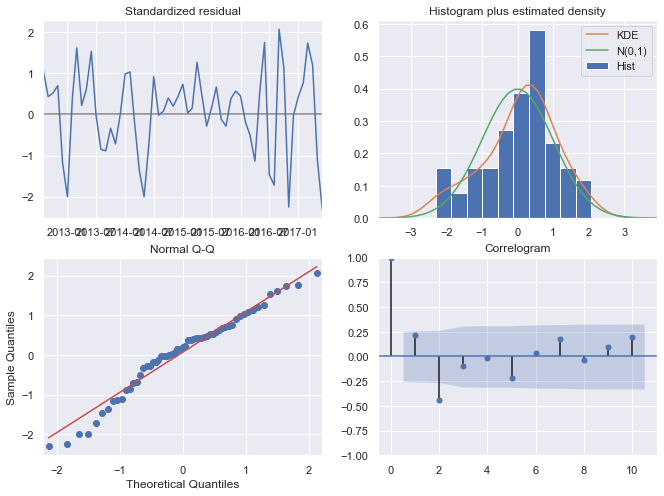

In [172]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
ps=datetime(2017,6,1)
pe=datetime(2018,1,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[2][start:]['value'], pdq=pdq, PDQS=PDQS)

ARIMA model RMSE on train data: 6257.16732
ARIMA model RMSE on test data: 21594.93988


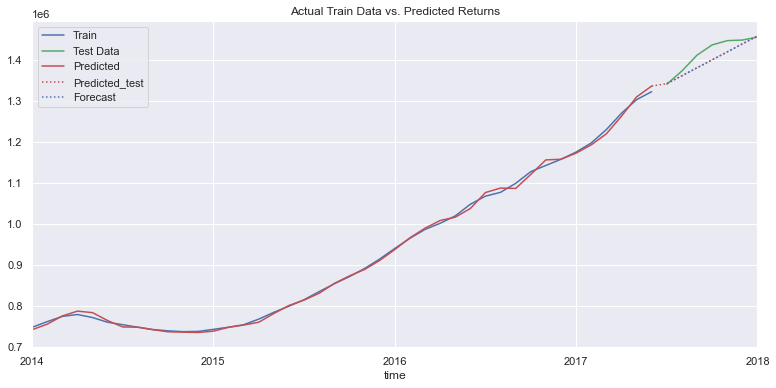

In [173]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2017,6,1)
test_start = datetime(2017,6,1)
test_end = datetime(2018,1,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')
results.forecast(steps = 7).plot(label='Forecast',color='b',ls=':')
plt.legend(loc='best')
plt.title('Actual Train Data vs. Predicted Returns')
plt.show()

From this analysis we can say that using the auto arima best fit model show a reliable forecast. Following this we will expand the train data to the end of the time series to apply it to the rest of 2018. 

In [174]:
train, test = train_test_6m(df_NJ_HudsonZC[2][start:]['value'],datetime(2017,12,1),datetime(2018,4,1))

In [175]:
results = pm.auto_arima(train,information_criterion='aic',m=12,d=2, 
                        start_p=0,start_q=0, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1337.530, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1331.482, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1334.238, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1335.071, Time=0.09 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1332.834, Time=0.03 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1337.857, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1333.033, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1333.965, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1333.437, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.669 seconds


ARIMA(order=(0, 2, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   67
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -664.741
Date:                Mon, 26 Apr 2021   AIC                           1331.482
Time:                        22:11:21   BIC                           1333.656
Sample:                    06-01-2012   HQIC                          1332.340
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.335e+07   8.09e+06      5.359      0.000    2.75e+07    5.92e+07
Ljung-Box (Q):                       45.69   Jarque-Bera (JB):                 2.17
Prob(Q):                              0.25   Pr

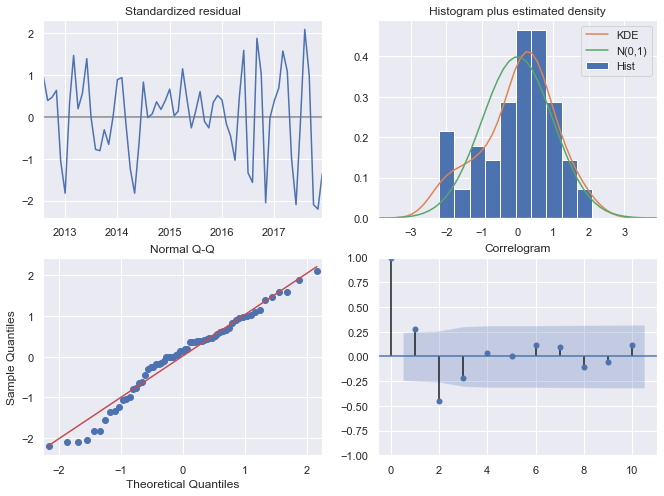

In [176]:
pdq = (0,2,0)
PDQS = (0,0,0,12)
ps=datetime(2017,12,1)
pe=datetime(2018,4,1)
train, test, results = model_fit_SARIMAX(df_NJ_HudsonZC[2][start:]['value'], pdq=pdq, PDQS=PDQS, ps=ps, pe=pe)

ARIMA model RMSE on train data: 7011.15183
ARIMA model RMSE on test data: 15058.71840


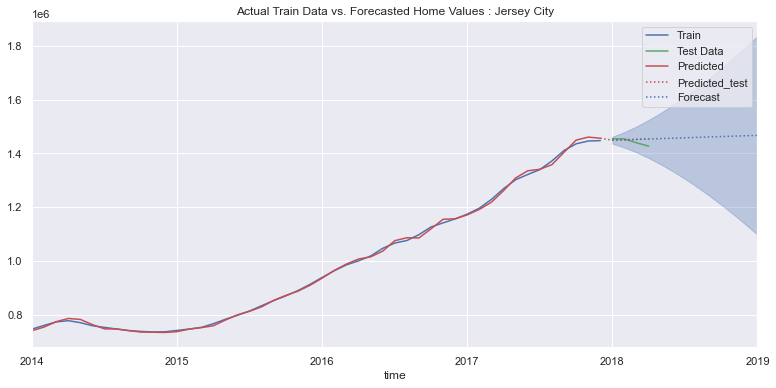

In [177]:
pred_start = datetime(2014,1,1)
pred_end = datetime(2017,12,1)
test_start = datetime(2017,12,1)
test_end = datetime(2018,4,1)

train_pred = results.predict(start = pred_start, end = pred_end, typ='levels')
test_pred = results.predict(start = test_start, end = test_end, typ='levels')
rmse = math.sqrt(mean_squared_error(train[pred_start:pred_end],train_pred))
rmse_test = math.sqrt(mean_squared_error(test[test_start:test_end],test_pred[test_start + timedelta(days=1):test_end]))
print(f'ARIMA model RMSE on train data: %.5f' % rmse)
print(f'ARIMA model RMSE on test data: %.5f' % rmse_test)

plt.figure(figsize=(13,6))
train[pred_start:pred_end].plot(label='Train',color='b')
test[test_start:test_end].plot(label='Test Data',color='g')
train_pred.plot(label='Predicted',color='r')
test_pred.plot(label='Predicted_test', color='r',ls=':')

forecast = results.get_forecast(steps = 13).predicted_mean
forecast.plot(label='Forecast',color='b',ls=':')
forecast_conf= results.get_forecast(steps = 13).conf_int(alpha=0.05)

plt.fill_between(forecast_conf.index,
                forecast_conf.iloc[:, 0],
                forecast_conf.iloc[:, 1], color='b', alpha=.3)

plt.legend(loc='best')
plt.title('Actual Train Data vs. Forecasted Home Values : Jersey City')
plt.show()

In [178]:
roi_2 = ((forecast[-1] - forecast[0])/ forecast[0])*100
roi_2

1.2419788863589318

In [179]:
df_hudson_county['ROI'][2] = roi_2
df_hudson_county

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


RegionName   Zip      ROI
0         Hoboken  7030  2.19721
1         Bayonne  7002  18.0905
2     Jersey City  7302  1.24198
3   West New York  7093  10.3448
4      Union City  7087  19.5543
5     Jersey City  7305  45.9507
6    North Bergen  7047  19.9748
7     Jersey City  7306  25.2705
8     Jersey City  7307  22.2989
9          Kearny  7032  15.0224
10       Secaucus  7094  7.99344
11      Weehawken  7086  27.7447
12       Harrison  7029   8.5521

In [180]:
df_hudson_county

RegionName   Zip      ROI
0         Hoboken  7030  2.19721
1         Bayonne  7002  18.0905
2     Jersey City  7302  1.24198
3   West New York  7093  10.3448
4      Union City  7087  19.5543
5     Jersey City  7305  45.9507
6    North Bergen  7047  19.9748
7     Jersey City  7306  25.2705
8     Jersey City  7307  22.2989
9          Kearny  7032  15.0224
10       Secaucus  7094  7.99344
11      Weehawken  7086  27.7447
12       Harrison  7029   8.5521

In [181]:
df_hudson_county_sorted = df_hudson_county.sort_values(by='ROI')
df_hudson_county_sorted[-5:]

RegionName   Zip      ROI
6   North Bergen  7047  19.9748
8    Jersey City  7307  22.2989
7    Jersey City  7306  25.2705
11     Weehawken  7086  27.7447
5    Jersey City  7305  45.9507

In [182]:
df_hudson_county_sorted[-7:]

RegionName   Zip      ROI
1        Bayonne  7002  18.0905
4     Union City  7087  19.5543
6   North Bergen  7047  19.9748
8    Jersey City  7307  22.2989
7    Jersey City  7306  25.2705
11     Weehawken  7086  27.7447
5    Jersey City  7305  45.9507

In [416]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Selecting Investments based off of Coefficient of Variation

- The coefficient of variations allows investors to look into the variabilty or risk assumed in that market and compare it against the amount of expected return. 
- The lower the ration, the better the risk-return trade-off

Typically investors that follow a risk-adverse may want to consider assets with a historically low degree of volatility relative to the the expected return. 
Vice-versa, investors that follow a risk-seeking may look into assets with historically high degree of volatility. 

## For comparitive purpose

For illustrative purposes, the following 15-year historical information is used for the investor's decision:

- If the SPDR S&P 500 ETF has an average annual return of 5.47% and a standard deviation of 14.68%, the SPDR S&P 500 ETF's coefficient of variation is 2.68.
- If the Invesco QQQ ETF has an average annual return of 6.88% and a standard deviation of 21.31%, the QQQ's coefficient of variation is 3.10.
- If the iShares Russell 2000 ETF has an average annual return of 7.16% and a standard deviation of 19.46%, the IWM's coefficient of variation is 2.72.


In [183]:
#create a column to put in the std for each zip code in Hudson County that will represent the Volatility 
df_hudson_county['Volatility'] = 'std'
#create a column to put in the mean for each zip code in Hudson County that will represent the Expected Return 
df_hudson_county['ExpectedReturn'] = 'mean'
df_hudson_county

RegionName   Zip      ROI Volatility ExpectedReturn
0         Hoboken  7030  2.19721        std           mean
1         Bayonne  7002  18.0905        std           mean
2     Jersey City  7302  1.24198        std           mean
3   West New York  7093  10.3448        std           mean
4      Union City  7087  19.5543        std           mean
5     Jersey City  7305  45.9507        std           mean
6    North Bergen  7047  19.9748        std           mean
7     Jersey City  7306  25.2705        std           mean
8     Jersey City  7307  22.2989        std           mean
9          Kearny  7032  15.0224        std           mean
10       Secaucus  7094  7.99344        std           mean
11      Weehawken  7086  27.7447        std           mean
12       Harrison  7029   8.5521        std           mean

In [184]:
for i in range(len(df_hudson_county)):
    #Calculate the Volatilty for each zip code by finding the std of the percent change between 1996-2017
    df_hudson_county['Volatility'][i] = df_NJ_HudsonZC[i].loc['1996-01':'2017-12'].resample('A').ffill().value.pct_change().std(skipna=True, axis=0)
    #Calculate the Expected Return for each zip code by finding the mean of all the  percent change between 1996-2017
    df_hudson_county['ExpectedReturn'][i] = df_NJ_HudsonZC[i].loc['1996-01':'2017-12'].resample('A').ffill().value.pct_change().mean(skipna=True, axis=0)
df_hudson_county

C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\egust\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


RegionName   Zip      ROI Volatility ExpectedReturn
0         Hoboken  7030  2.19721  0.0883168      0.0922444
1         Bayonne  7002  18.0905   0.112629      0.0500935
2     Jersey City  7302  1.24198   0.134917       0.124622
3   West New York  7093  10.3448   0.134678      0.0615988
4      Union City  7087  19.5543   0.135128      0.0666972
5     Jersey City  7305  45.9507   0.136132      0.0548295
6    North Bergen  7047  19.9748   0.114805      0.0537455
7     Jersey City  7306  25.2705   0.123584      0.0828662
8     Jersey City  7307  22.2989   0.140347      0.0796138
9          Kearny  7032  15.0224   0.104911      0.0432575
10       Secaucus  7094  7.99344  0.0889009      0.0501045
11      Weehawken  7086  27.7447  0.0970639      0.0764506
12       Harrison  7029   8.5521   0.113029      0.0488406

In [185]:
# Calculating the coefficient of Variations for all Zip codes
df_hudson_county['CV'] = (df_hudson_county['Volatility']/df_hudson_county['ExpectedReturn'])
df_hudson_county

RegionName   Zip      ROI Volatility ExpectedReturn        CV
0         Hoboken  7030  2.19721  0.0883168      0.0922444  0.957422
1         Bayonne  7002  18.0905   0.112629      0.0500935   2.24837
2     Jersey City  7302  1.24198   0.134917       0.124622   1.08261
3   West New York  7093  10.3448   0.134678      0.0615988   2.18637
4      Union City  7087  19.5543   0.135128      0.0666972   2.02599
5     Jersey City  7305  45.9507   0.136132      0.0548295   2.48282
6    North Bergen  7047  19.9748   0.114805      0.0537455   2.13608
7     Jersey City  7306  25.2705   0.123584      0.0828662   1.49137
8     Jersey City  7307  22.2989   0.140347      0.0796138   1.76284
9          Kearny  7032  15.0224   0.104911      0.0432575   2.42527
10       Secaucus  7094  7.99344  0.0889009      0.0501045   1.77431
11      Weehawken  7086  27.7447  0.0970639      0.0764506   1.26963
12       Harrison  7029   8.5521   0.113029      0.0488406   2.31425

In [186]:
df_hudson_county.sort_values(by='CV')

RegionName   Zip      ROI Volatility ExpectedReturn        CV
0         Hoboken  7030  2.19721  0.0883168      0.0922444  0.957422
2     Jersey City  7302  1.24198   0.134917       0.124622   1.08261
11      Weehawken  7086  27.7447  0.0970639      0.0764506   1.26963
7     Jersey City  7306  25.2705   0.123584      0.0828662   1.49137
8     Jersey City  7307  22.2989   0.140347      0.0796138   1.76284
10       Secaucus  7094  7.99344  0.0889009      0.0501045   1.77431
4      Union City  7087  19.5543   0.135128      0.0666972   2.02599
6    North Bergen  7047  19.9748   0.114805      0.0537455   2.13608
3   West New York  7093  10.3448   0.134678      0.0615988   2.18637
1         Bayonne  7002  18.0905   0.112629      0.0500935   2.24837
12       Harrison  7029   8.5521   0.113029      0.0488406   2.31425
9          Kearny  7032  15.0224   0.104911      0.0432575   2.42527
5     Jersey City  7305  45.9507   0.136132      0.0548295   2.48282

### Conclusion

As you can see the highest level of coefficient of variation is in Jersey City, with a CV of about 2.5. When comparing these number with a those of the stock market, like the ETF's shown above, it is safe to say that investing in real estate in Hudson county has a a better risk-return trade off. For this reason, we suggest investing in zip codes with the highest ROI. By using AI we were able to generate ROIs for the year of 2018 for all zip codes in Hudson County, NJ. Our recommendation is to invest in properties in the following zipcodes. 

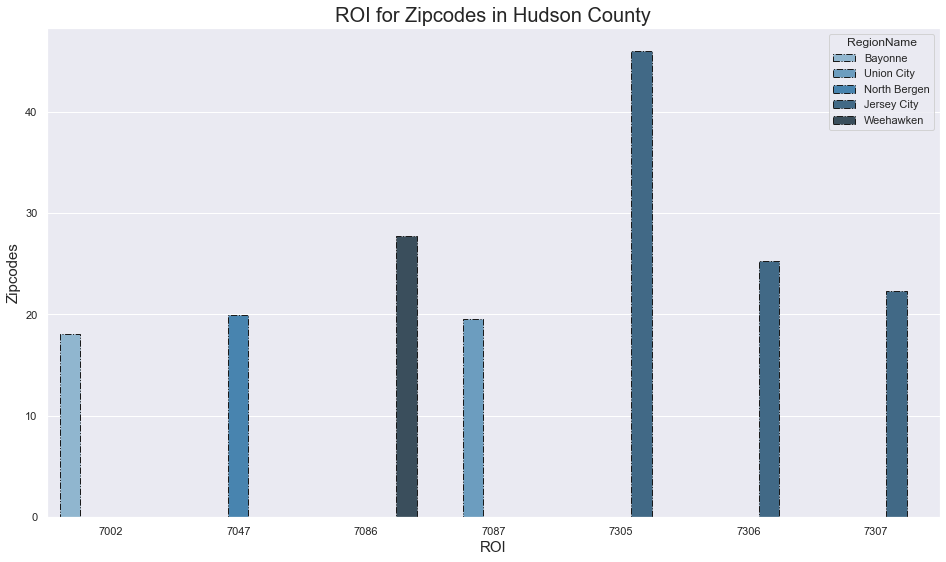

In [195]:
sns.set()
plt.figure(figsize = (16,9))
sns.barplot(x=df_hudson_county_sorted[-7:].Zip, 
            y=df_hudson_county_sorted[-7:].ROI, 
            hue=df_hudson_county_sorted[-7:].RegionName,
            palette="Blues_d",
            alpha =1, linestyle = "-.", linewidth = 1,
            edgecolor = "k")

plt.title("ROI for Zipcodes in Hudson County", fontsize = 20)
plt.xlabel("ROI", fontsize = 15)
plt.ylabel("Zipcodes", fontsize = 15)

plt.savefig("ROI for Zipcodes in Hudson County")
plt.show()

# Evaluation

# Conclusion
In conclusion, The Zillow median home sale prices are a great dataset to develop insights that will help in the processes of formulating an investing strategy. With this dataset you can transform this data into a time series to run analysis to see if certain historical patterns persist over time. However, the model does not perform well under situations that can not be foreseen. With this mind our ARIMA models should be used to make predication at most 1 year out as the result become unreliable as you continue to increase the time frame. You can also streamline this process with other markets besides Hudson county as it seems like the simple model performs well with mostly all the zip codes.

## Recomendation
1. Continue to invest heavily in Jersey City as the market still has room for potential returns
2. I would also begin to make strategic steps to enter areas like Weehawken, North Bergen, Union City and West New York. Eventually when Jersey City becomes over saturated, like Hoboken, these other towns provide promising returns
3. Consider entering the development space as the need for parking spaces is a problem for all these areas. By building studio apartment with parking spaces your firm would surely capitalize on the growing demand to head to North Jersey

# Future Work
Due to the inability for the model to correctly adjust to unique events the best way to prepare for this is to understand the relationship between these home sale values with exogenous data. The ones that I wish to explore are interest rates, national debt, unemployment rates, rent values, and GDP. This will allow us to develop a better exist strategy if we understand how each market reacts to each exogenous variable. I also would like to create interactive dash boards for those that are interested on using these models and would like to explore other areas in the US. Lastly, I would like to see if these same models will be effective with more recent years and how recent events affects and impact the usefulness of these models.